# Report results

In [351]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

### Datasets characteristics

In [285]:
datasets = glob.glob('/Users/slawek/PycharmProjects/RecSysProject/data/*')

In [315]:
datasets_data = pd.DataFrame()
for dataset in datasets:
    name = dataset.rsplit('/', 1)[-1]
    df_path = os.path.join(dataset, 'processed', 'interactions.csv')
    df = pd.read_csv(df_path)
    num_users = df['user_id'].nunique()
    num_items = df['item_id'].nunique()
    num_baskets = sum(df.groupby('user_id')['basket_id'].nunique())
    avg_basket_size = df.groupby(['user_id','basket_id'])['item_id'].nunique().reset_index().item_id.mean()
    num_baskets_per_user = df.groupby('user_id')['basket_id'].nunique().mean()
    min_basket_size = df.groupby(['user_id','basket_id'])['item_id'].nunique().reset_index().item_id.min()
    max_basket_size = df.groupby(['user_id','basket_id'])['item_id'].nunique().reset_index().item_id.max()
    datasets_data = datasets_data._append({'Dataset': name, '#Users': num_users, '#Items': num_items, '#Baskets': num_baskets, 'Avg. basket size': avg_basket_size, '#Baskets per user': num_baskets_per_user, 'Min. basket size': min_basket_size, 'Max. basket size': max_basket_size}, ignore_index=True)

In [317]:
datasets_data.to_csv('/Users/slawek/PycharmProjects/RecSysProject/report_results/datasets_data.csv', index=False)

### Fairness

In [424]:
df = pd.read_csv(f'/Users/slawek/PycharmProjects/RecSysProject/data/tafeng/processed/interactions.csv')

In [ ]:
#take_top five %

In [434]:
0.05 * len(df['item_id'])

29297.7

In [435]:
item_count = df['item_id'].value_counts().reset_index()

In [439]:
item_count['sum_cum'] = item_count['count'].cumsum()

In [440]:
item_count

item_id  count  sum_cum
0           51   6923     6923
1           10   4647    11570
2         1441   1970    13540
3          196   1870    15410
4          402   1644    17054
...        ...    ...      ...
11992    11779      5   585935
11993    11886      5   585940
11994    10954      5   585945
11995    11967      5   585950
11996    10256      4   585954

[11997 rows x 3 columns]

#### Metrics vs. average basket size

In [418]:
datasets = ['tafeng', 'instacart', 'dunnhumby', 'valuedshopper', 'tmall', 'taobao']

/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_15808/1858170553.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(15, 10))


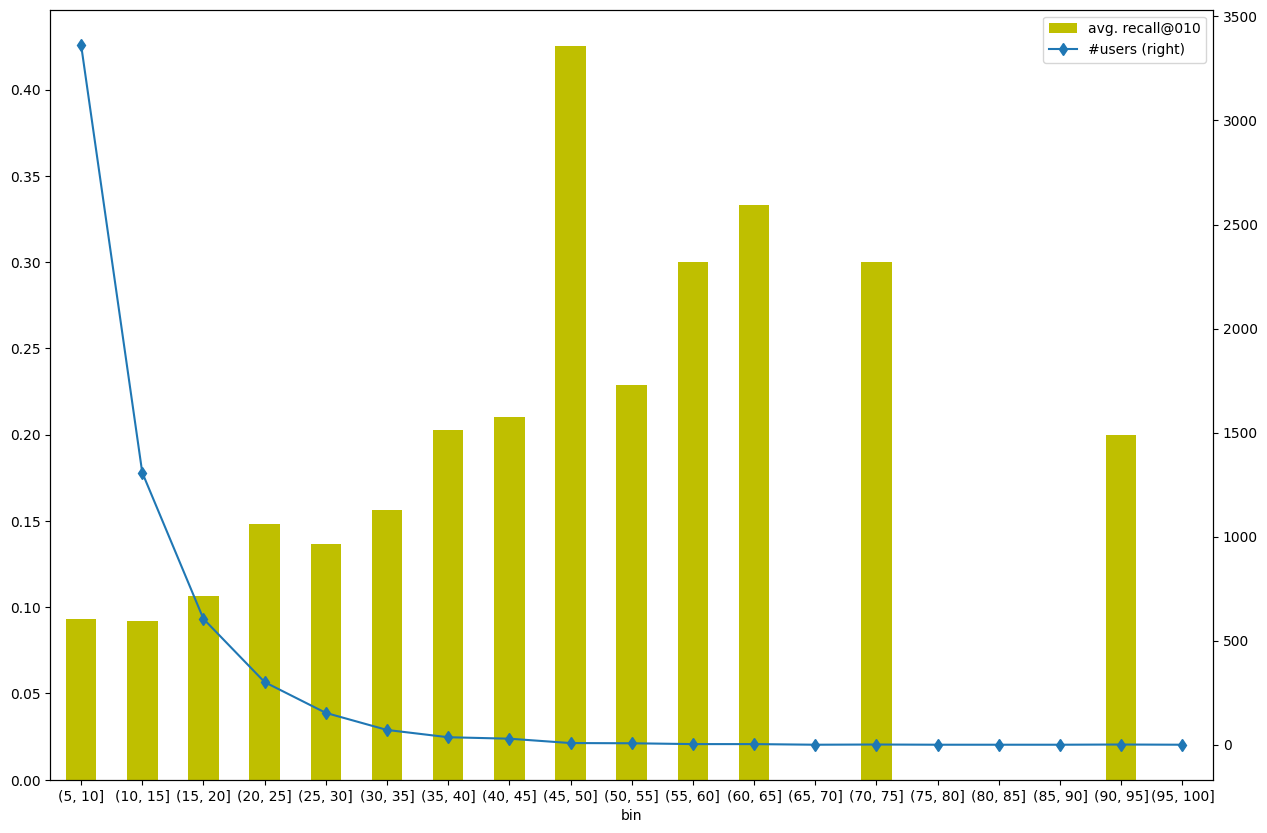

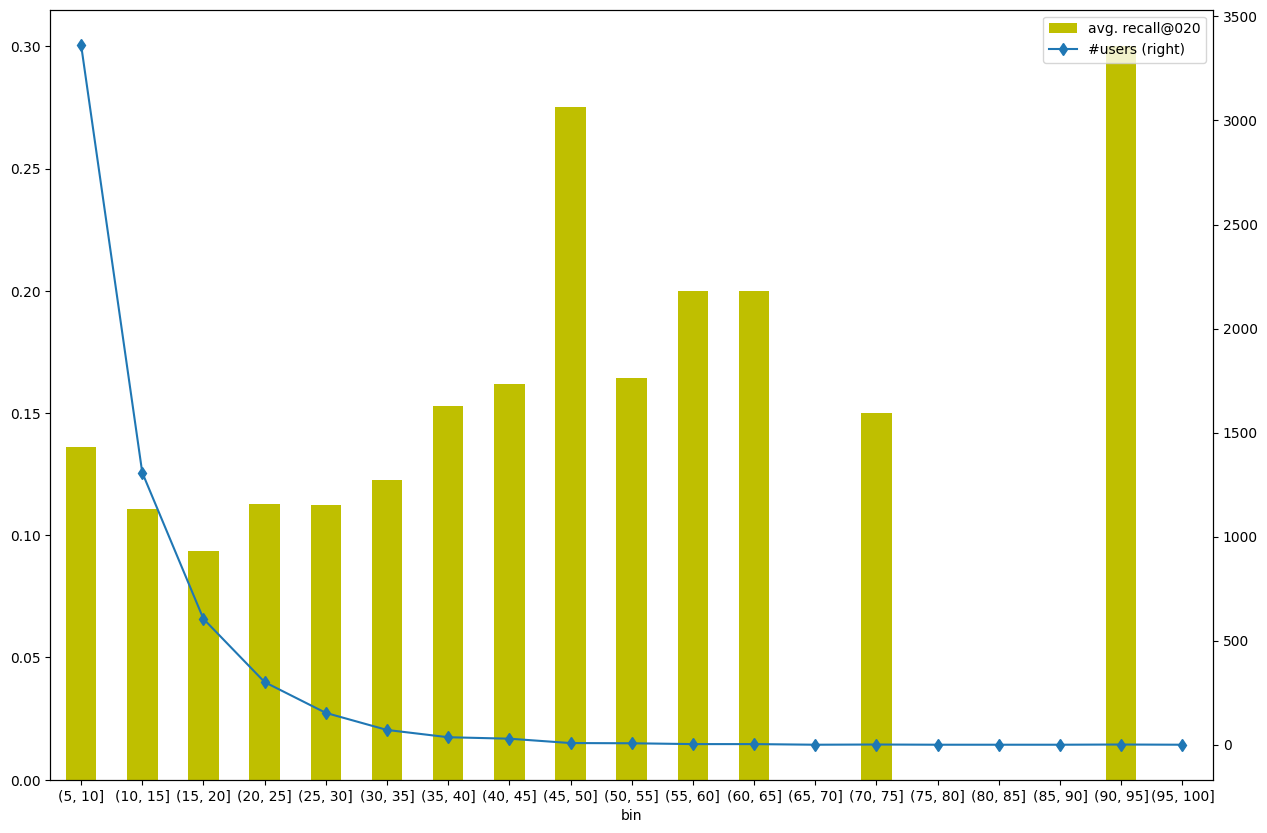

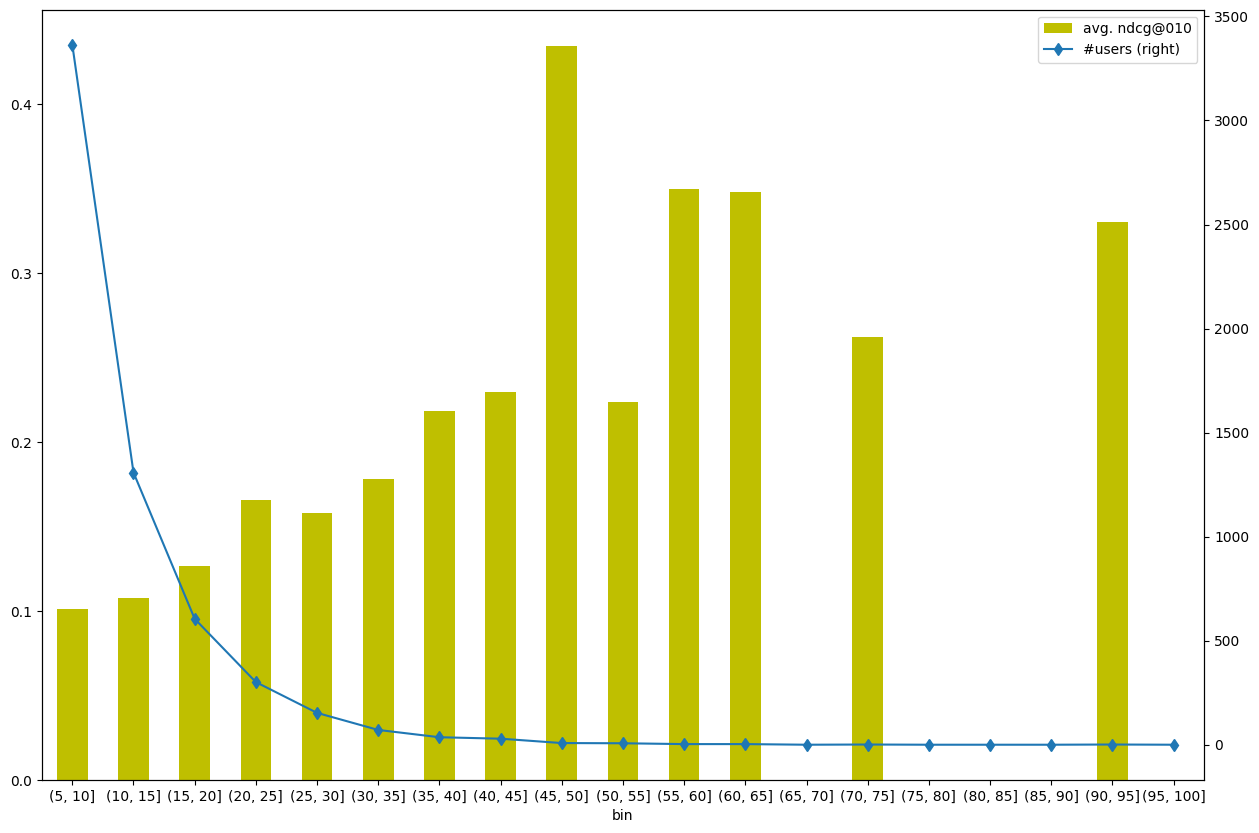

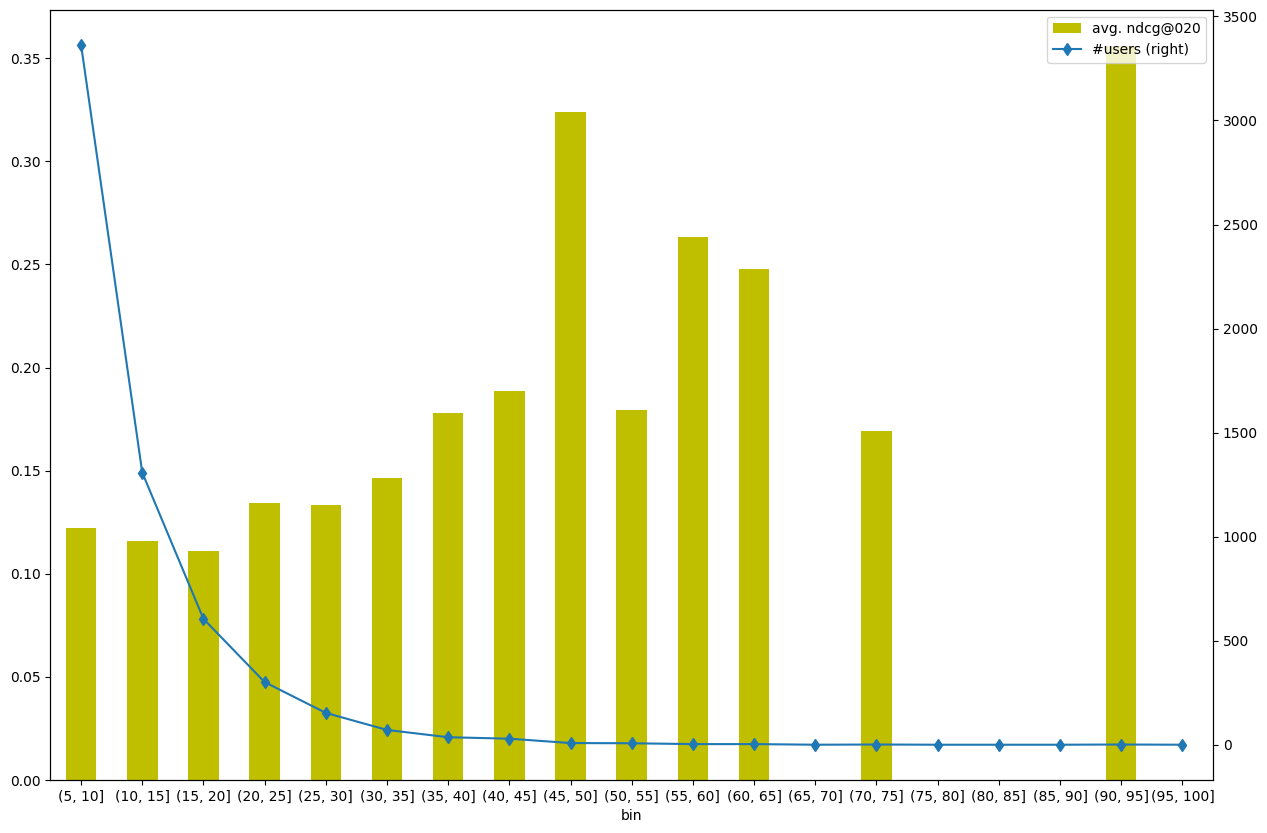

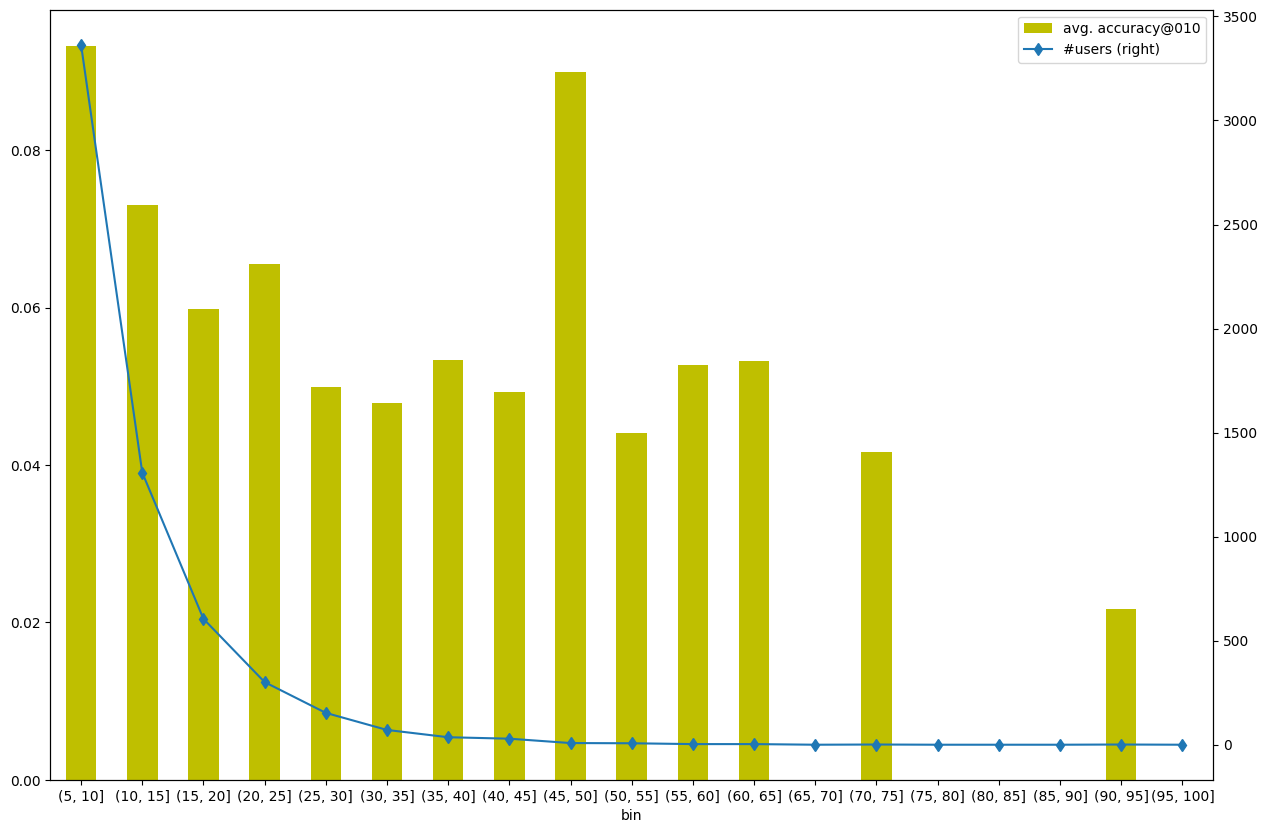

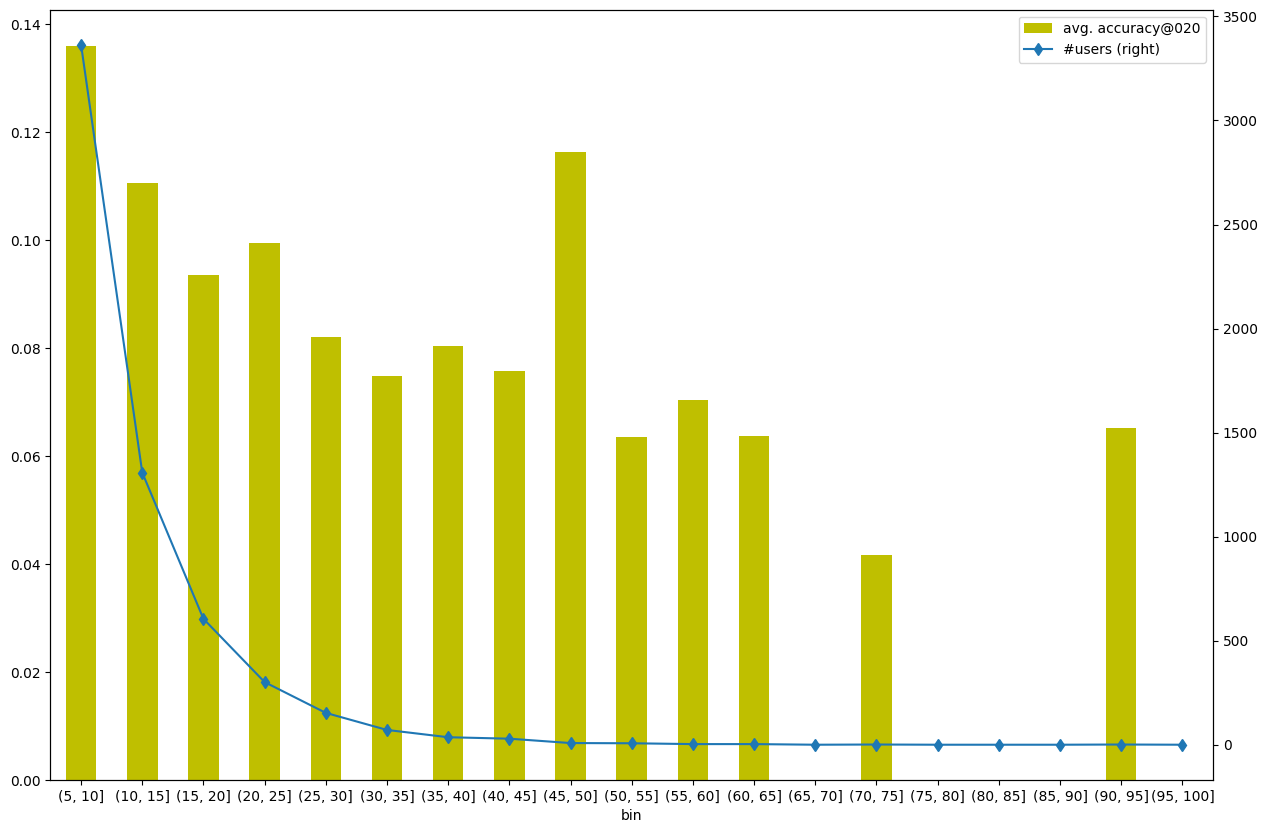

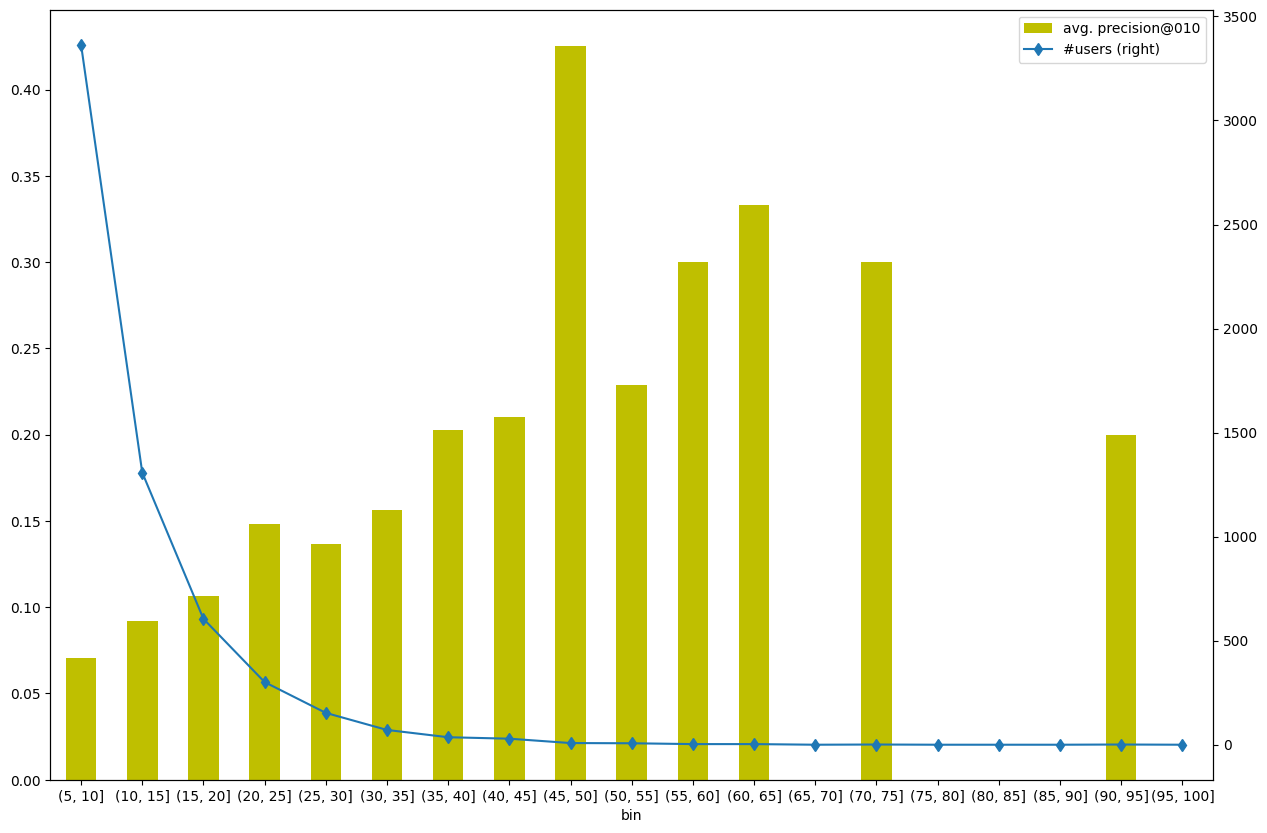

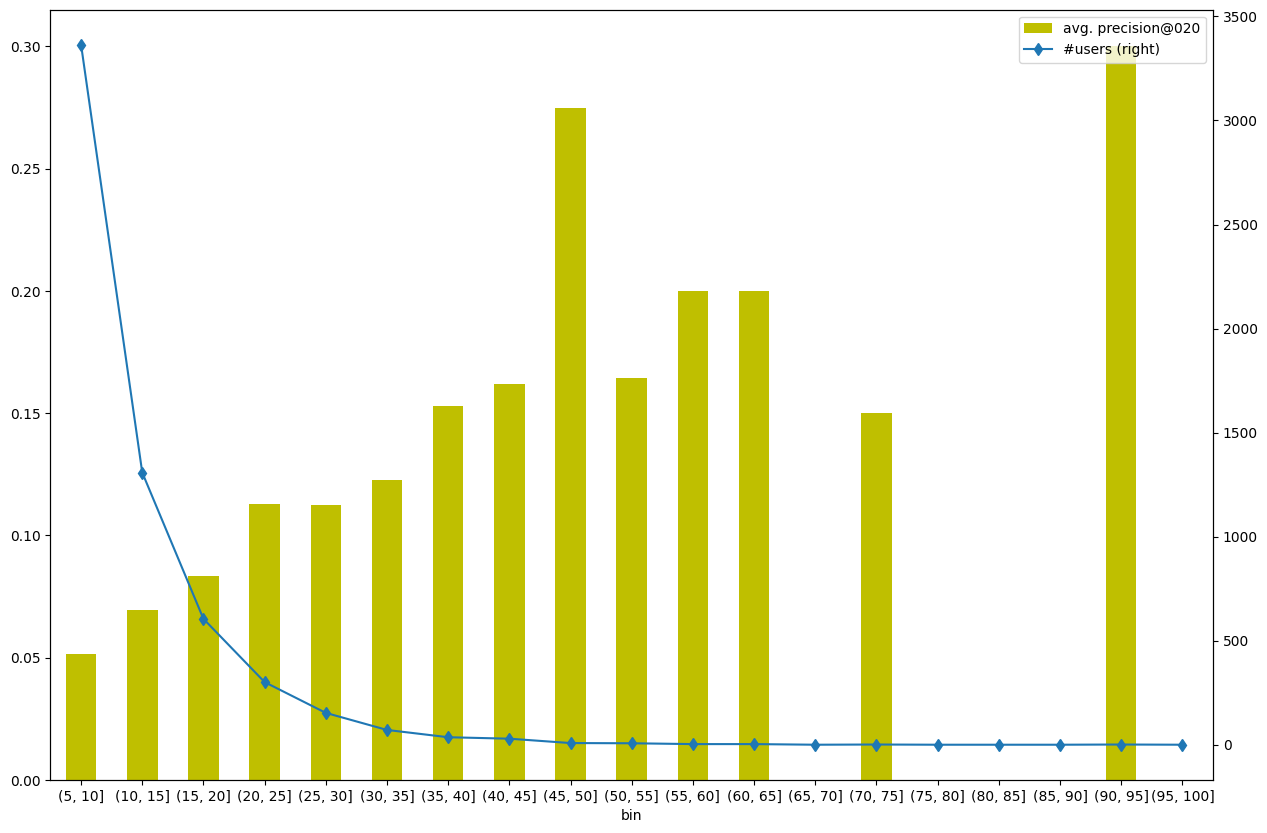

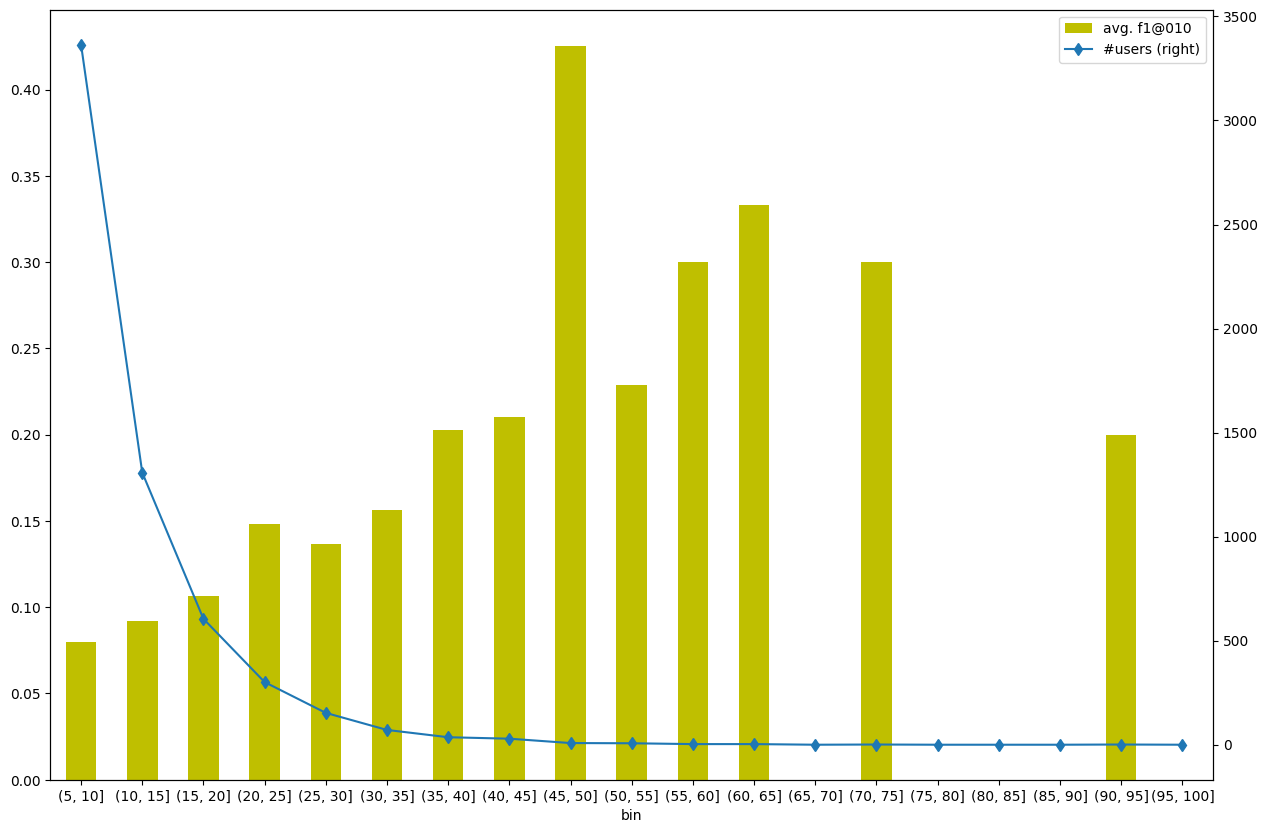

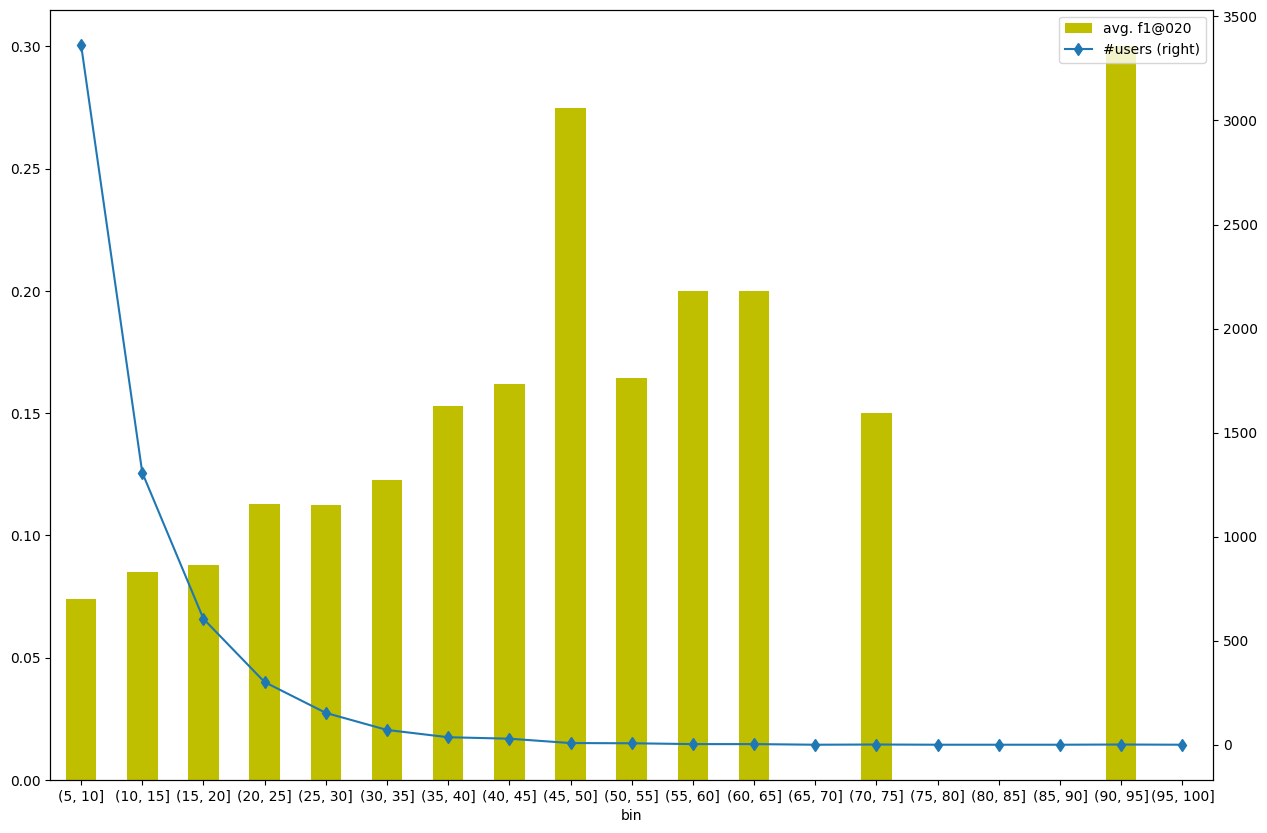

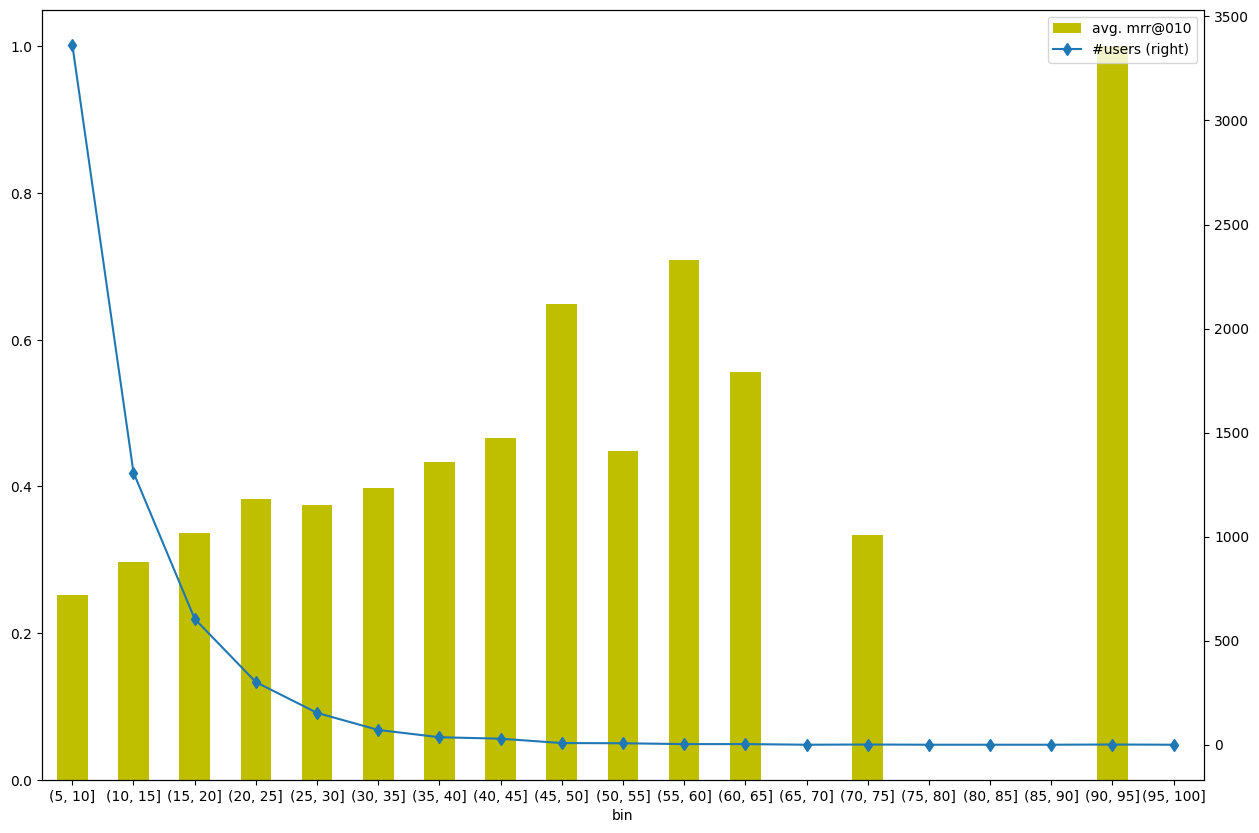

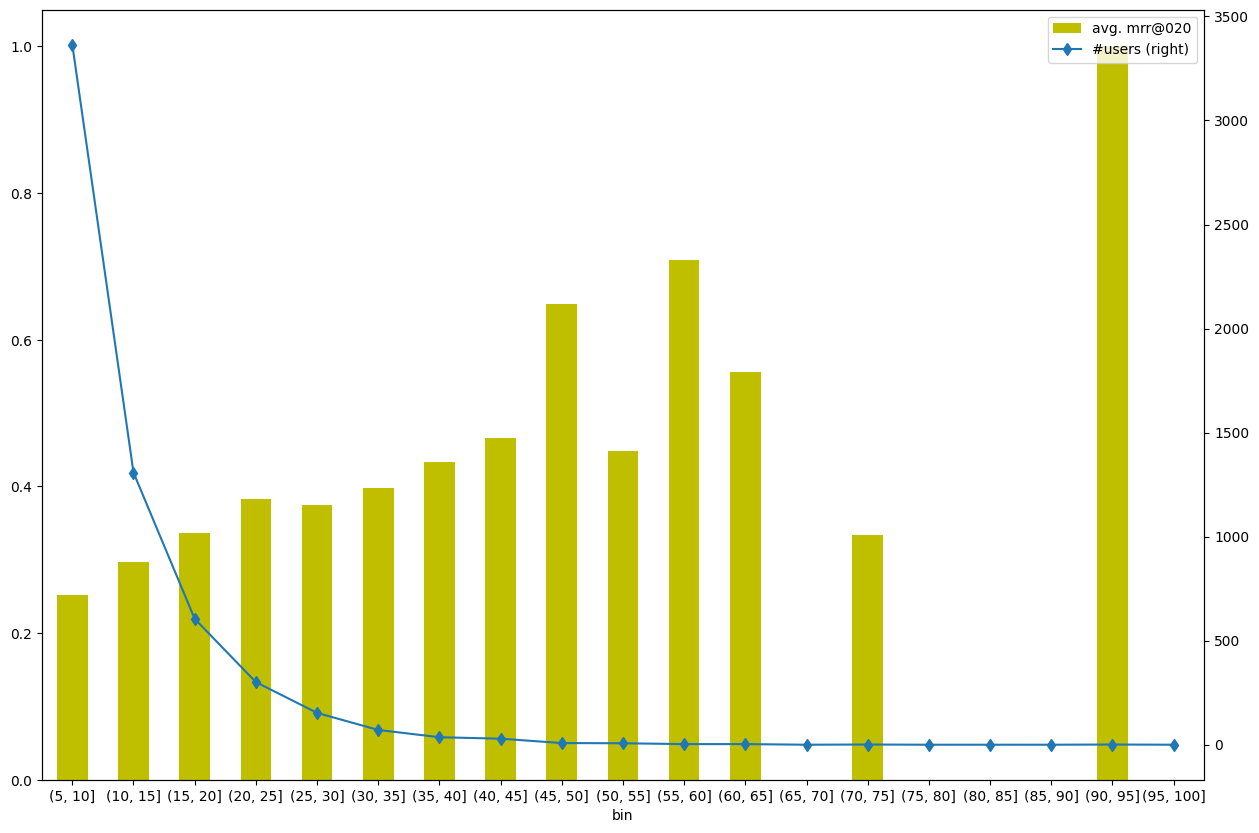

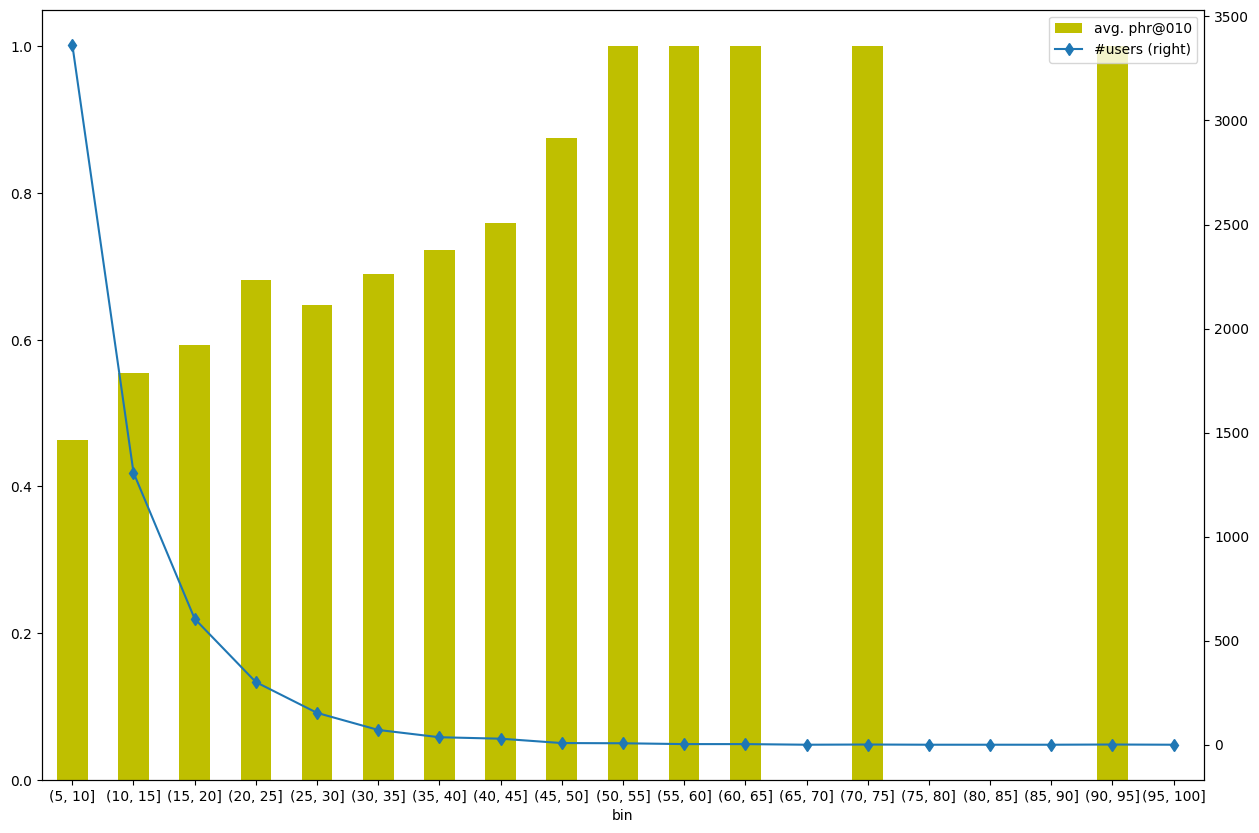

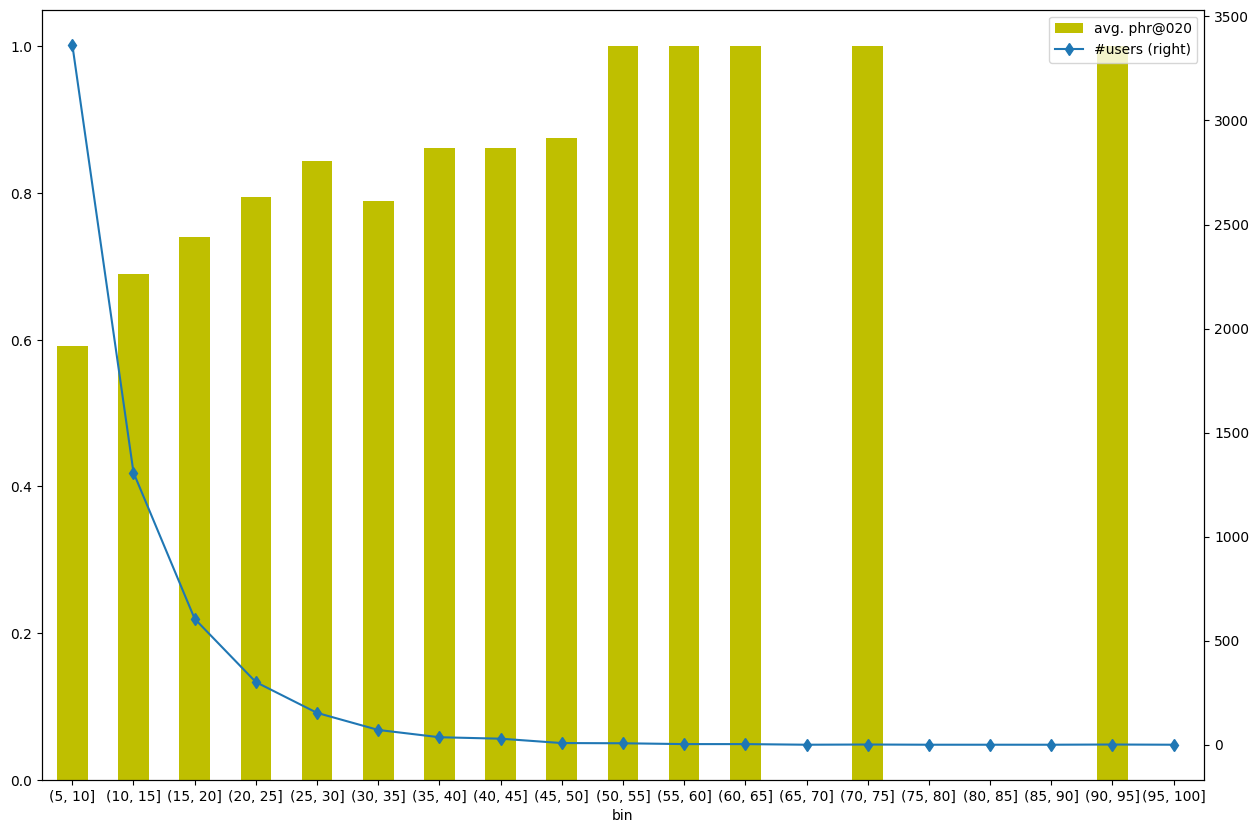

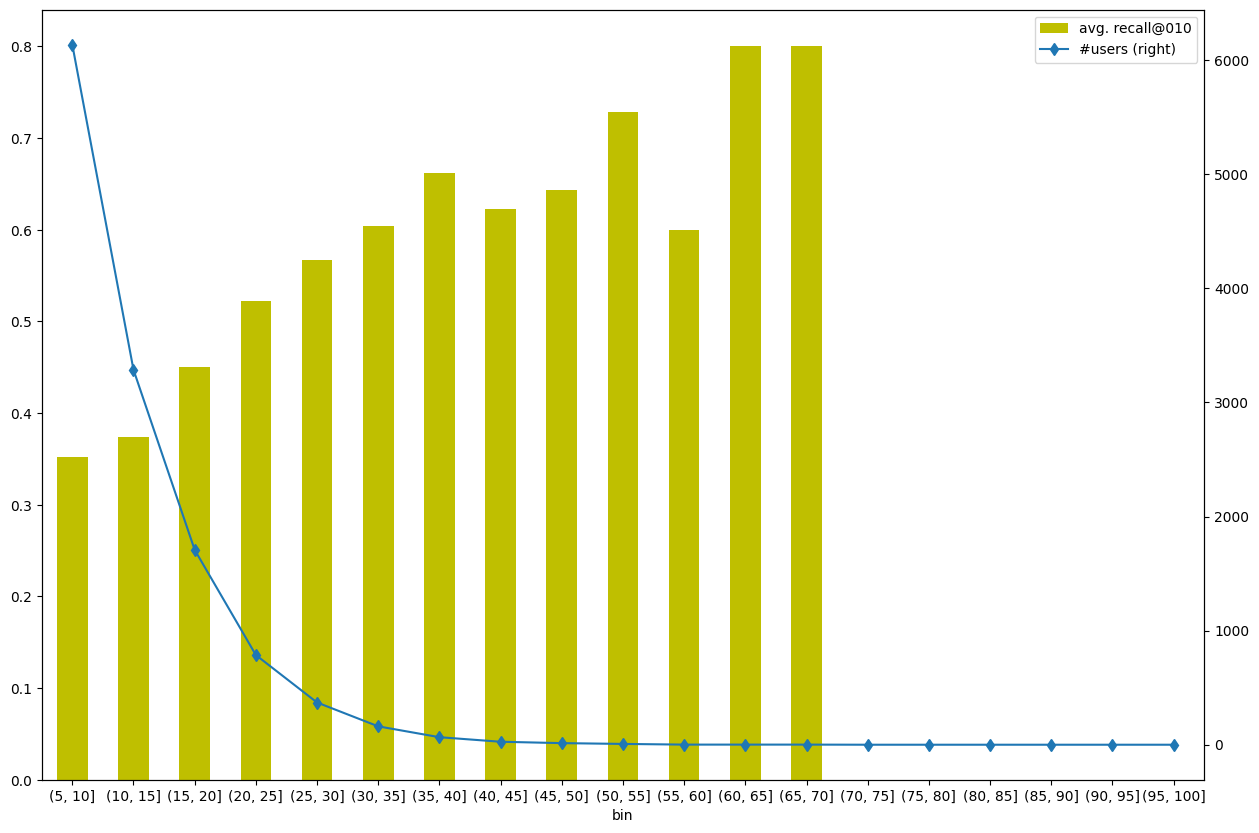

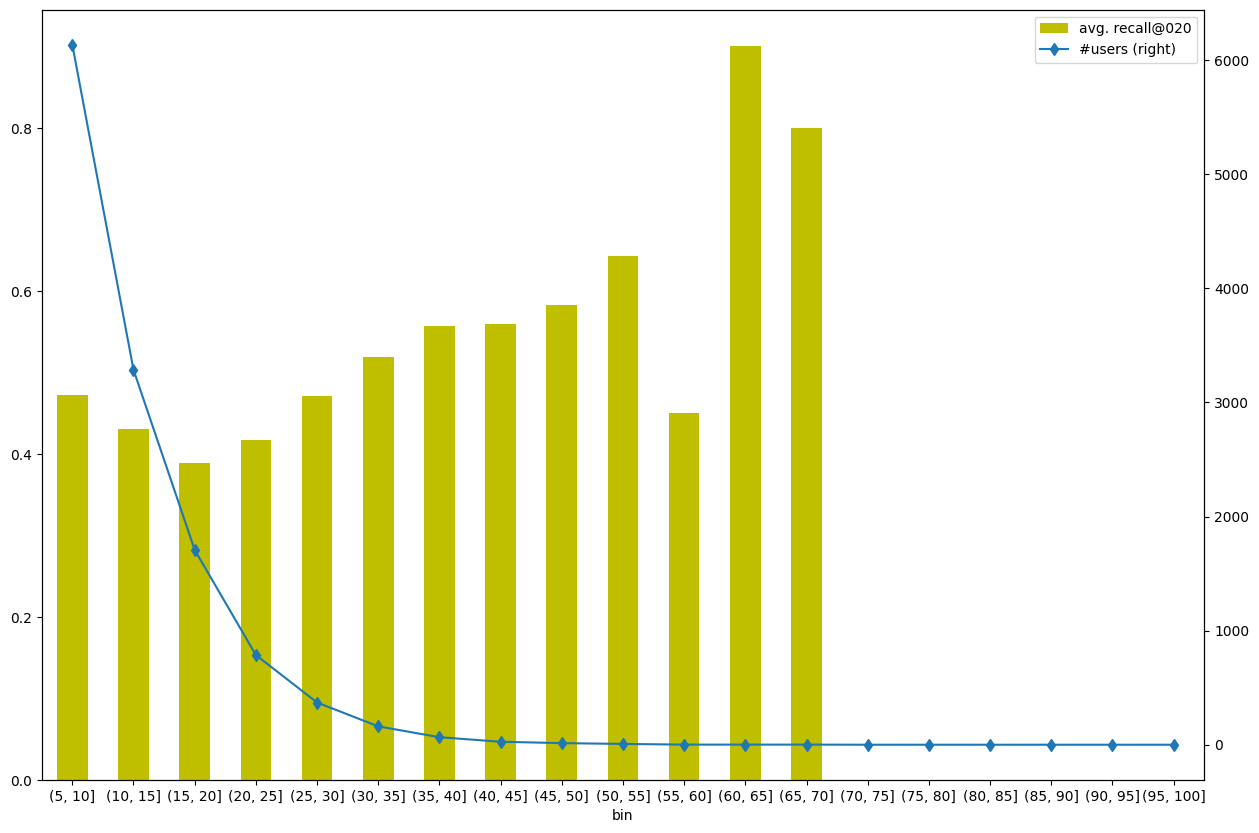

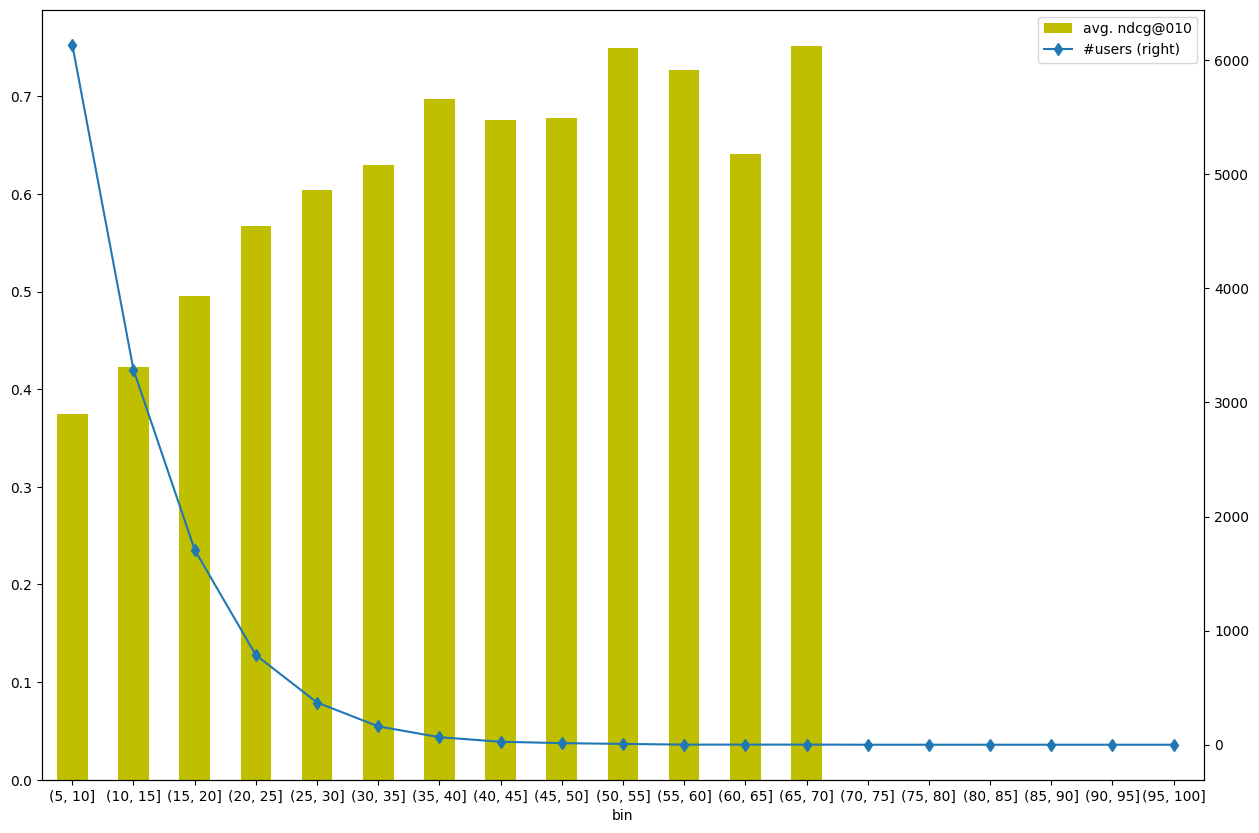

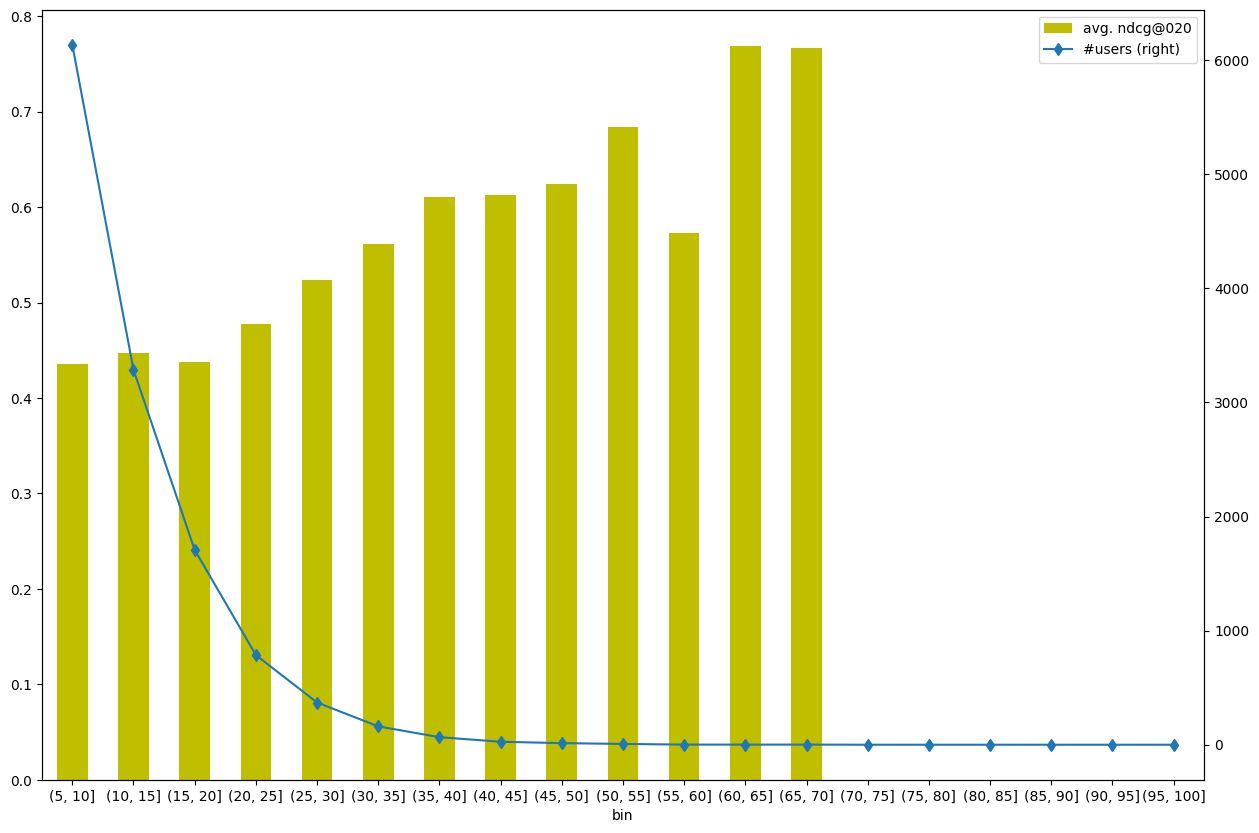

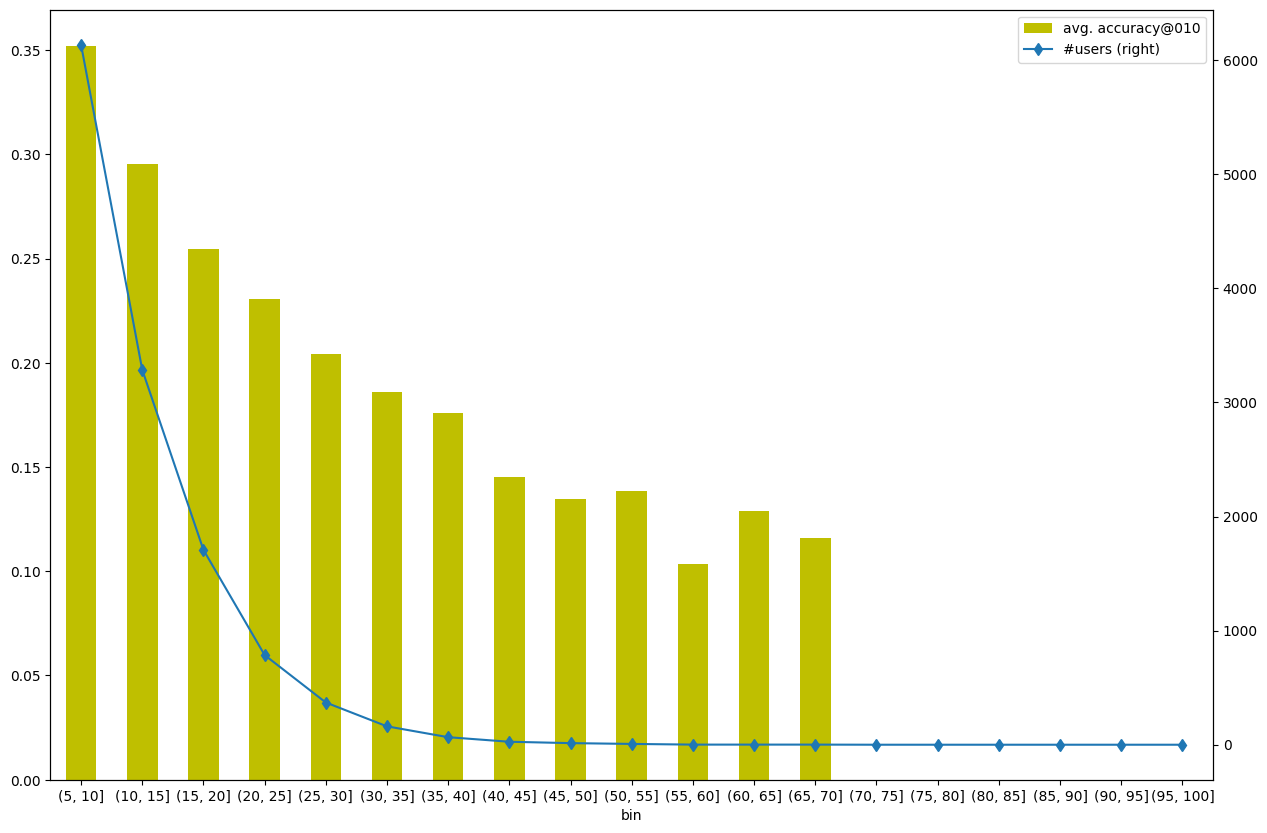

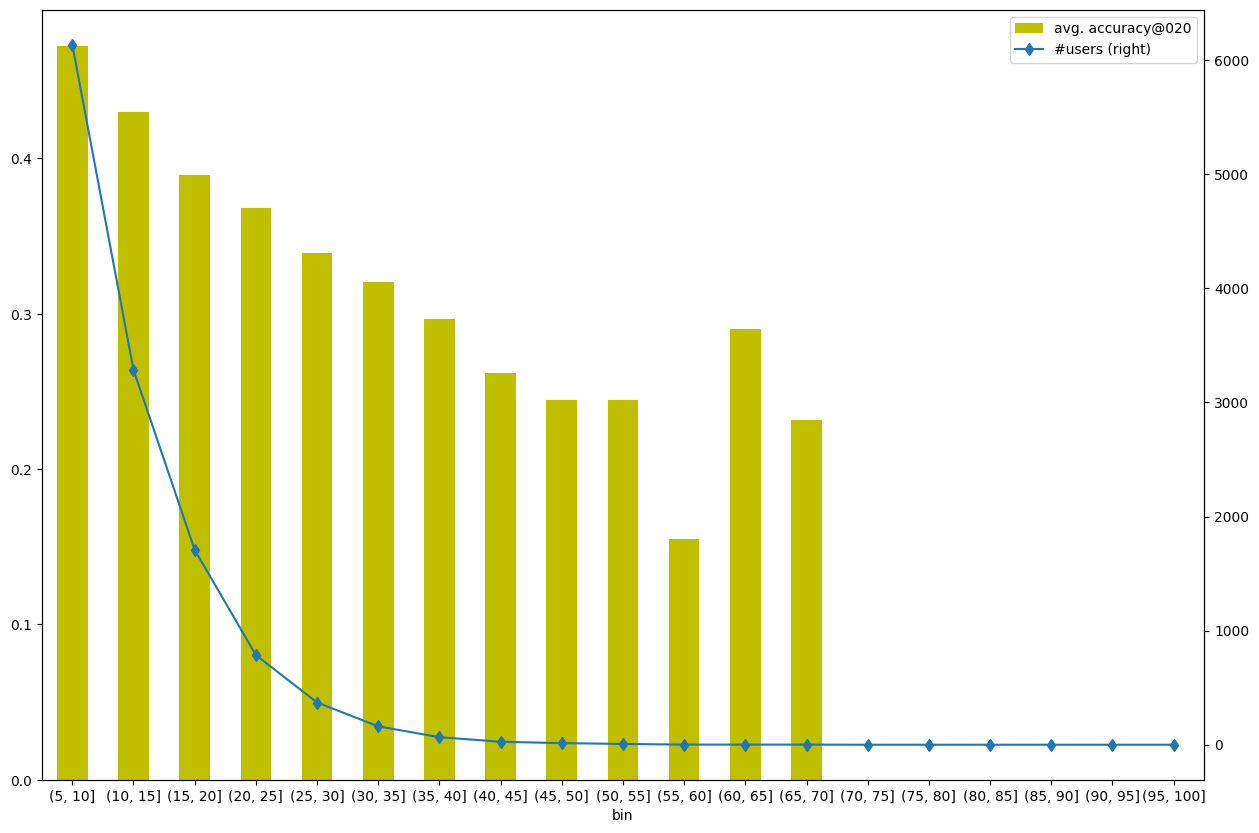

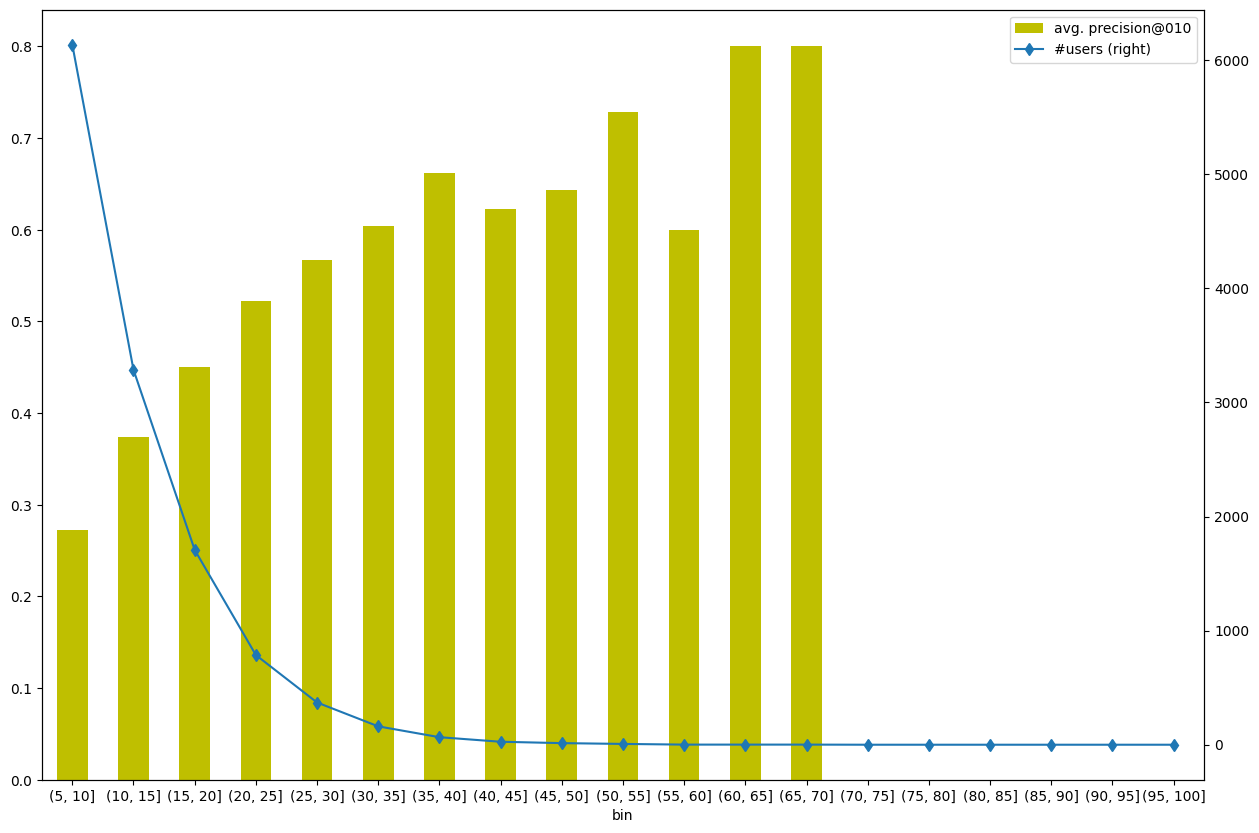

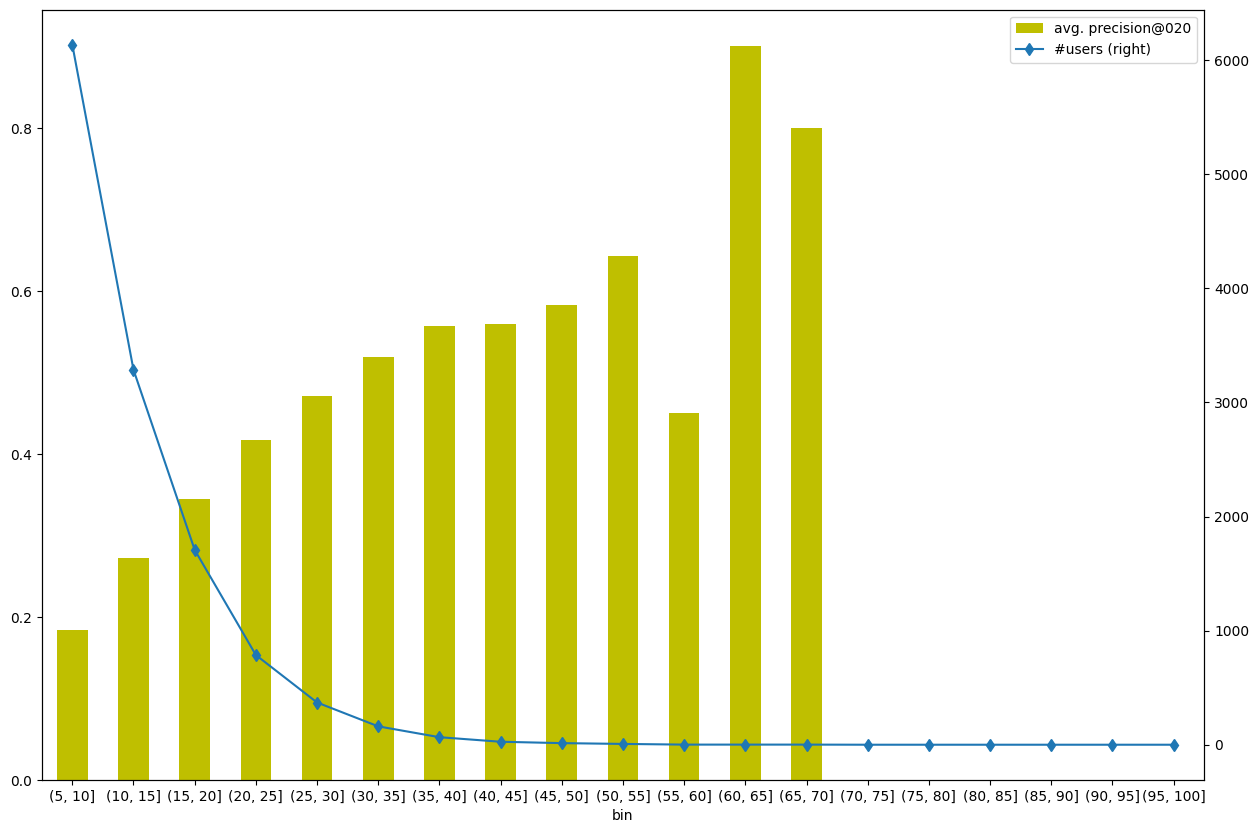

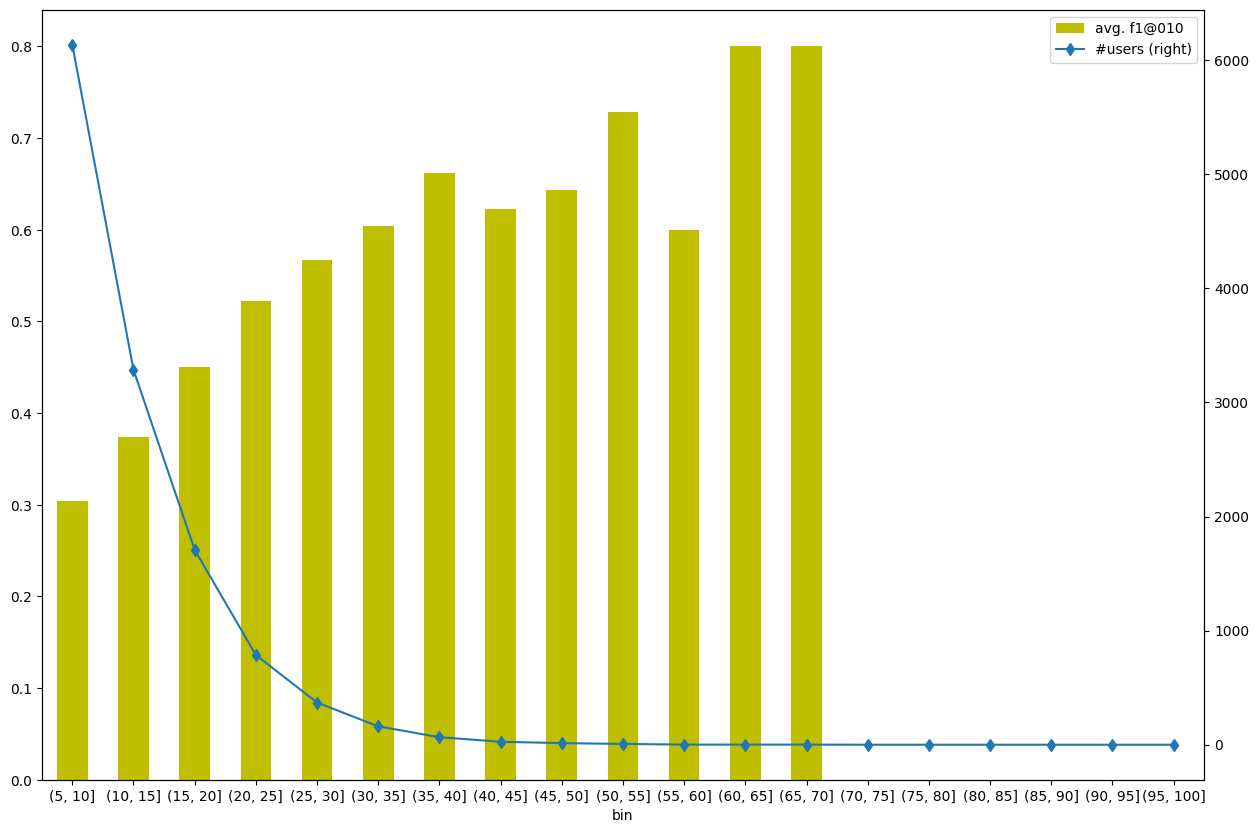

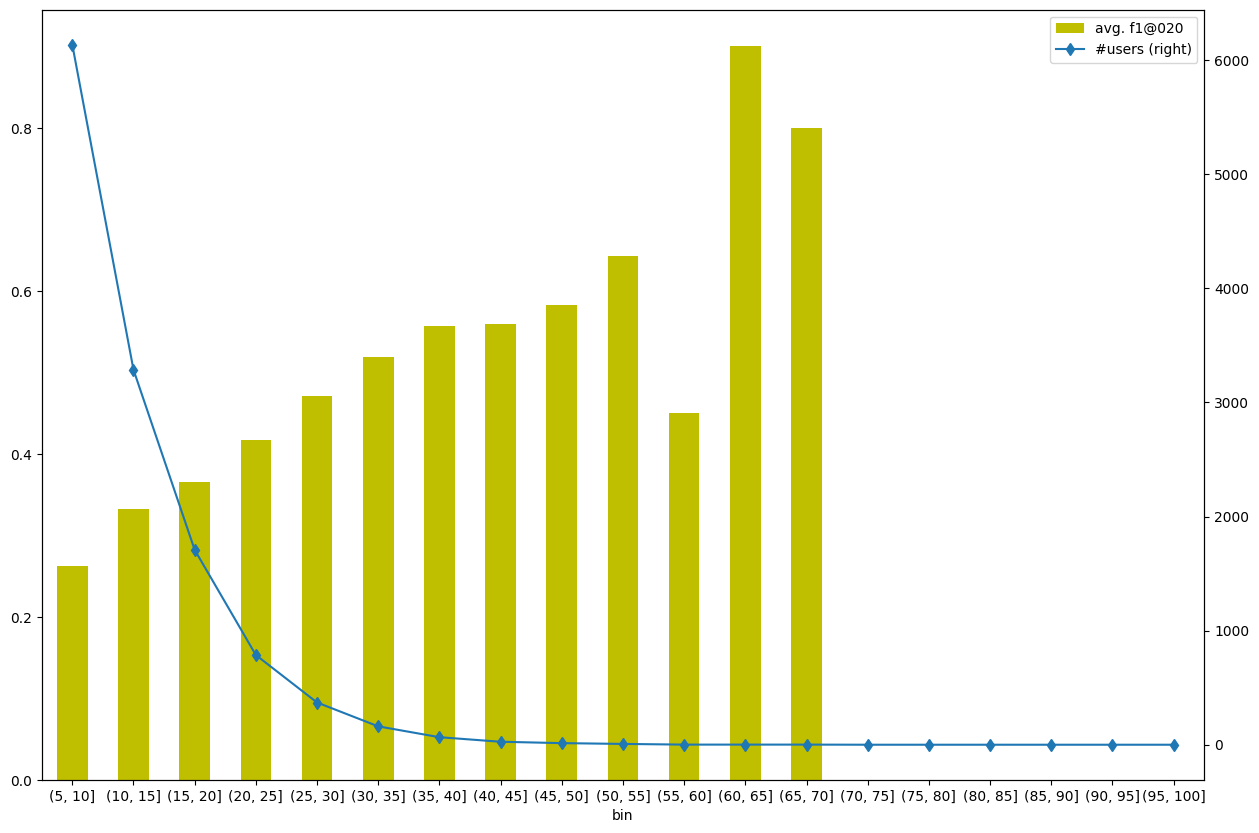

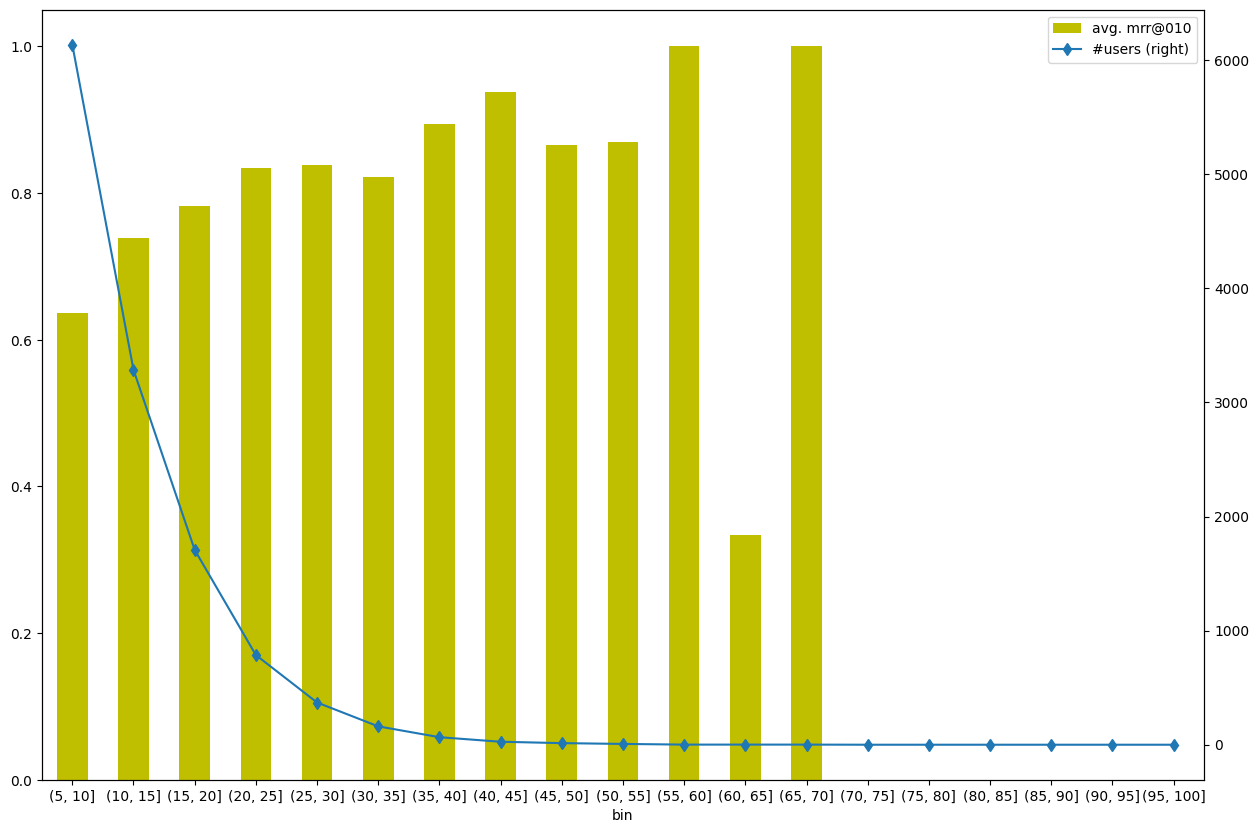

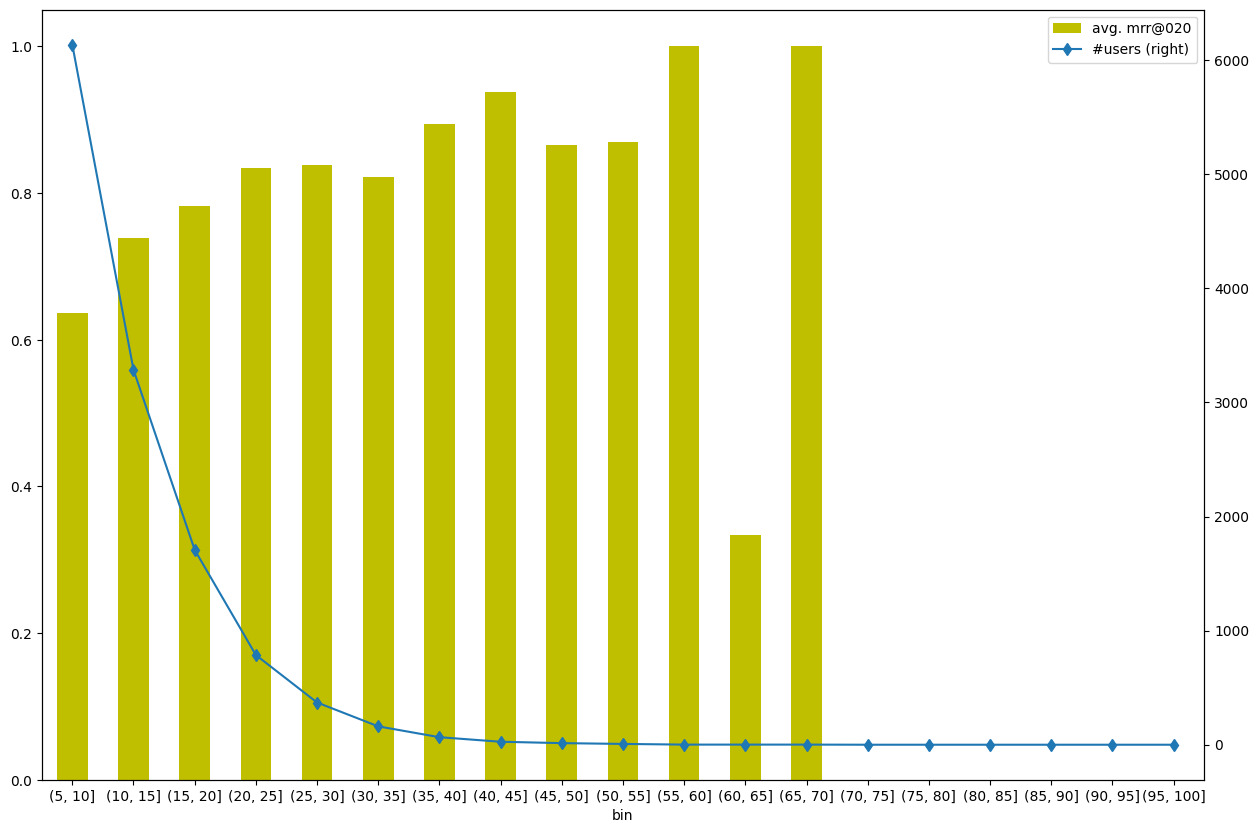

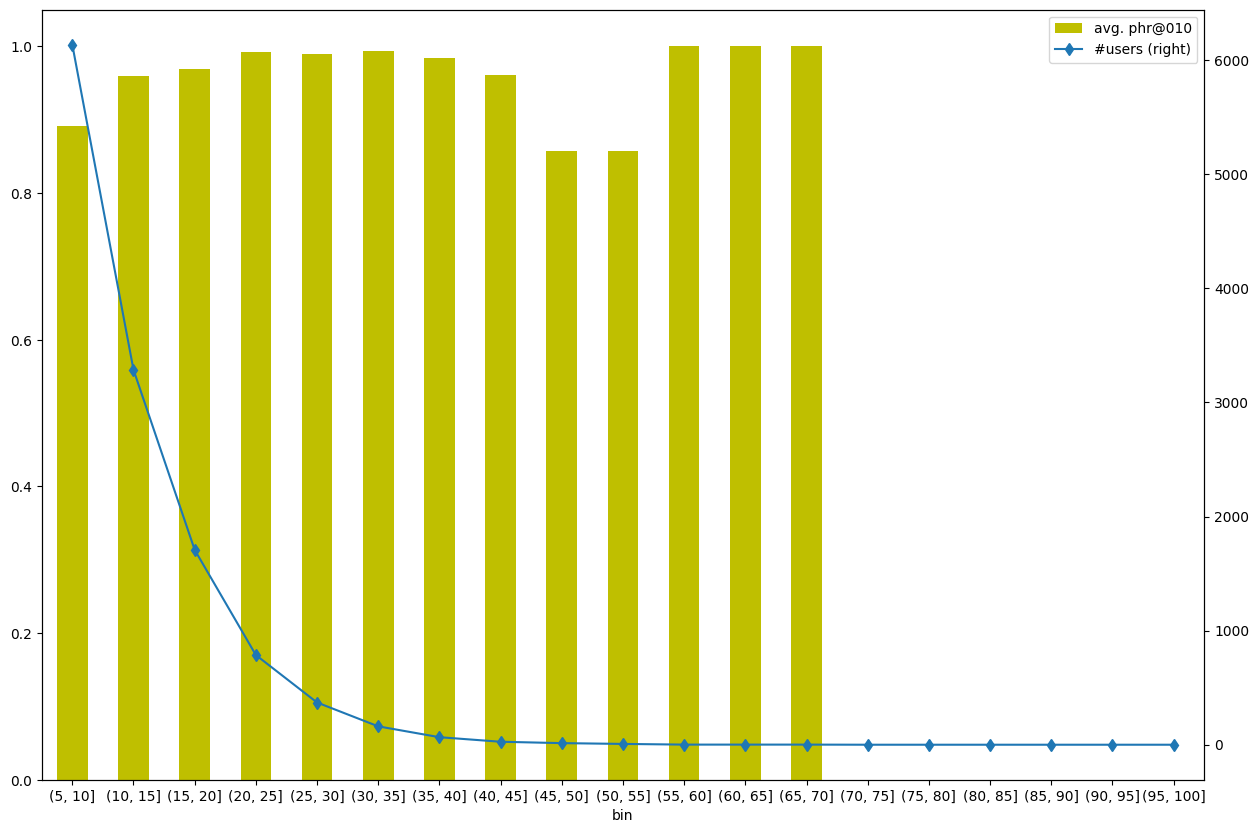

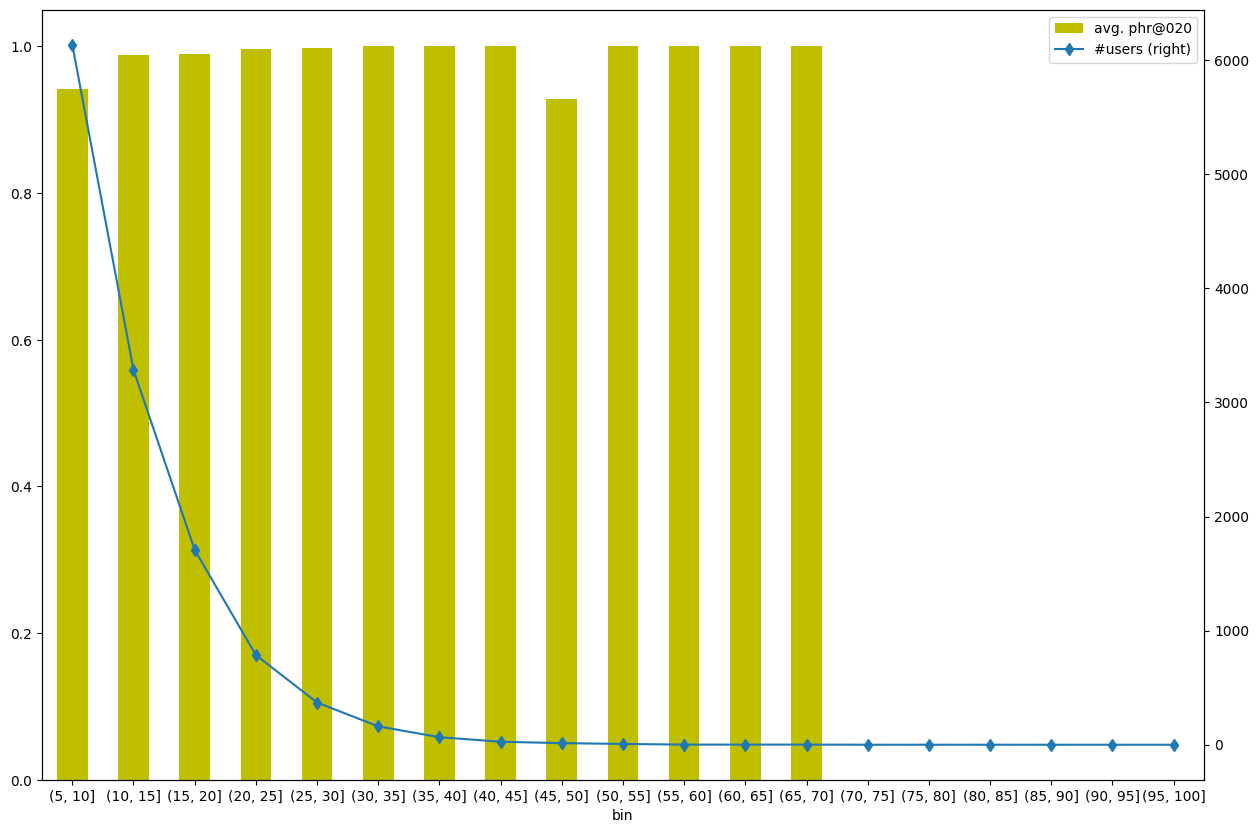

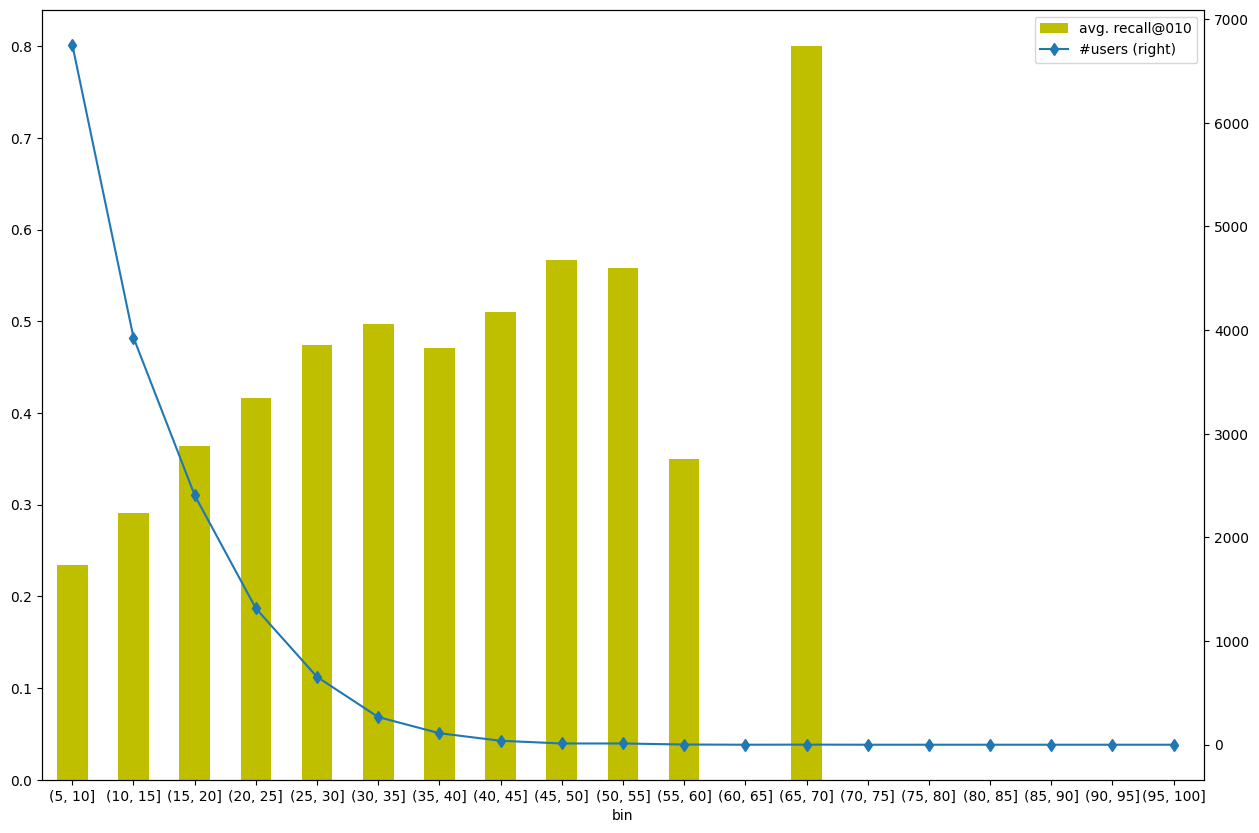

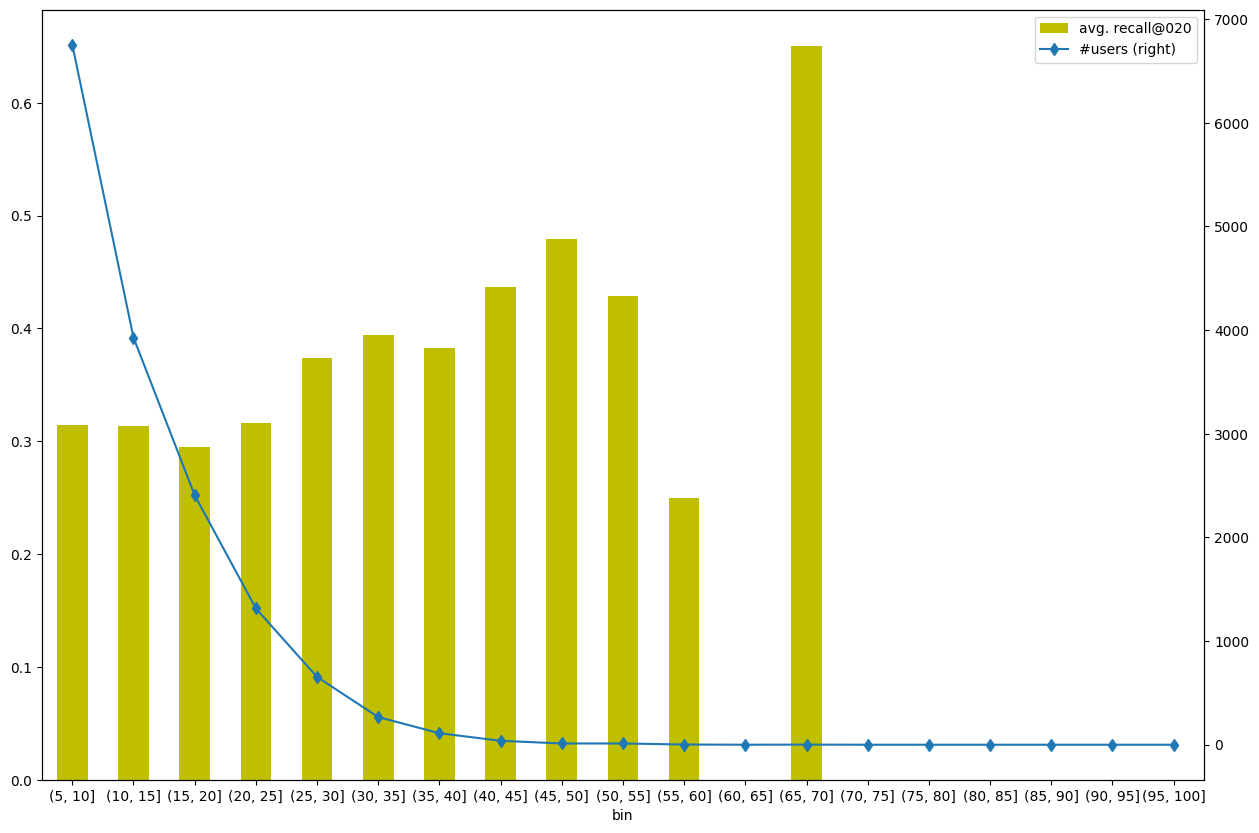

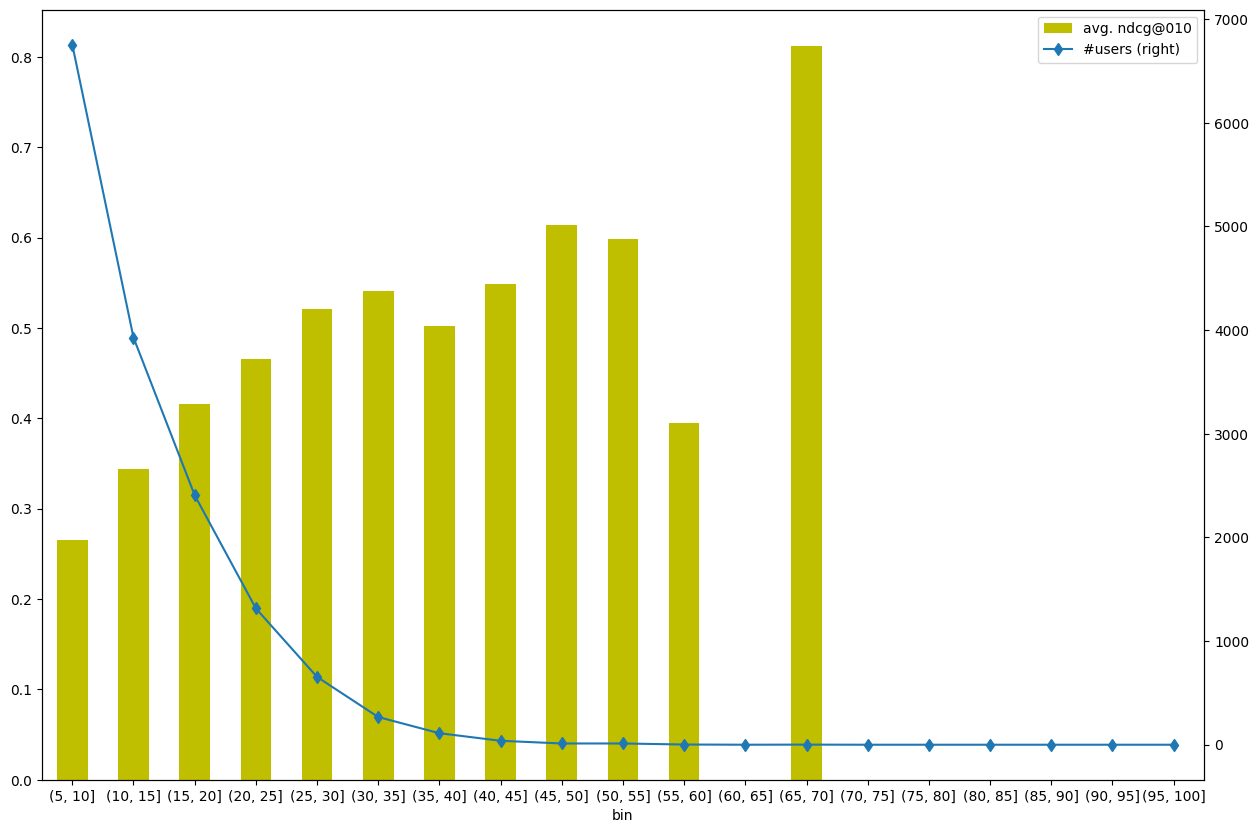

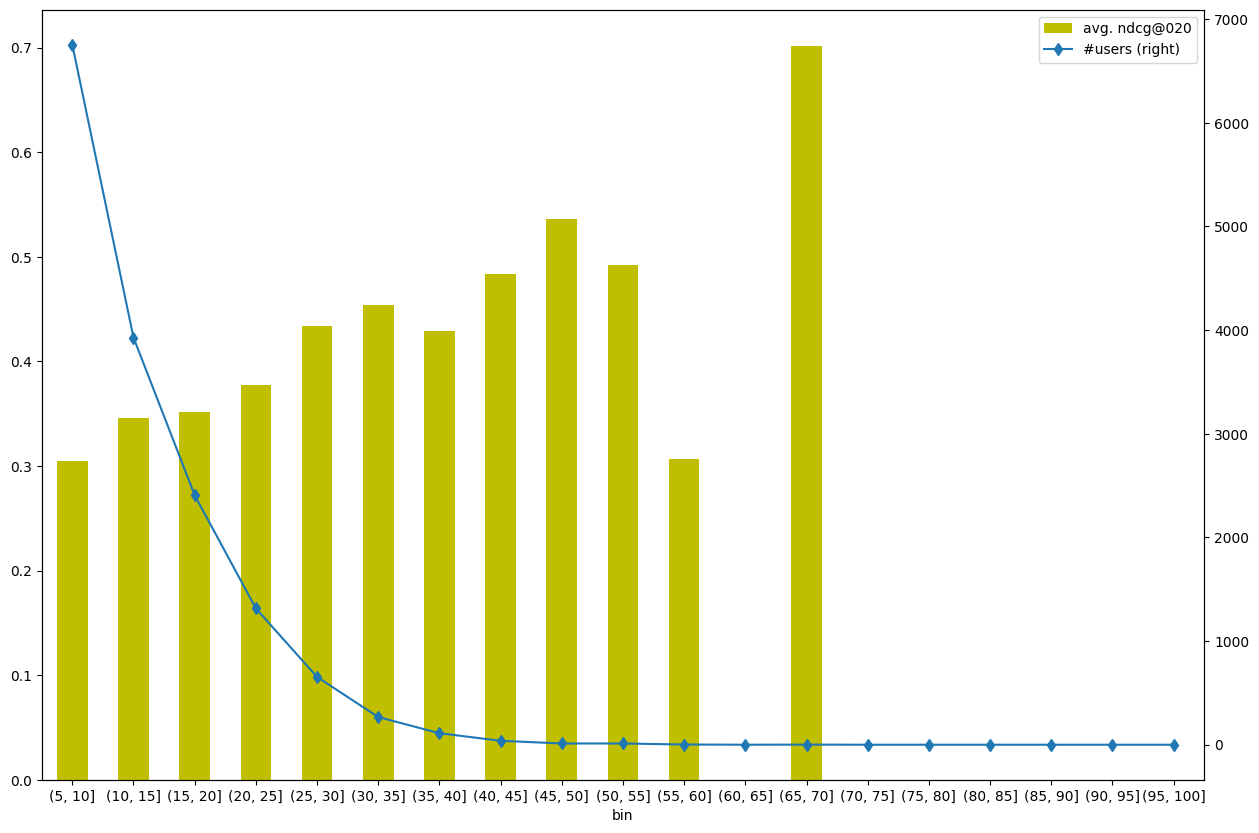

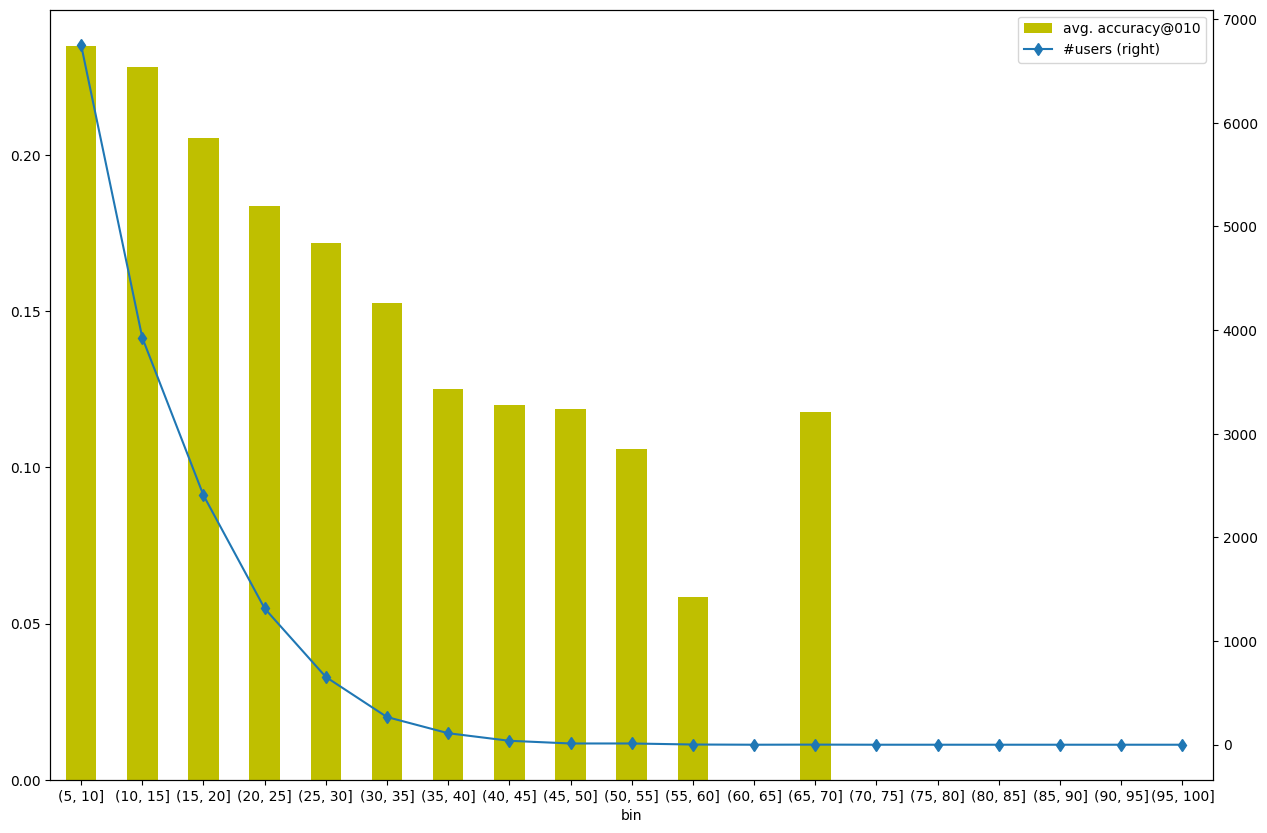

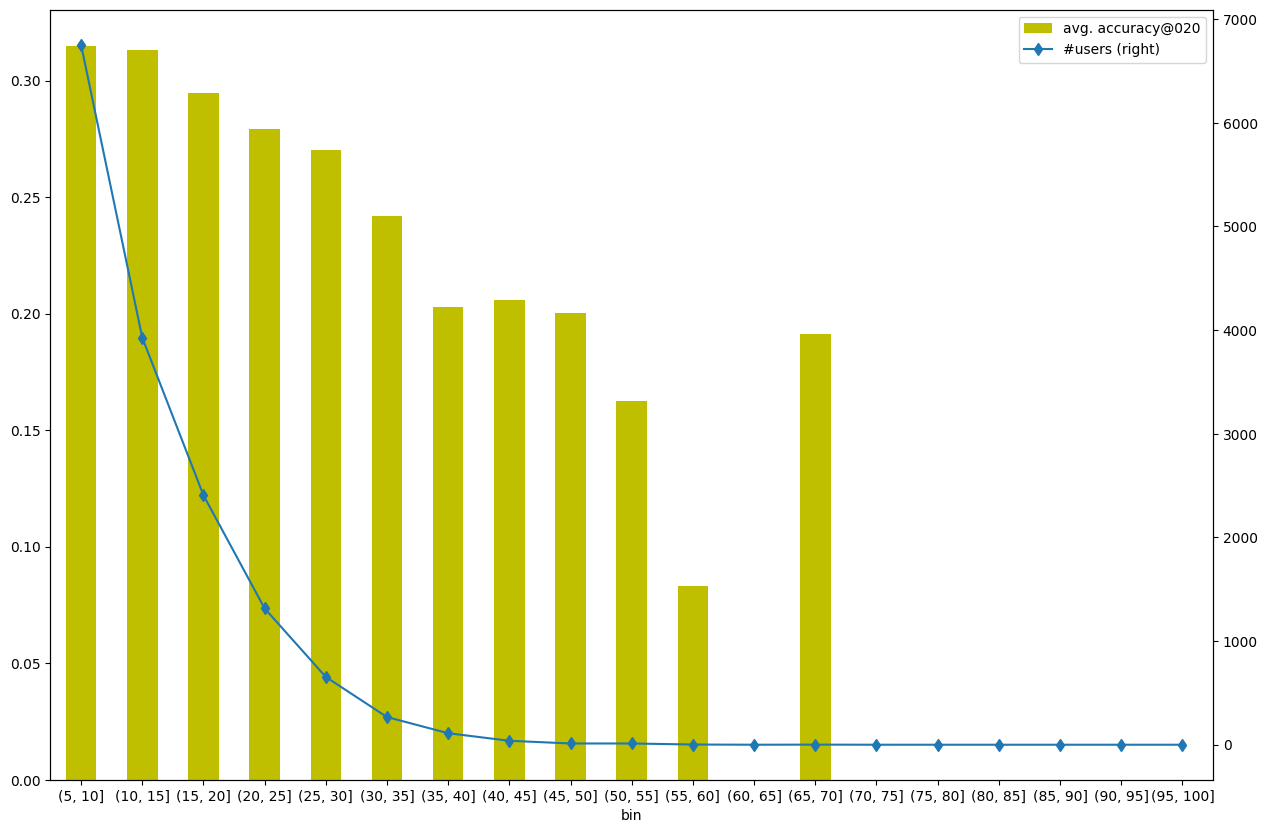

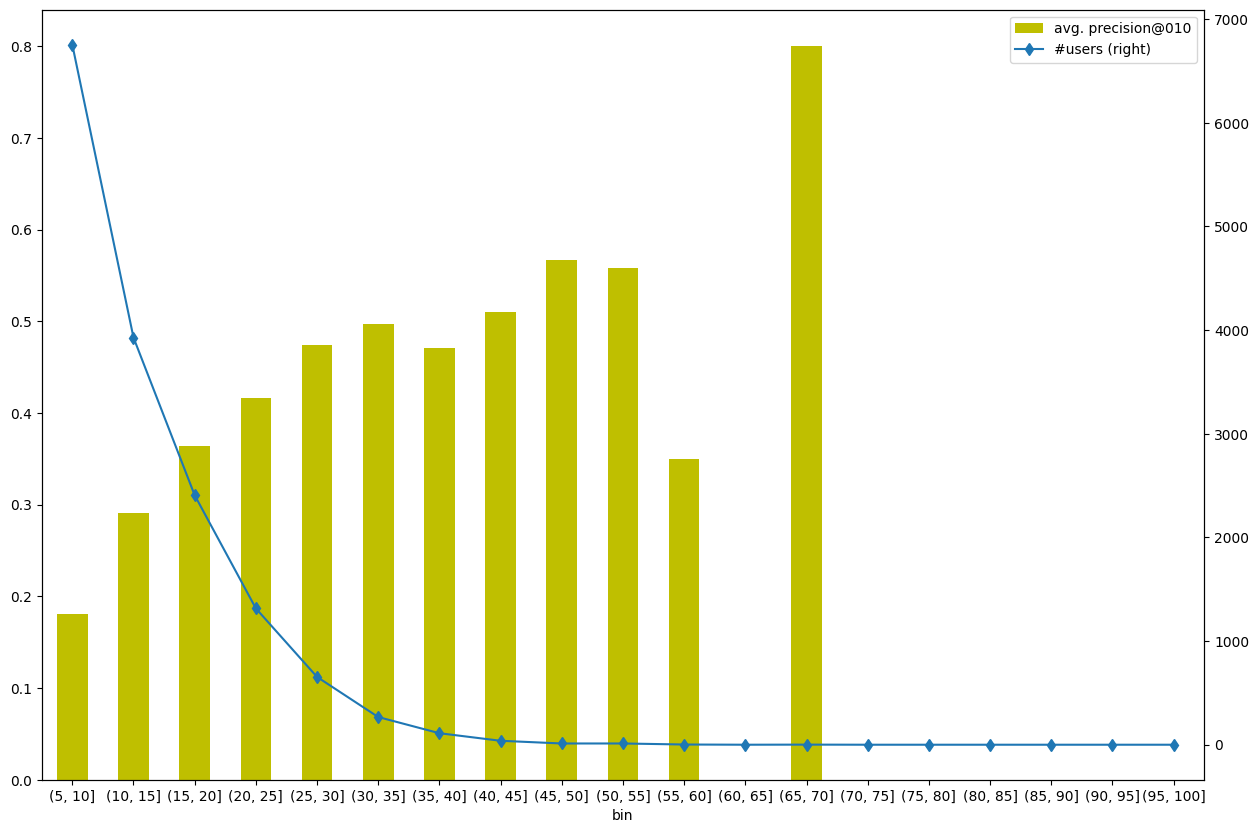

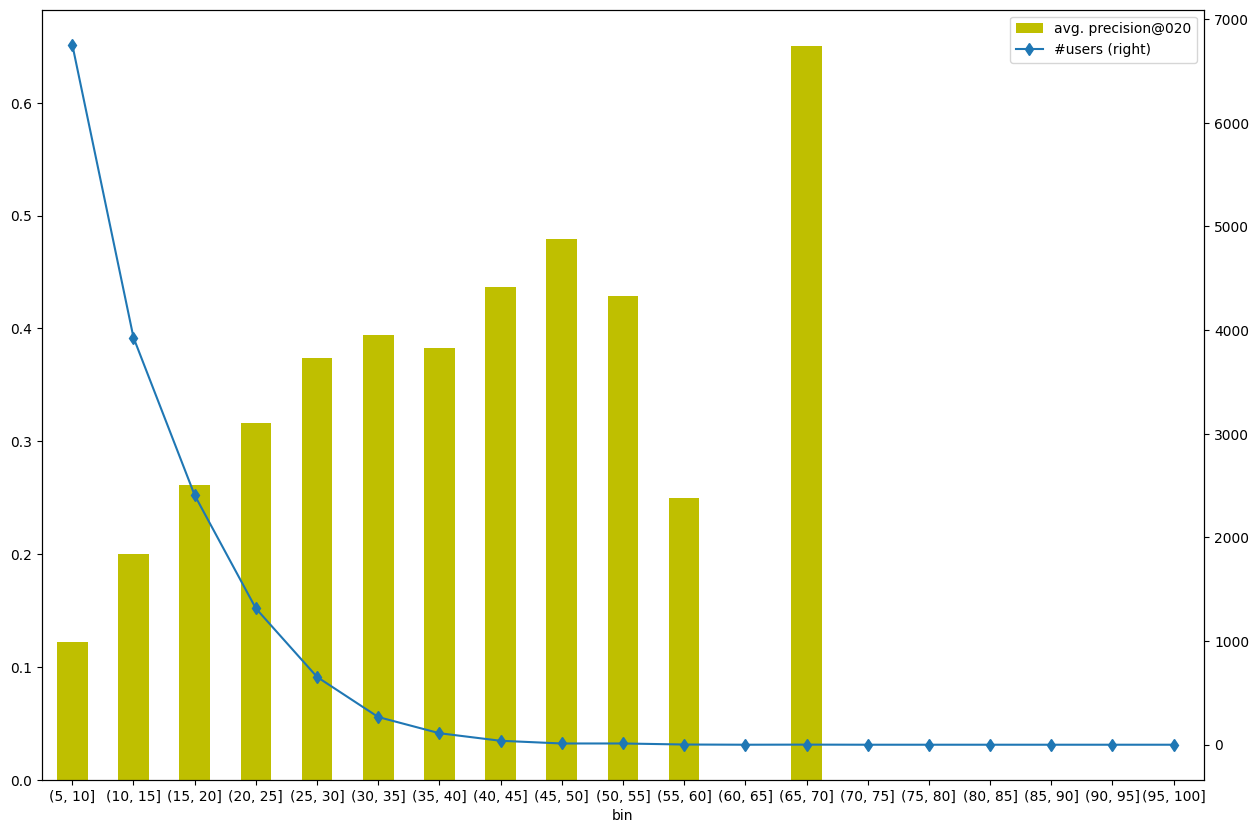

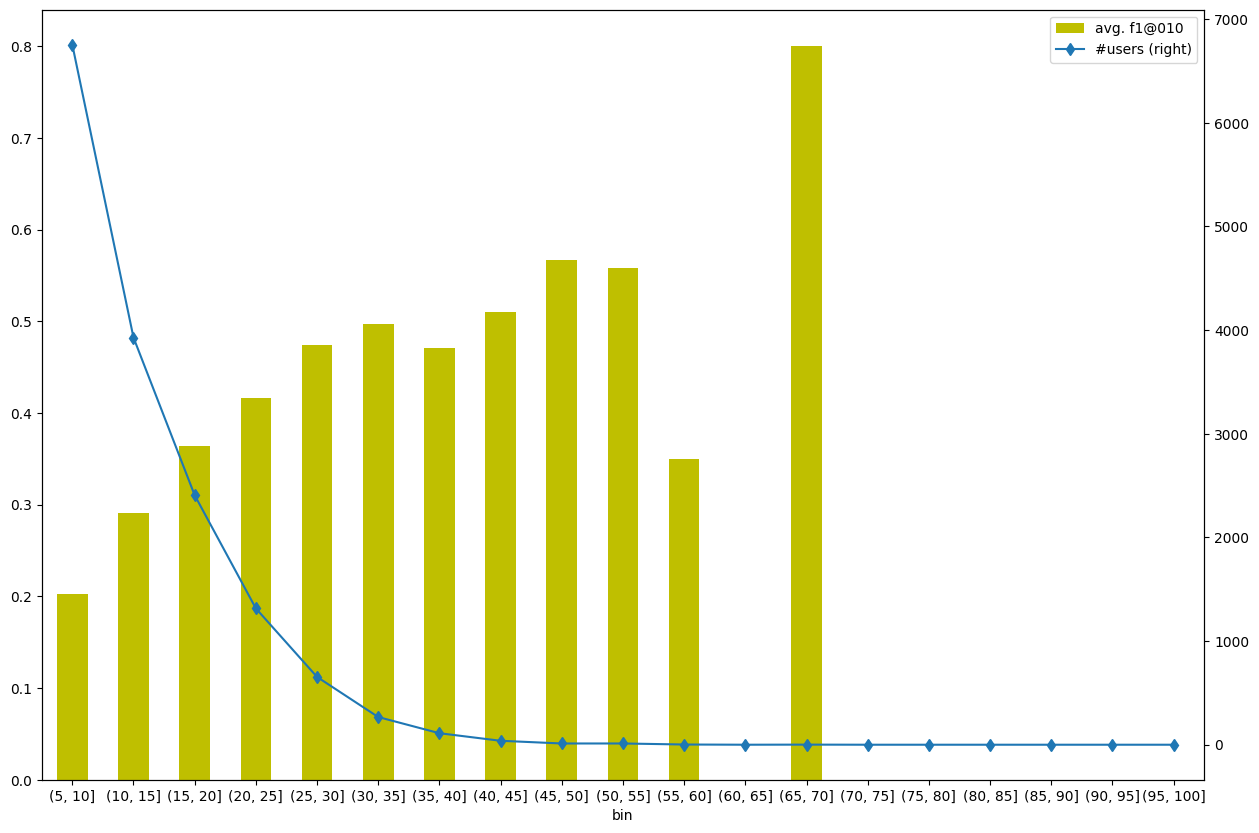

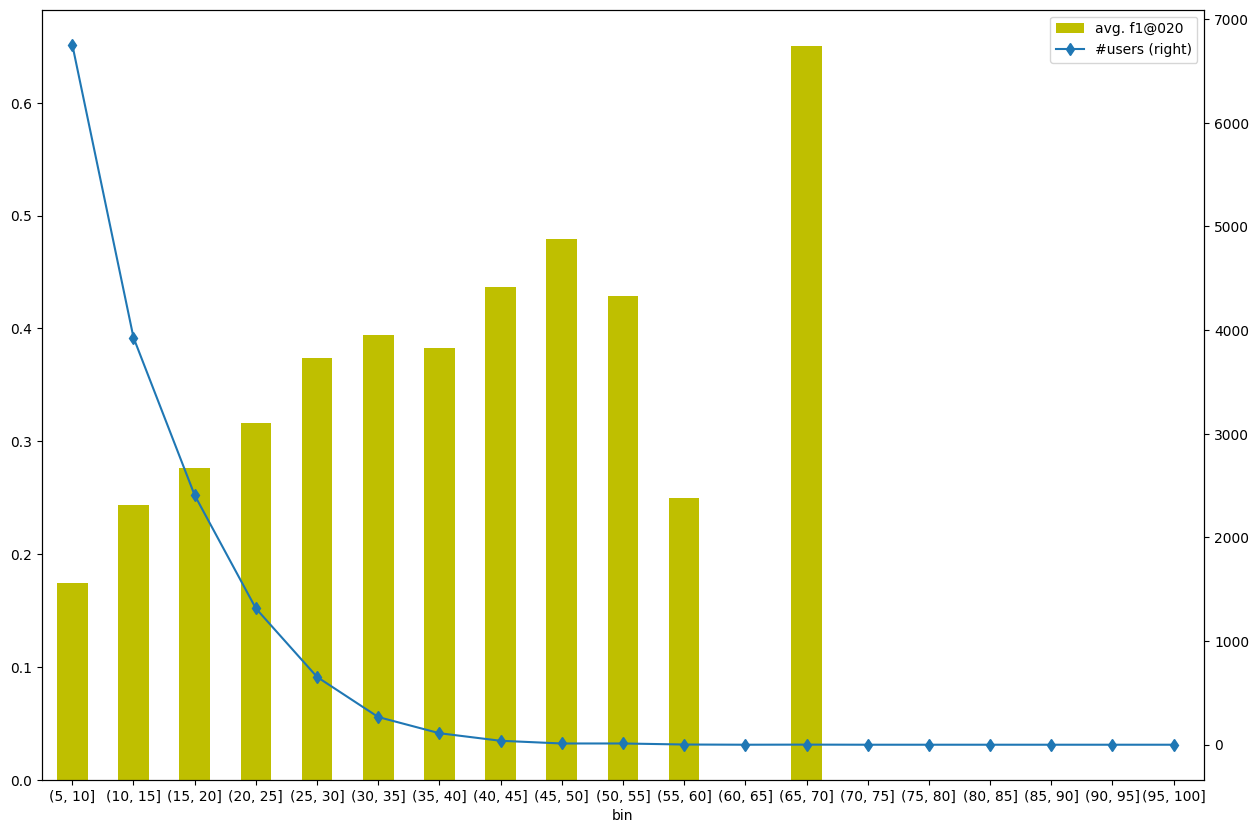

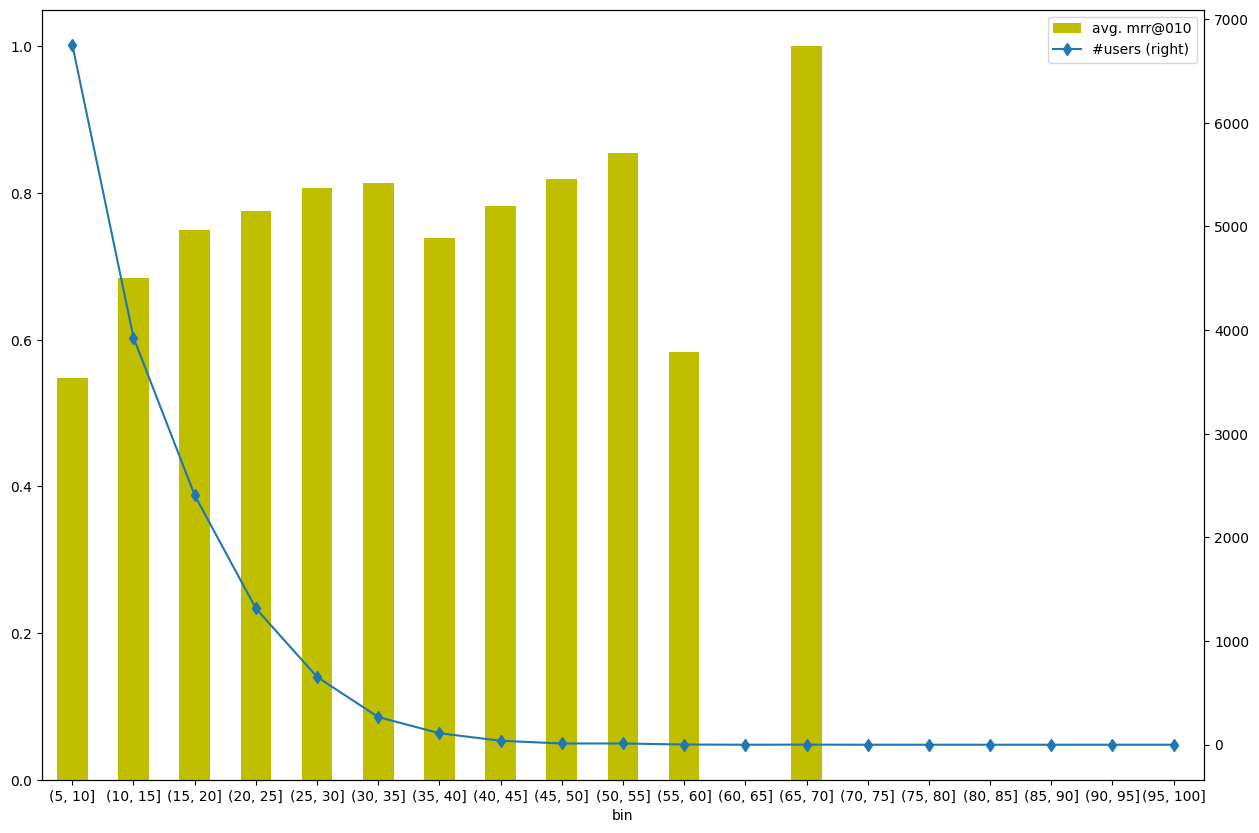

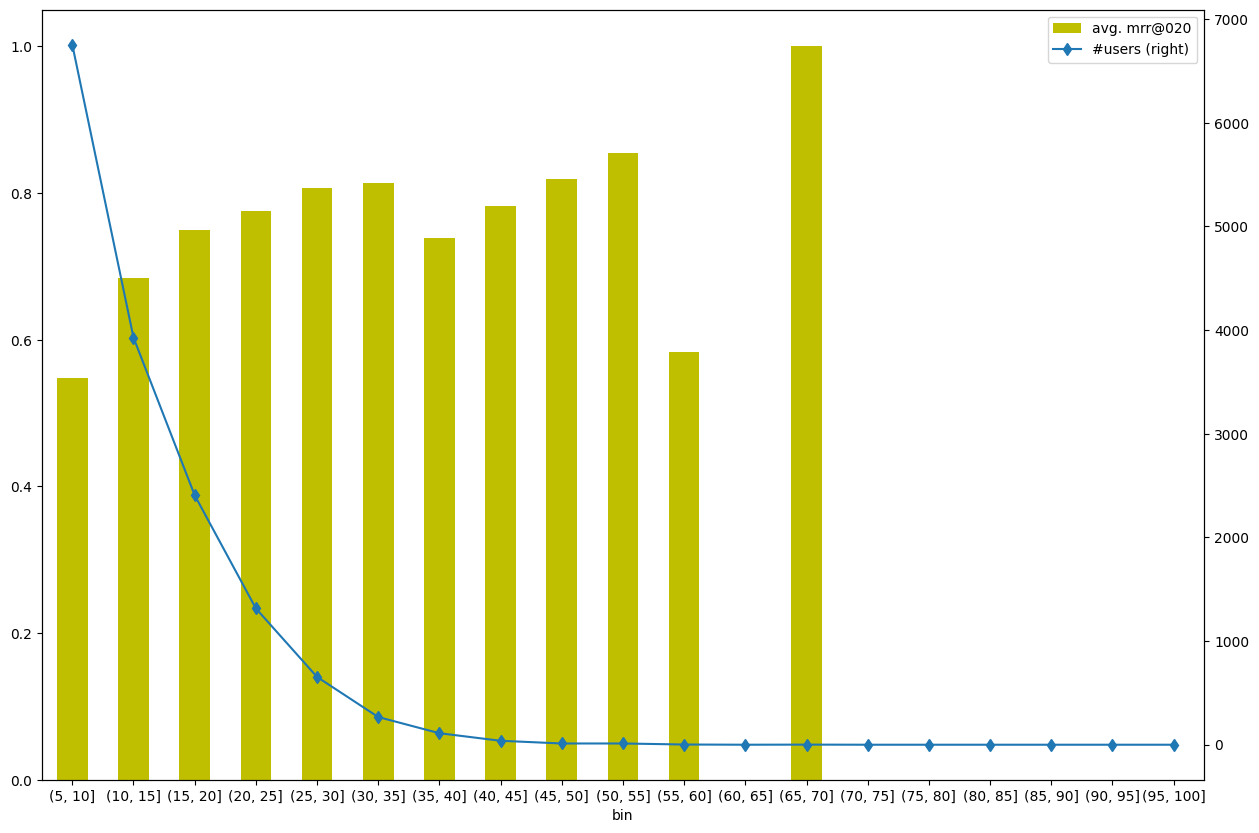

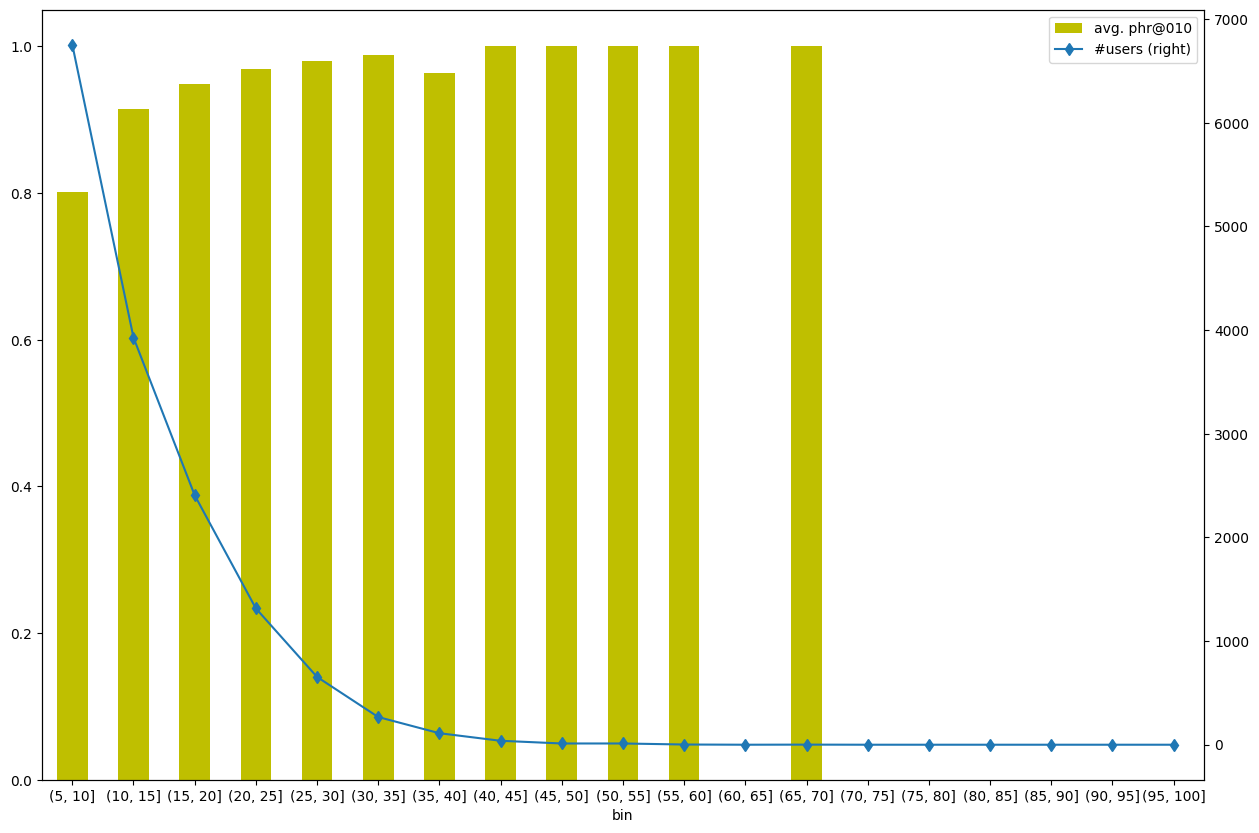

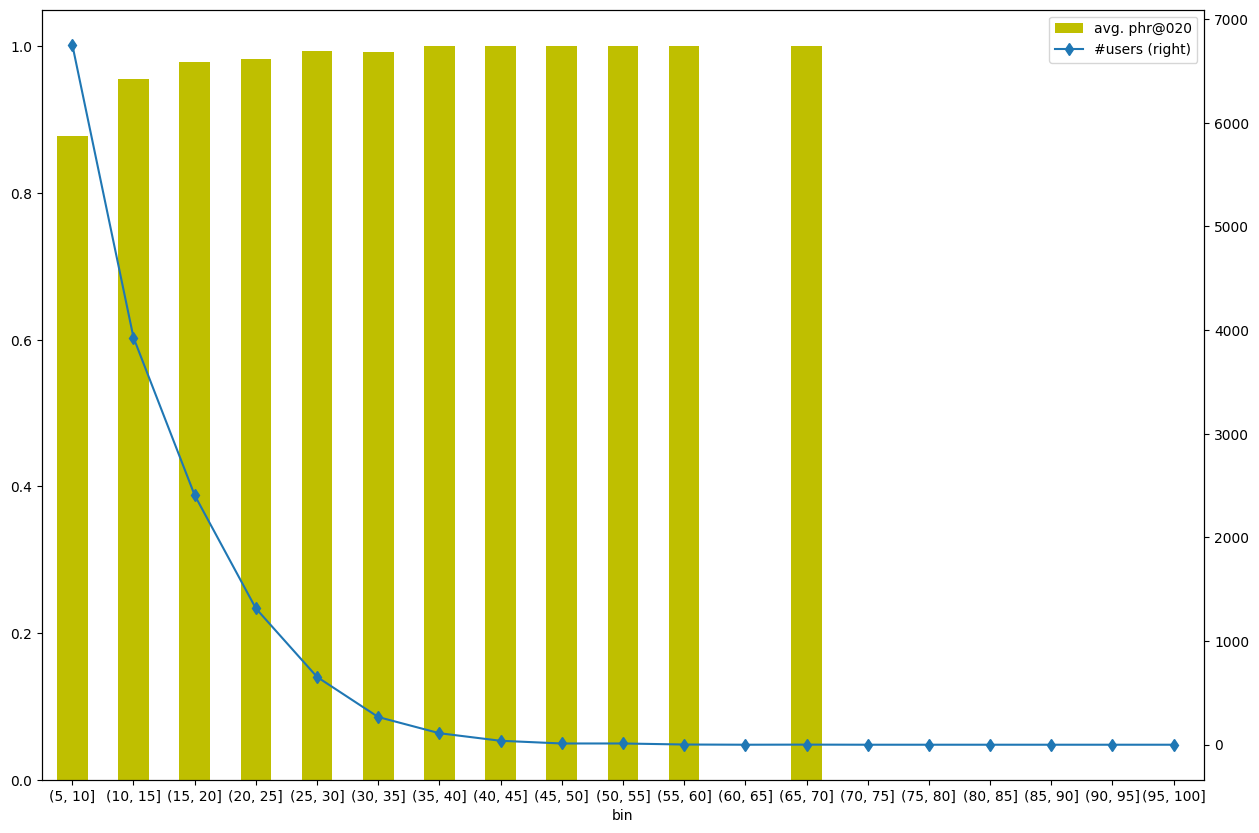

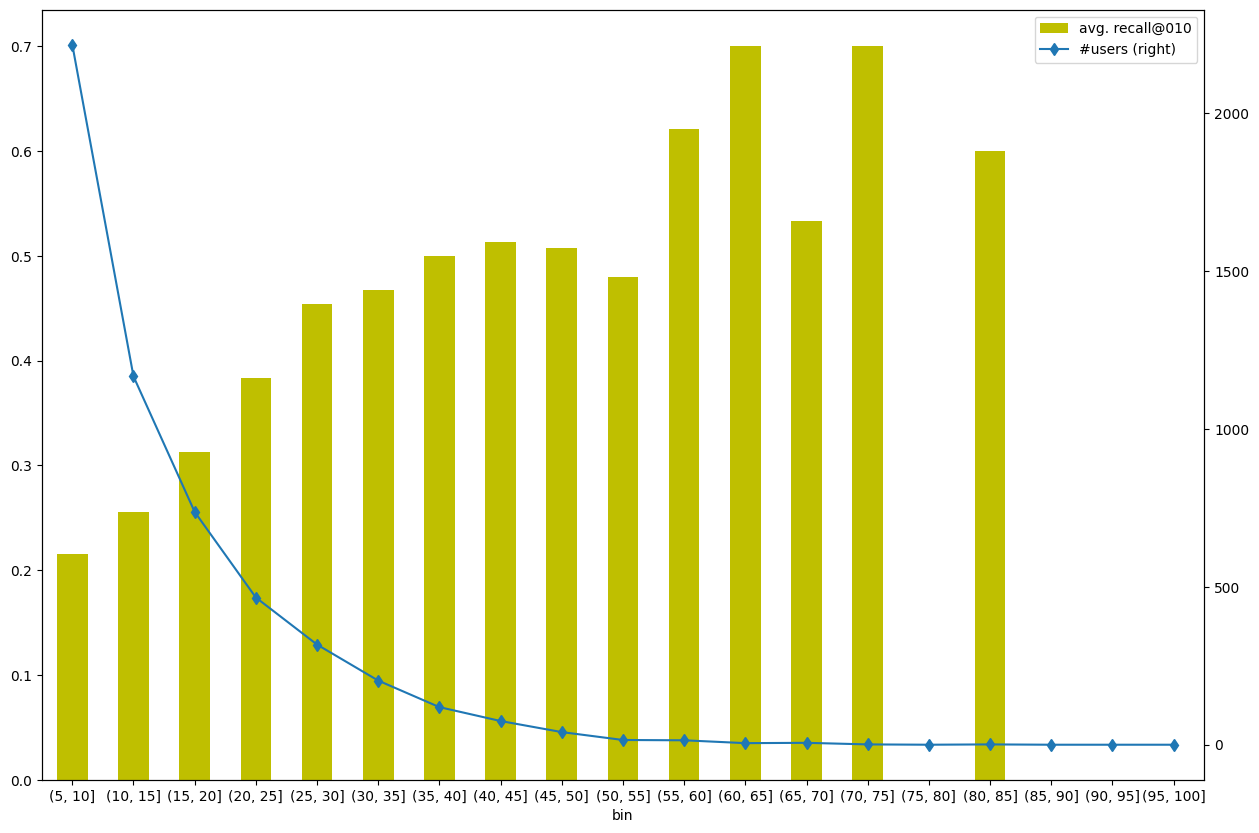

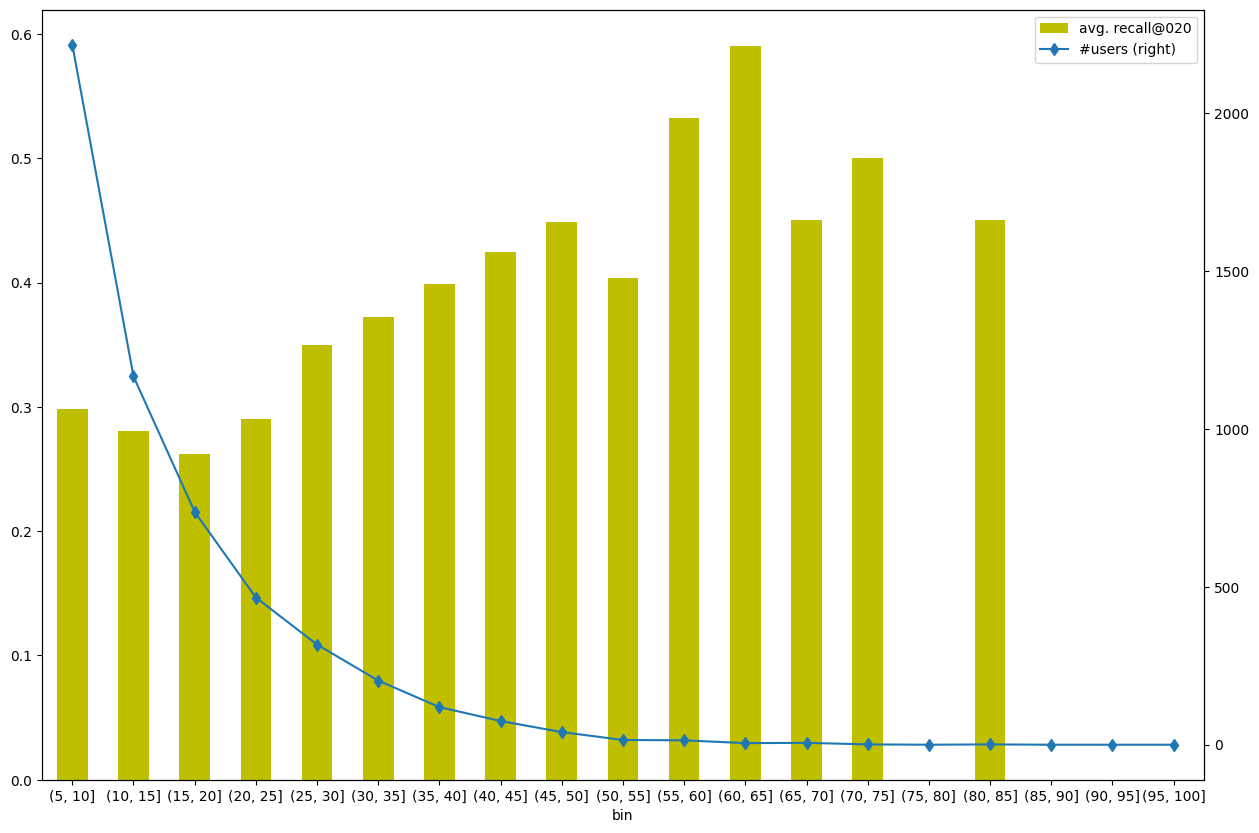

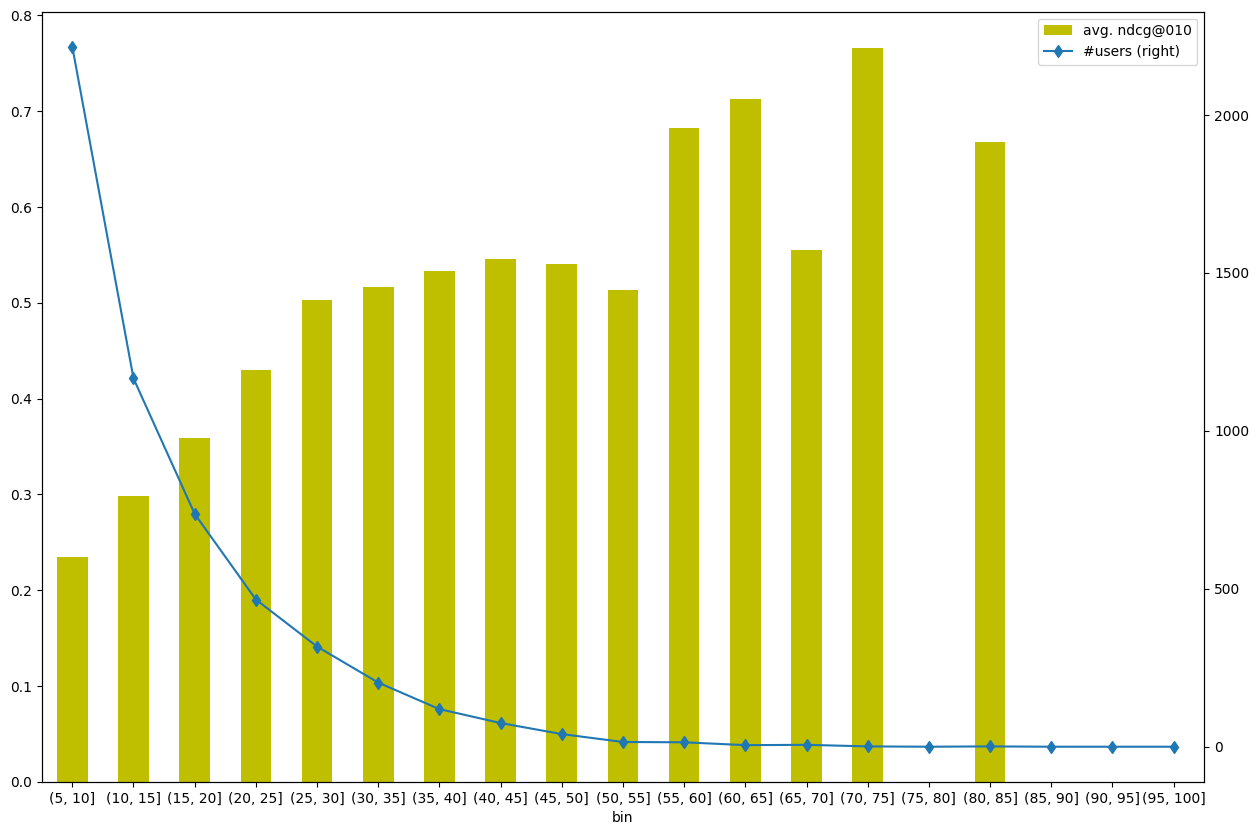

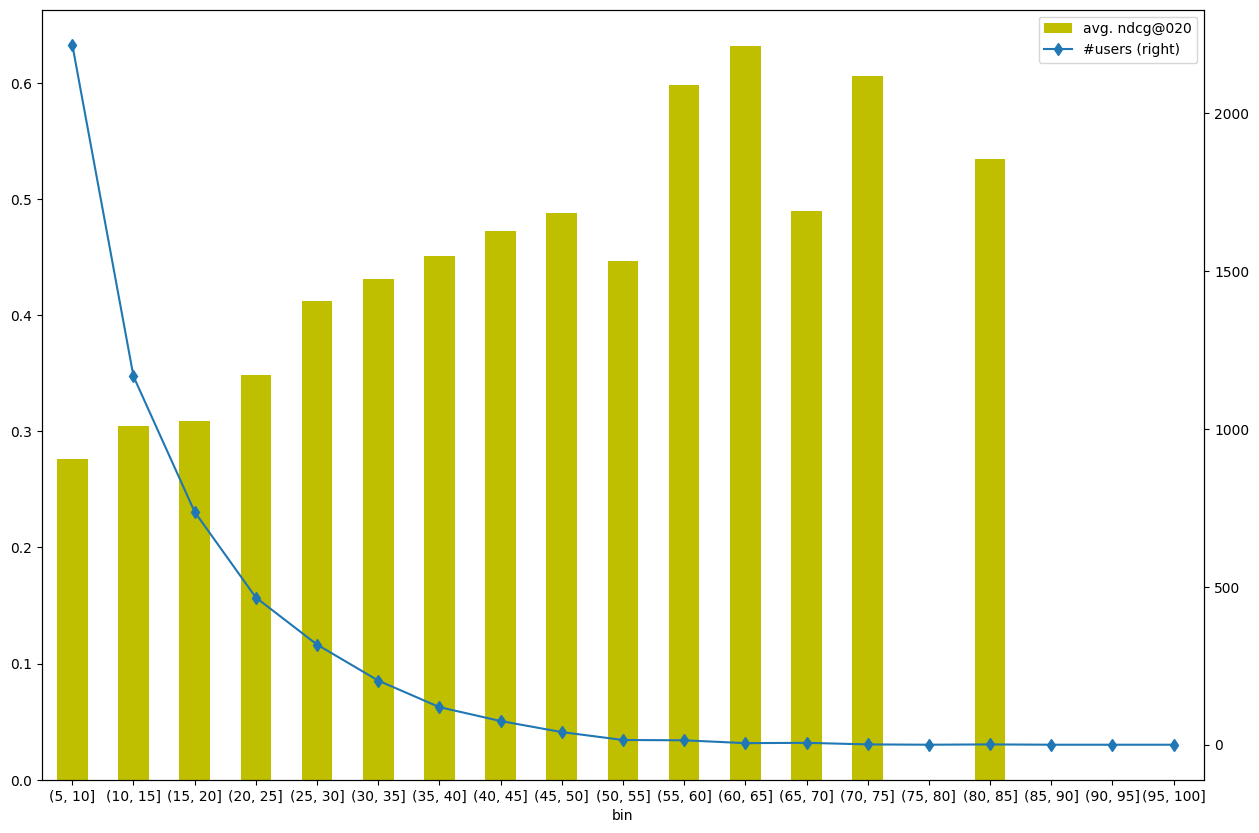

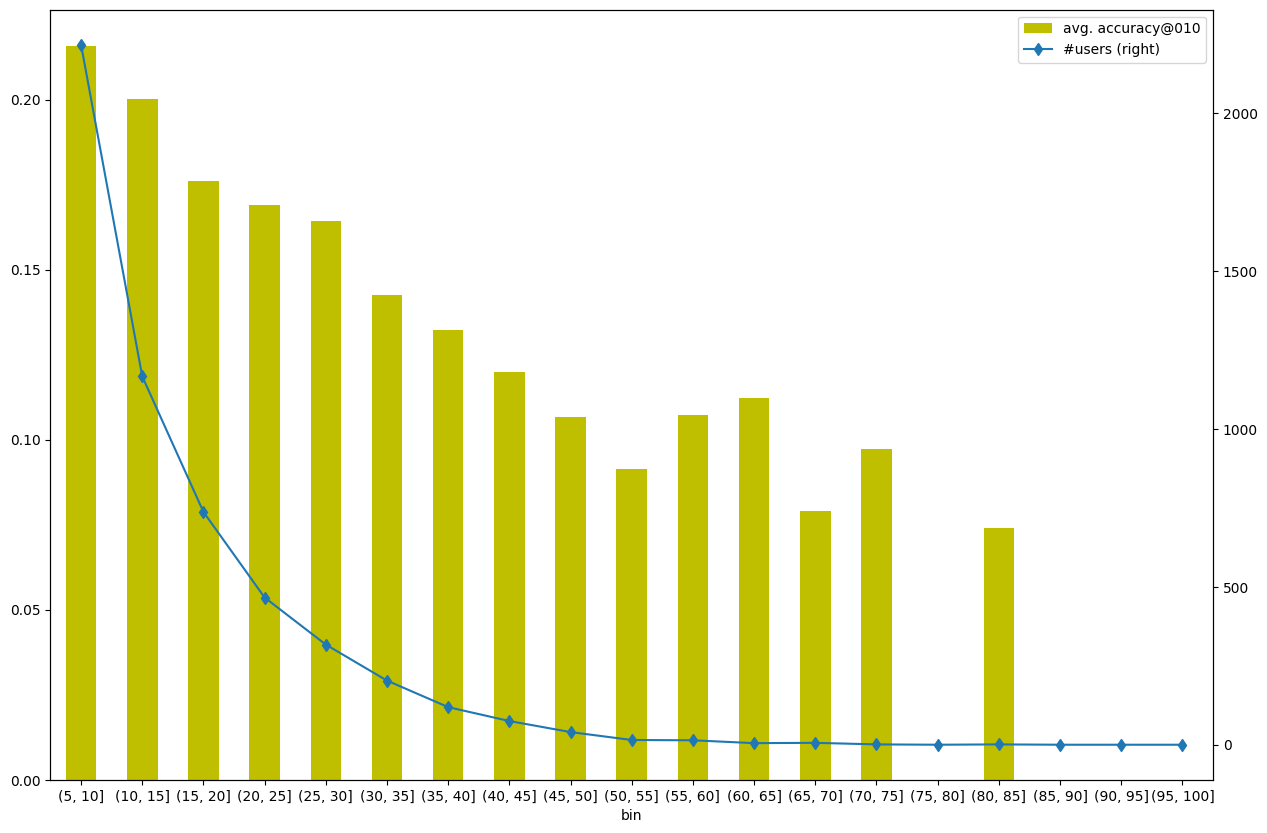

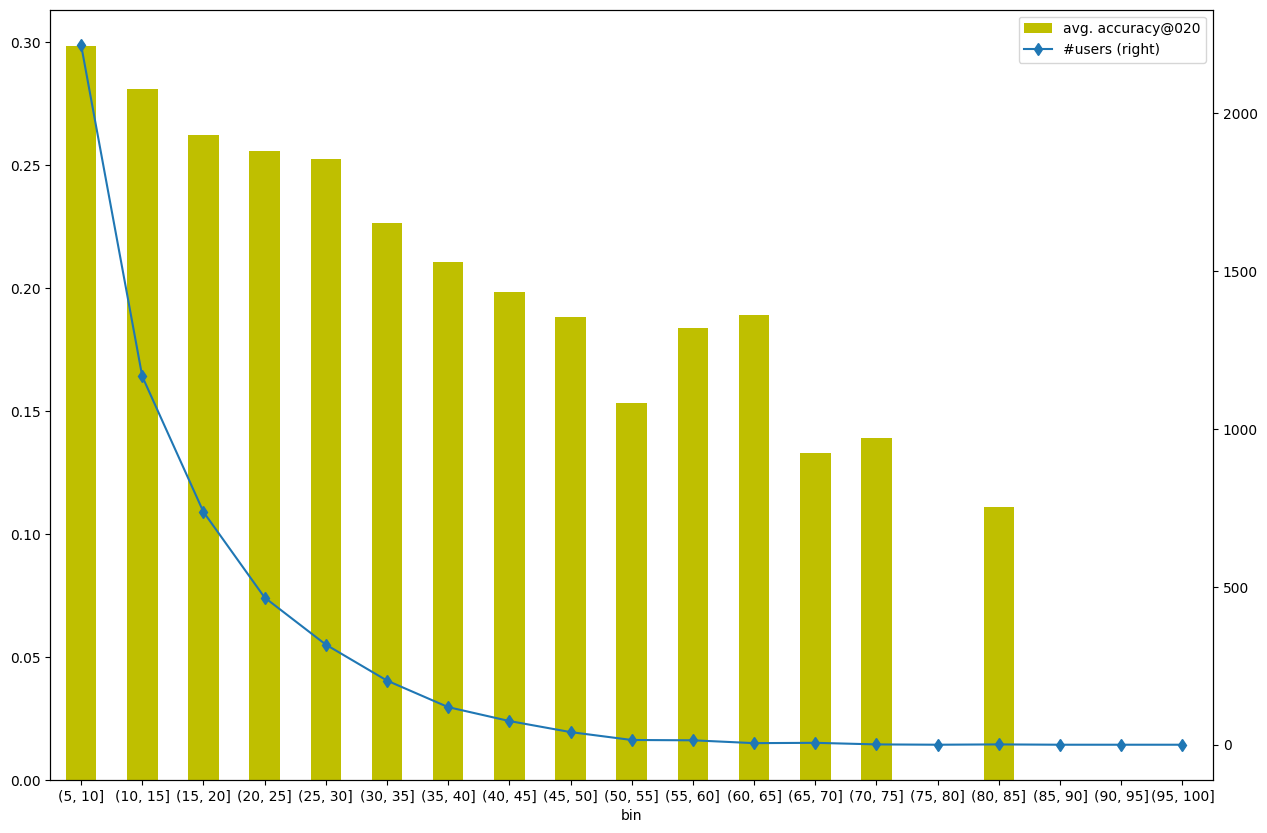

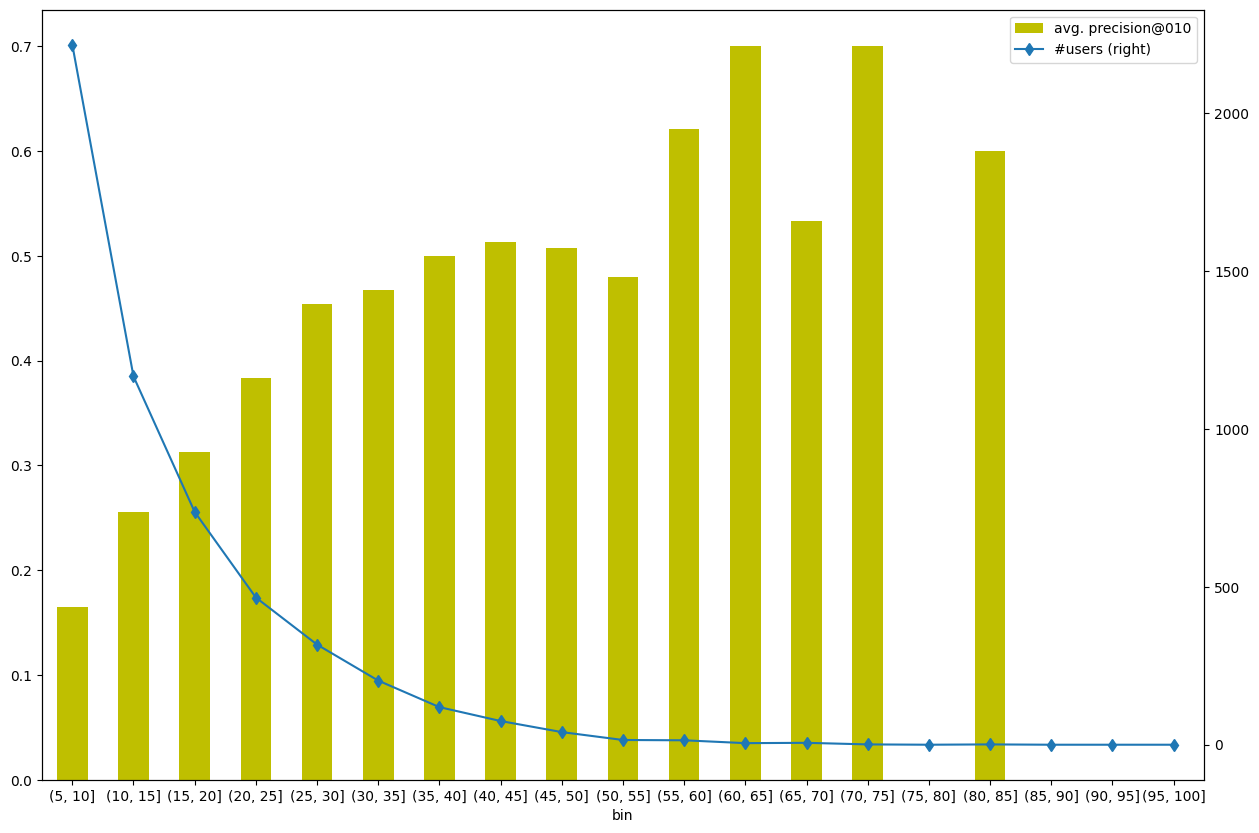

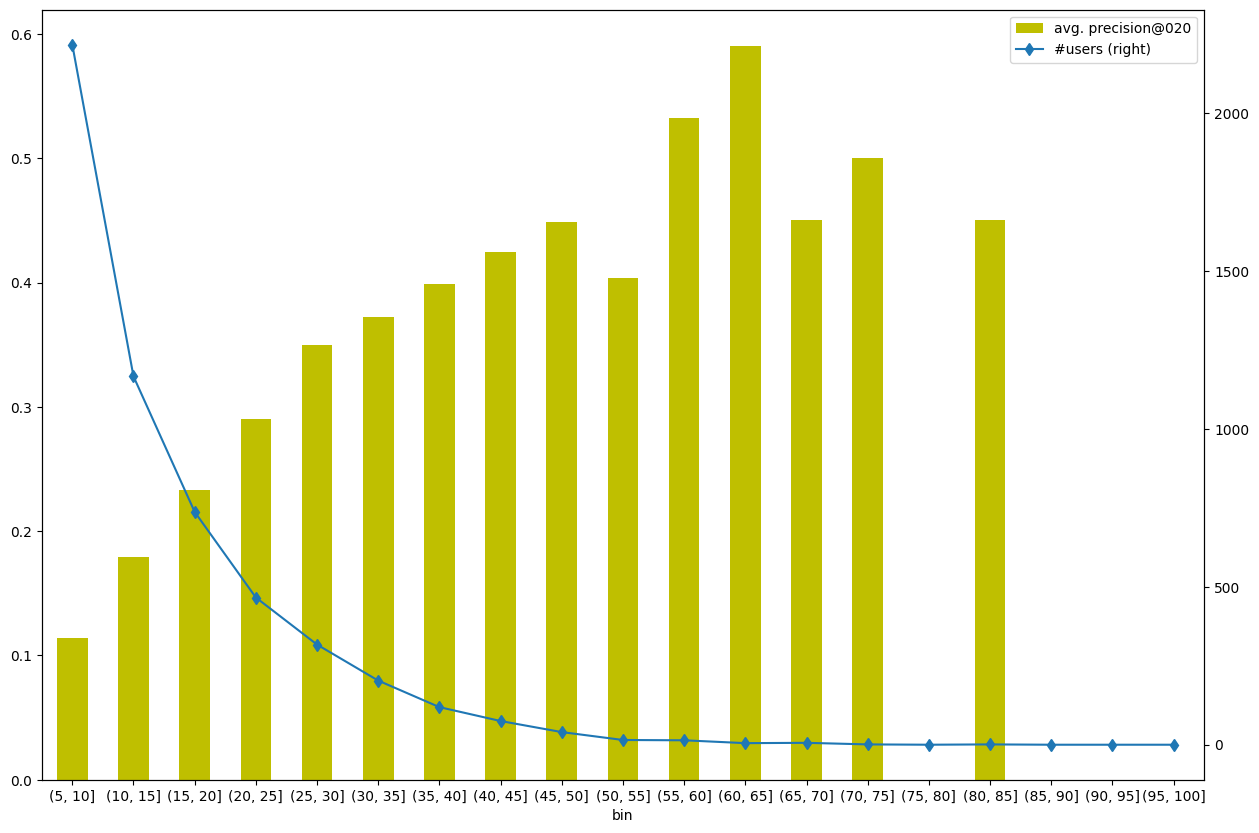

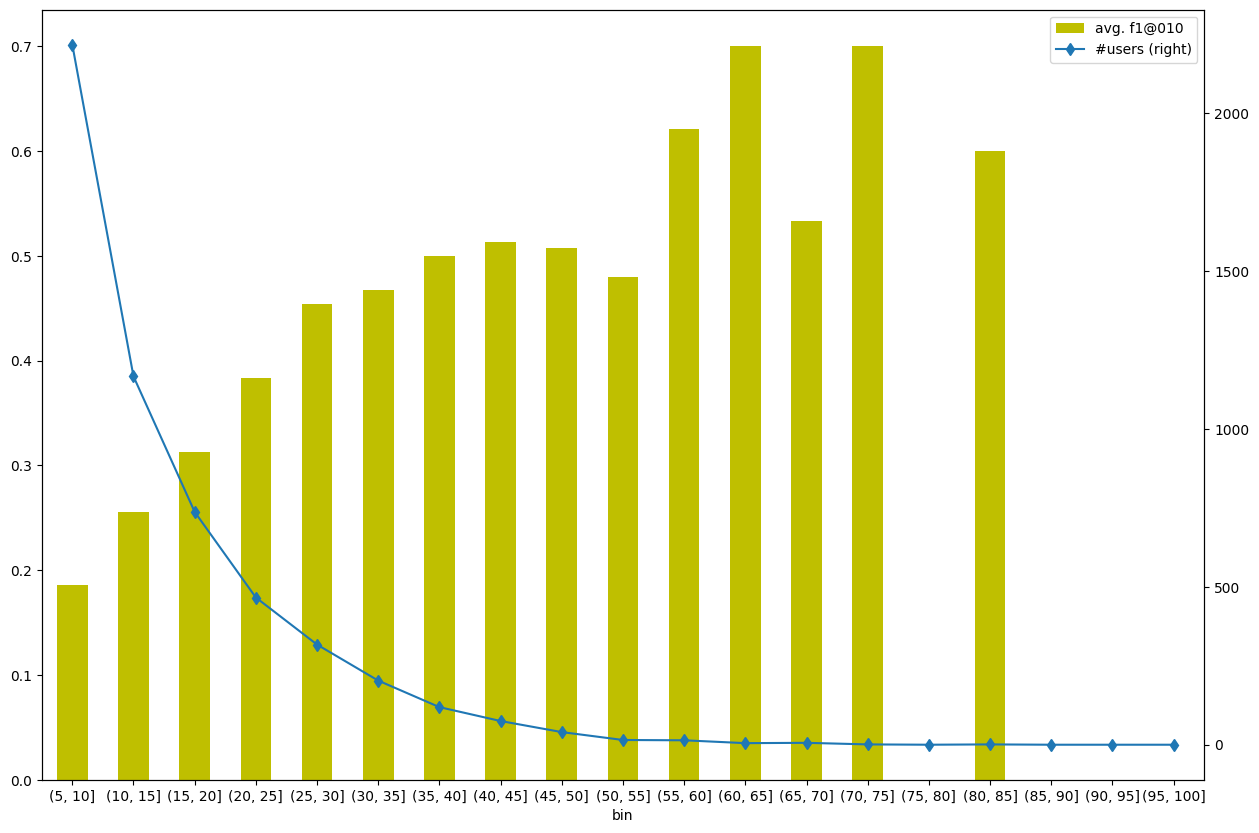

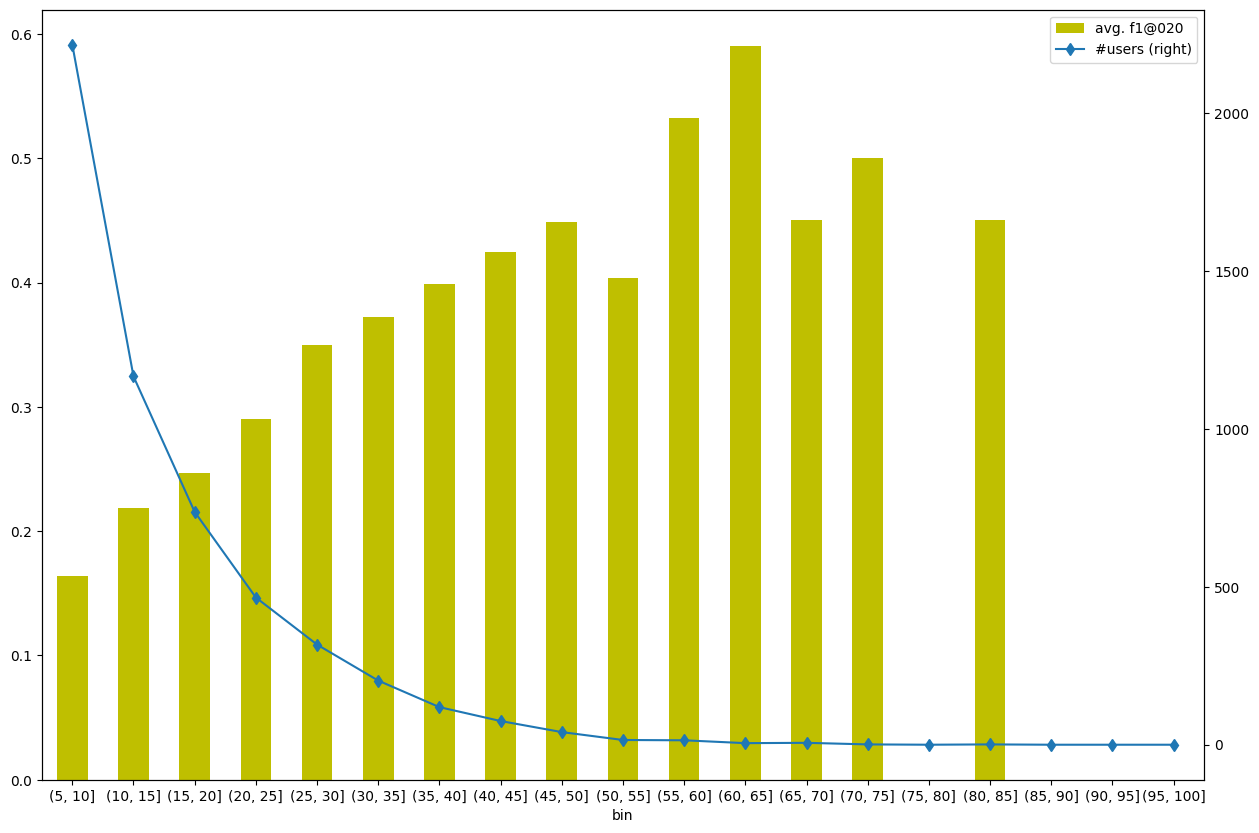

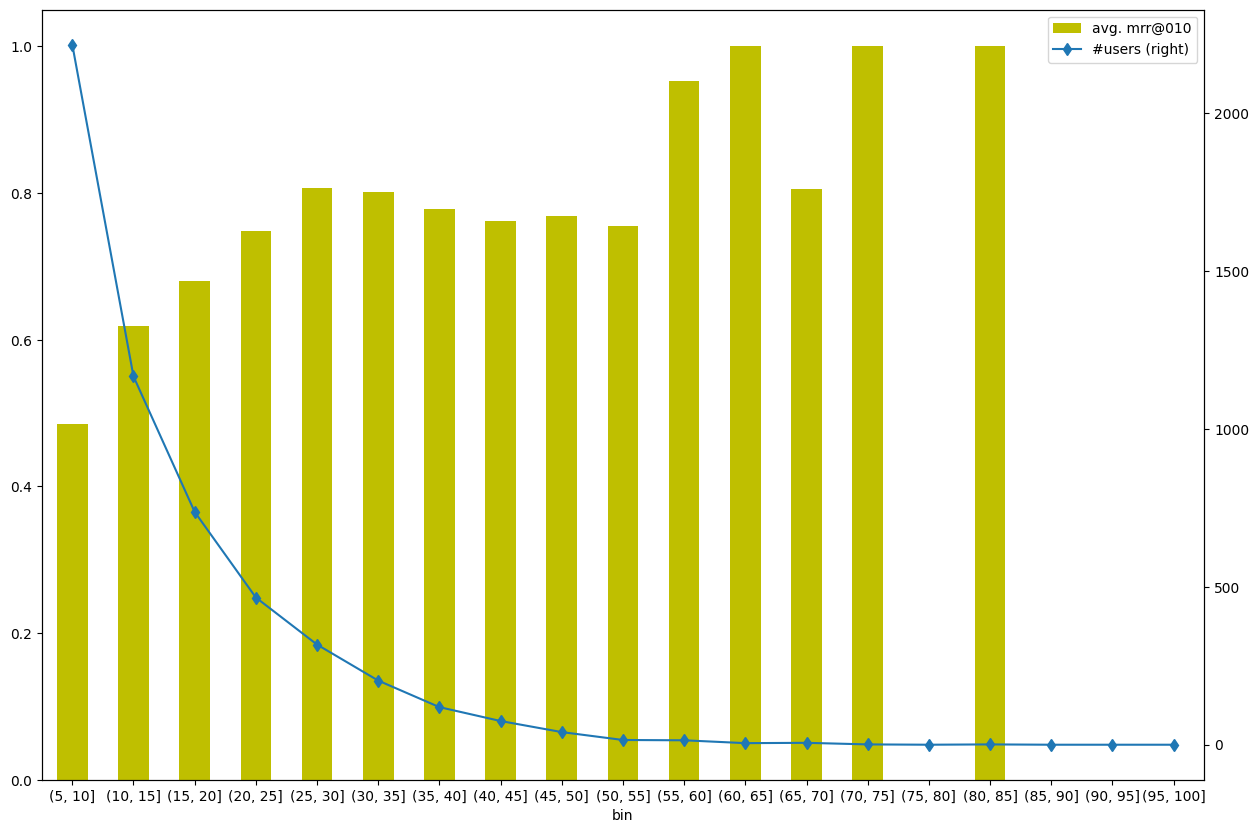

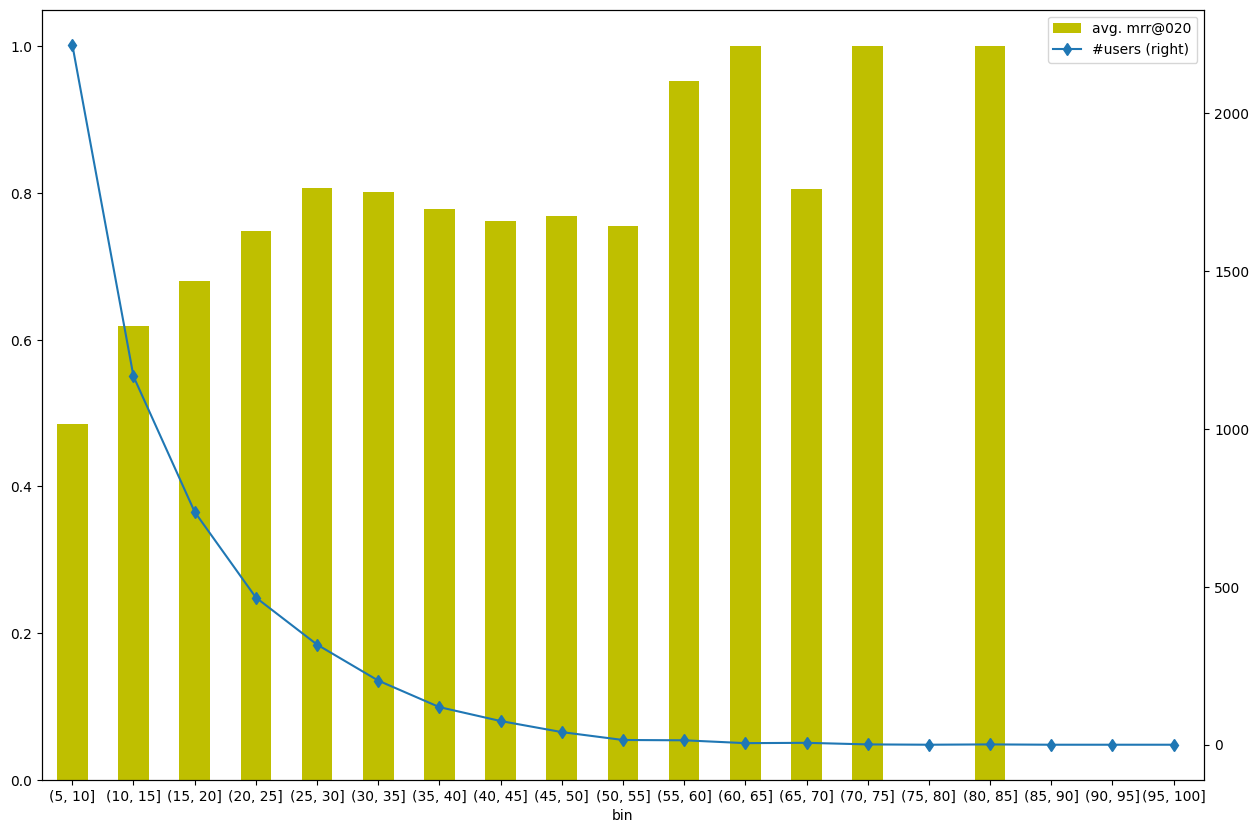

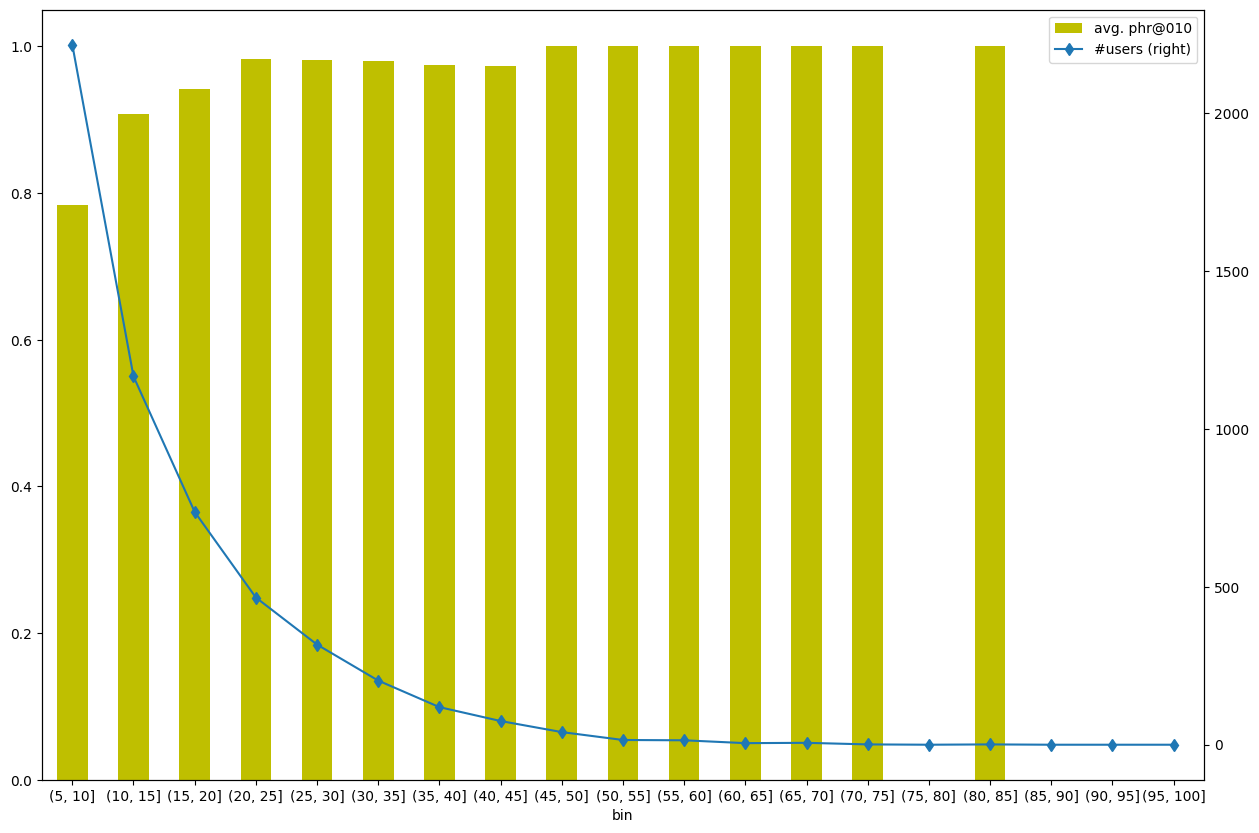

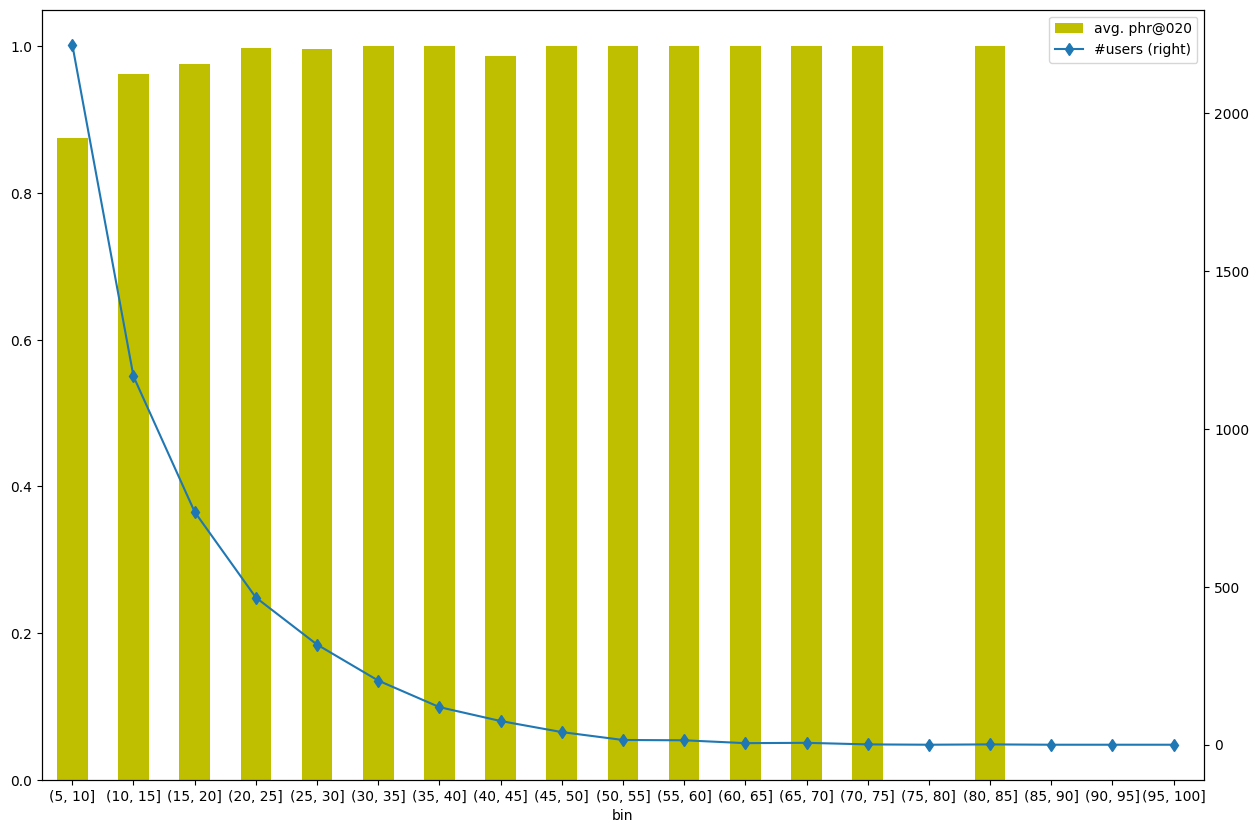

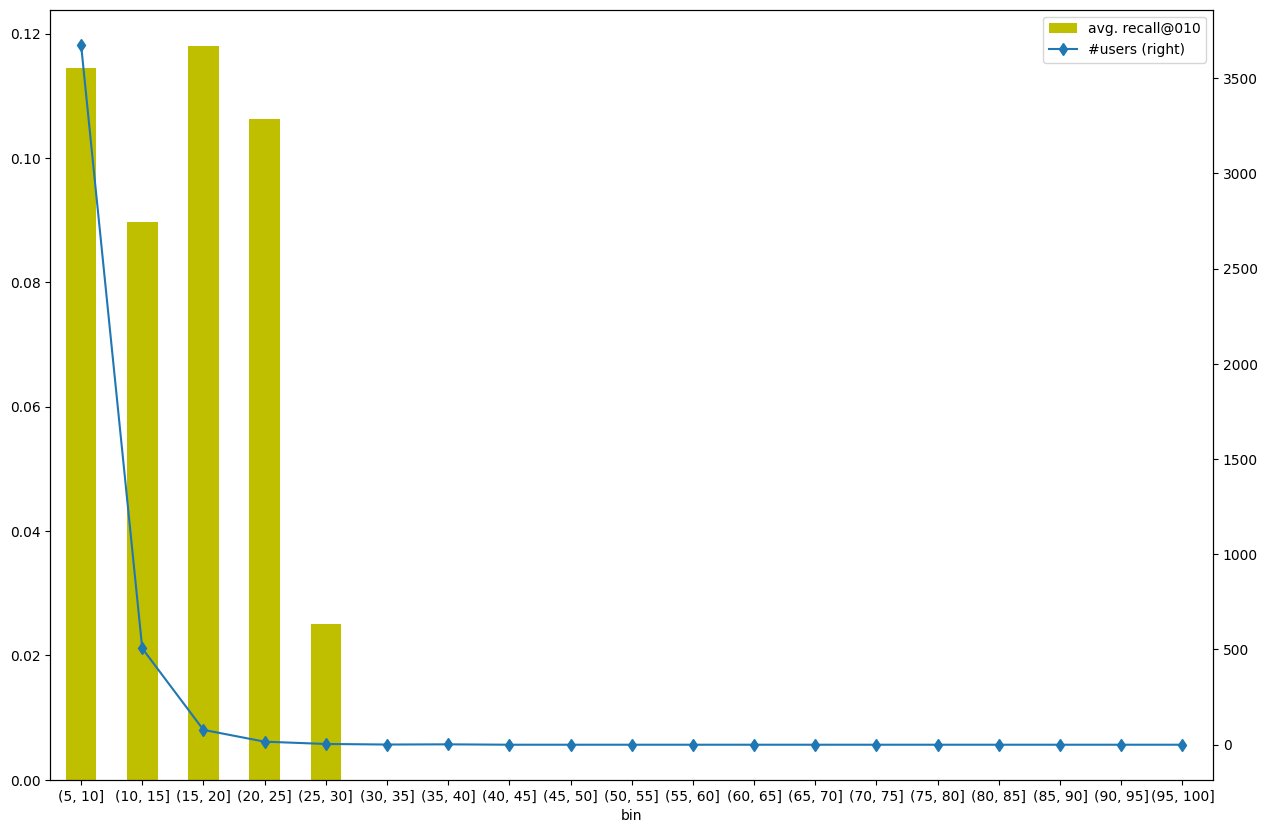

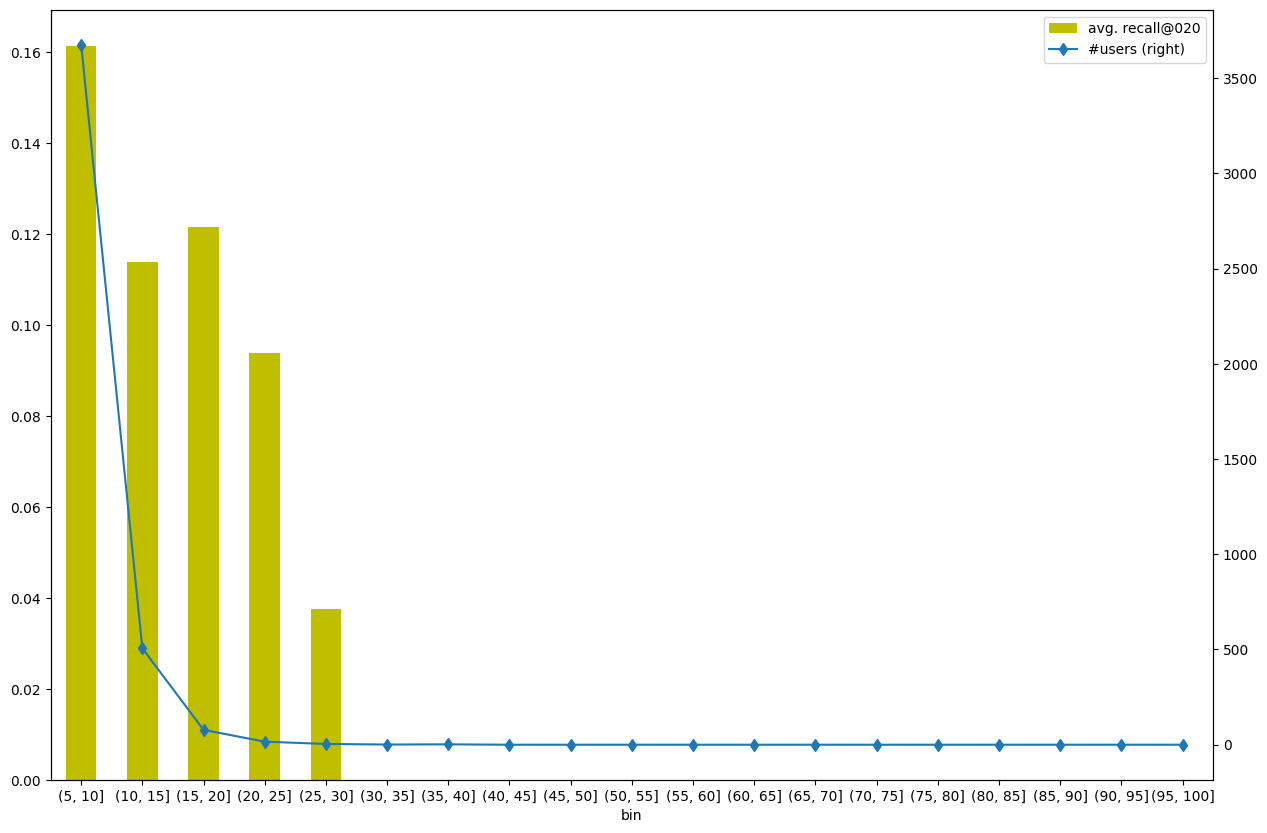

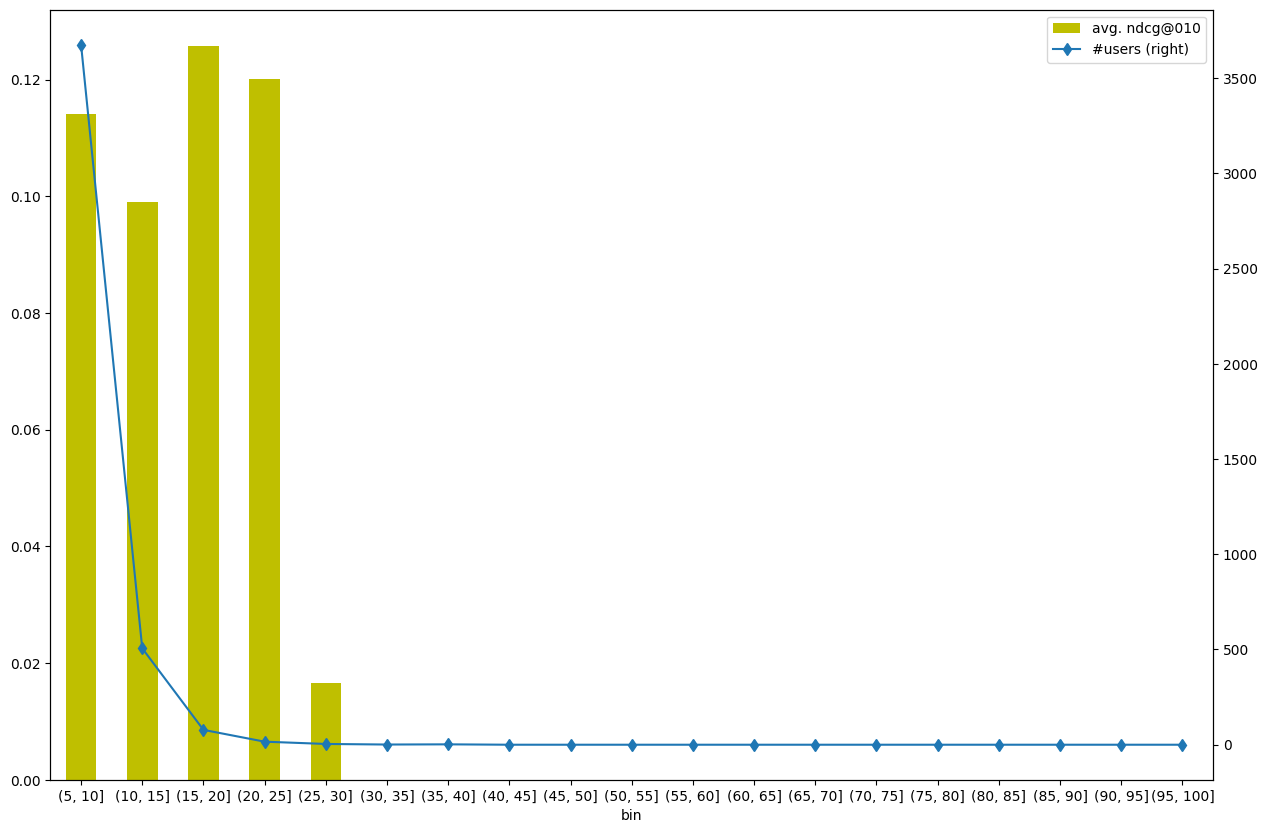

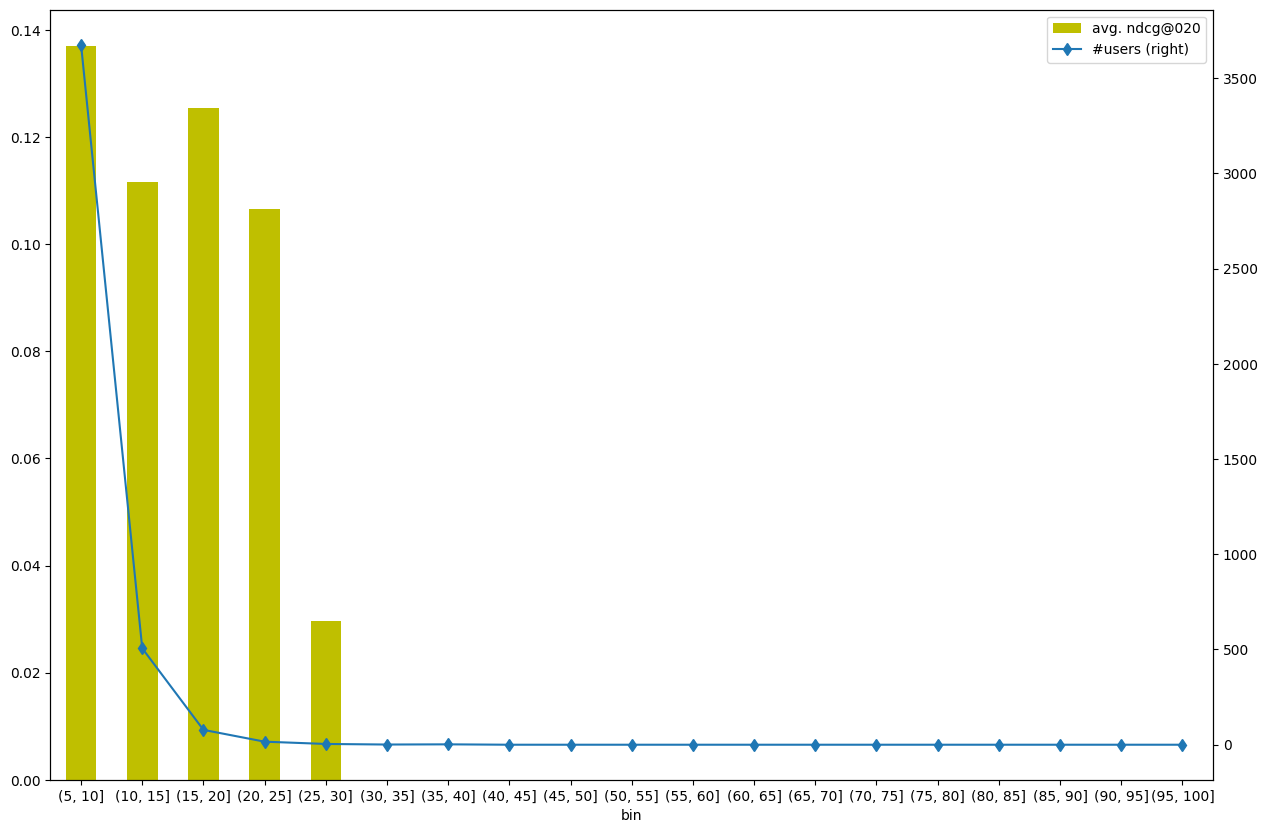

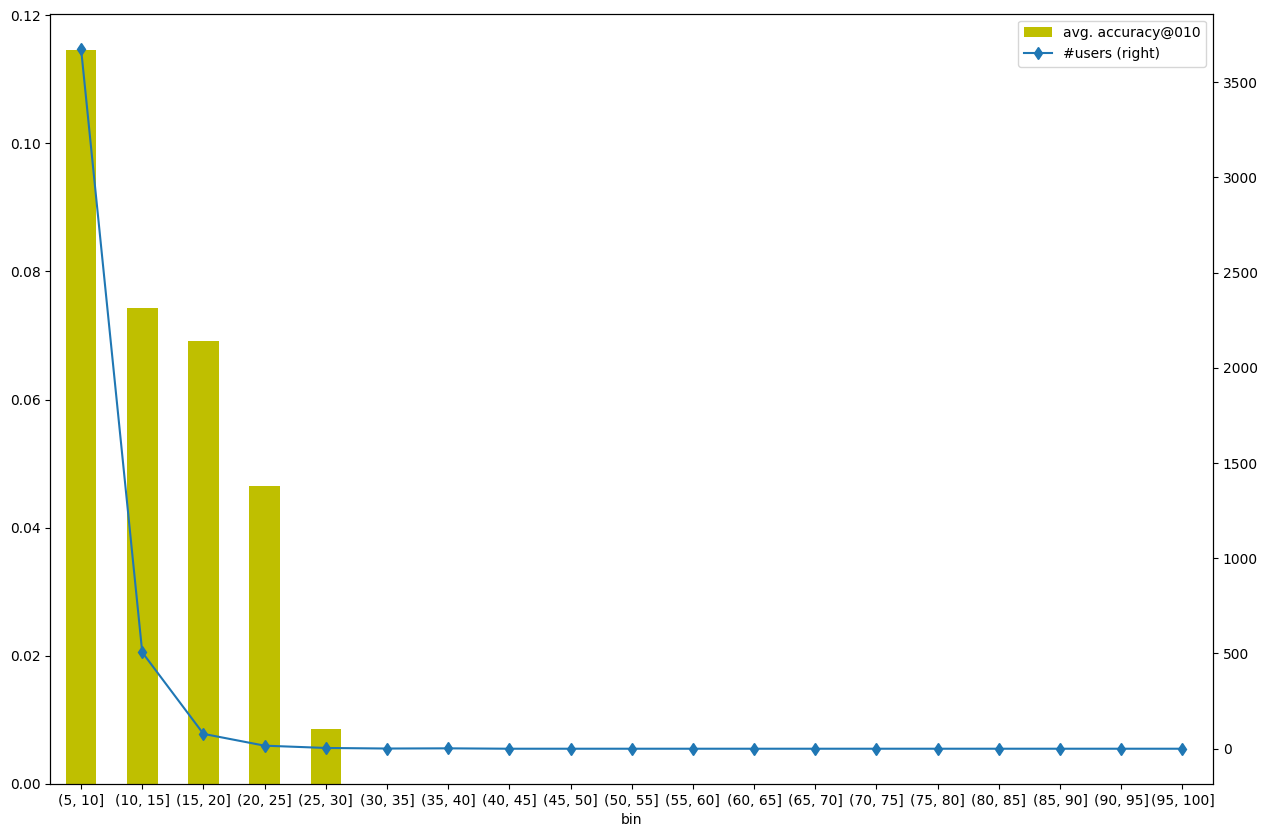

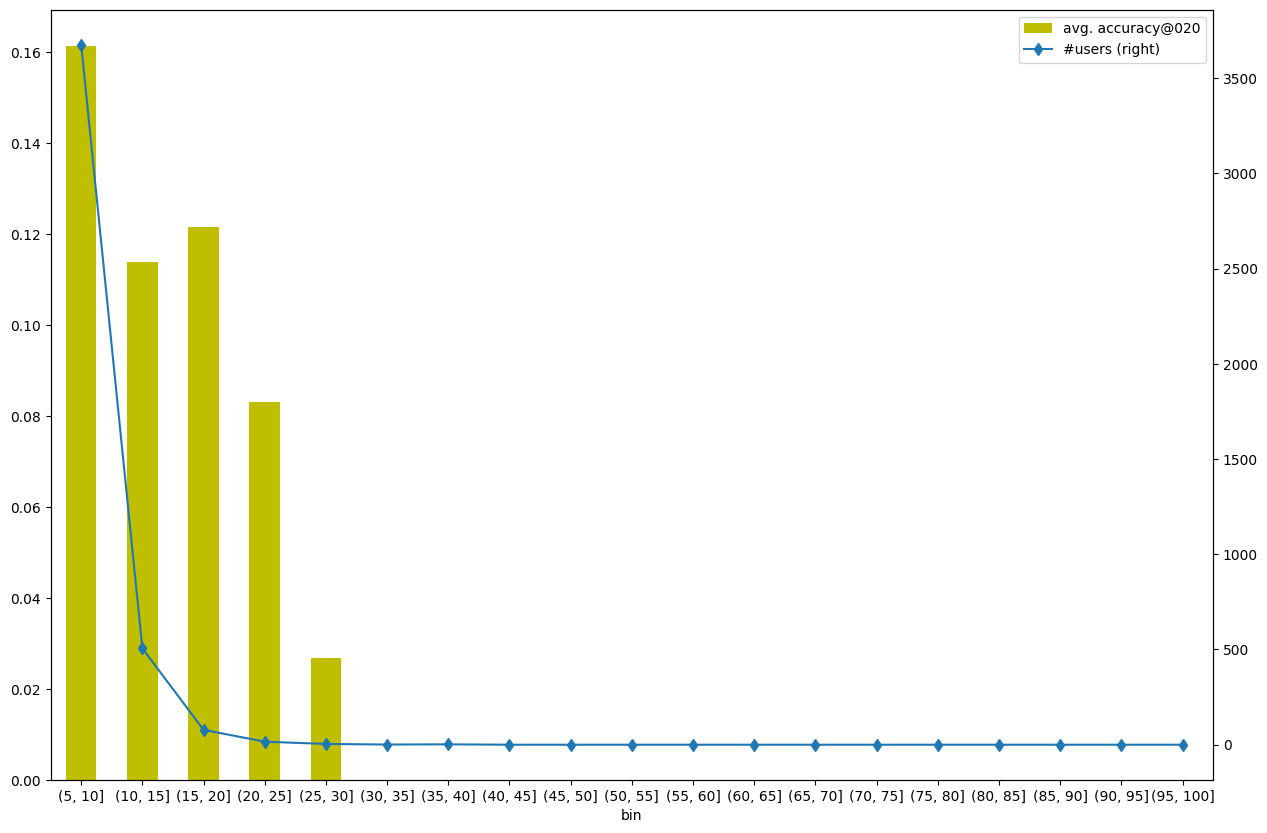

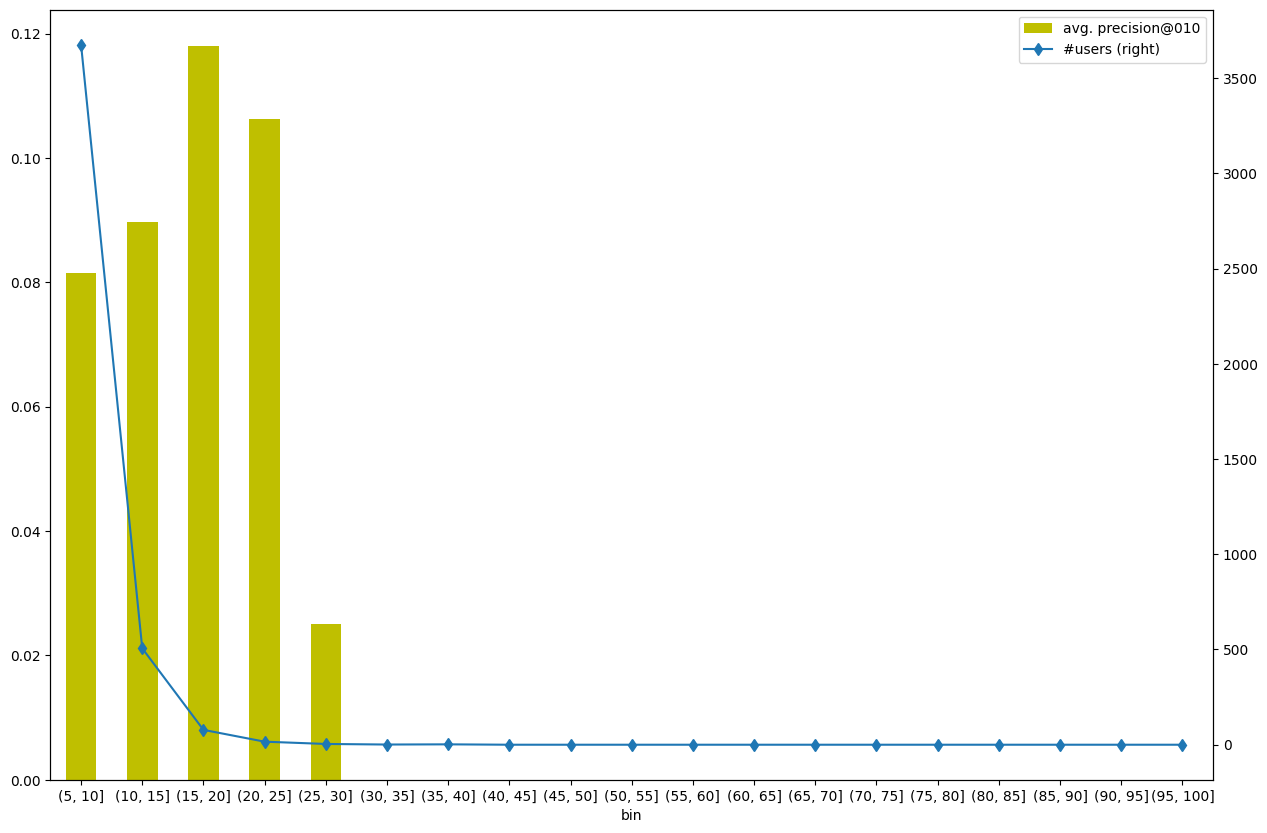

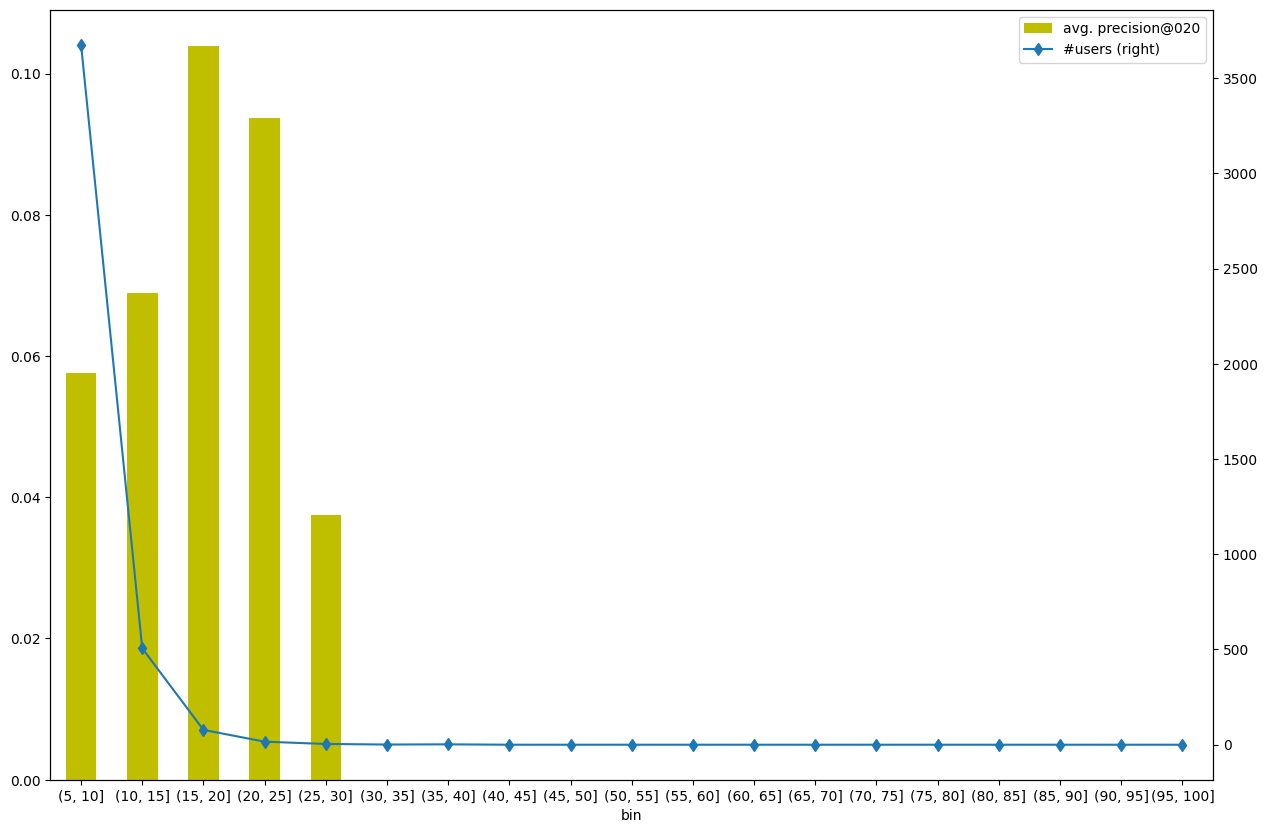

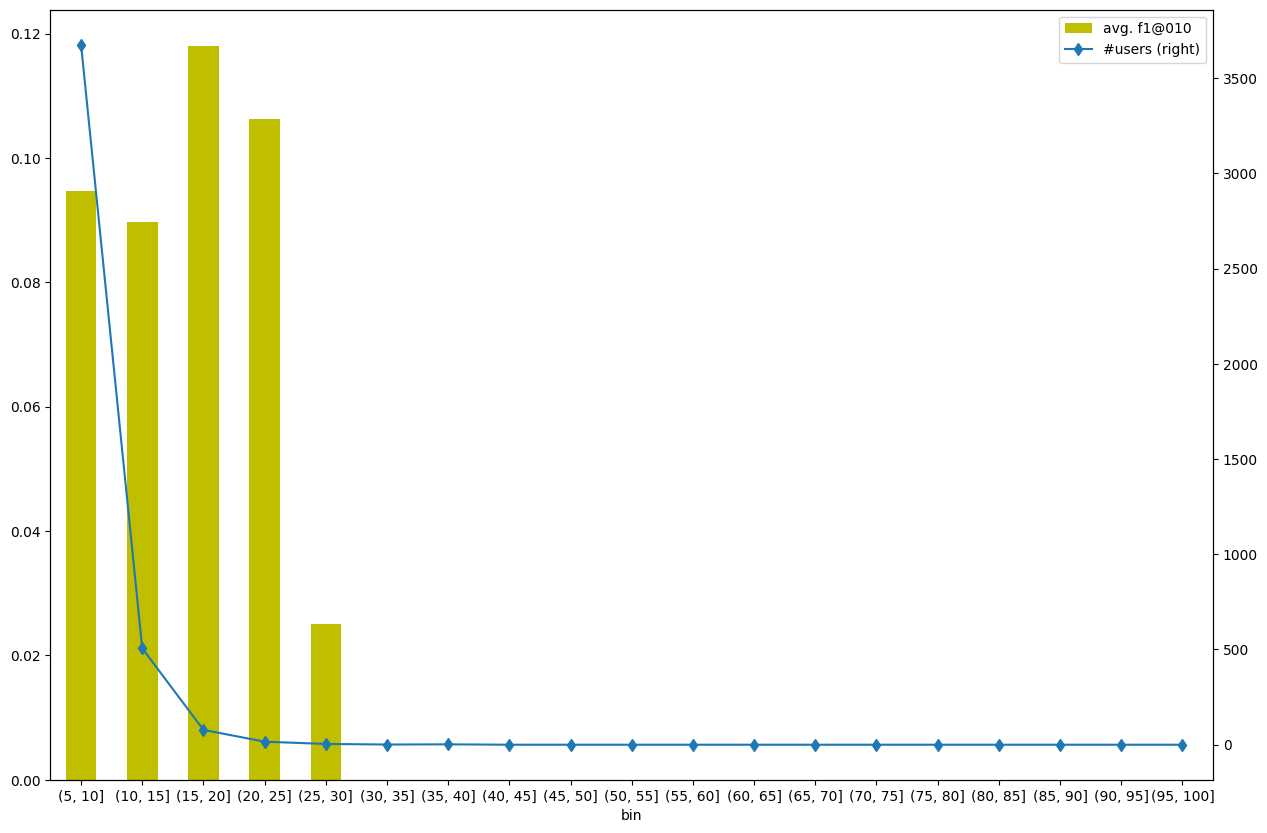

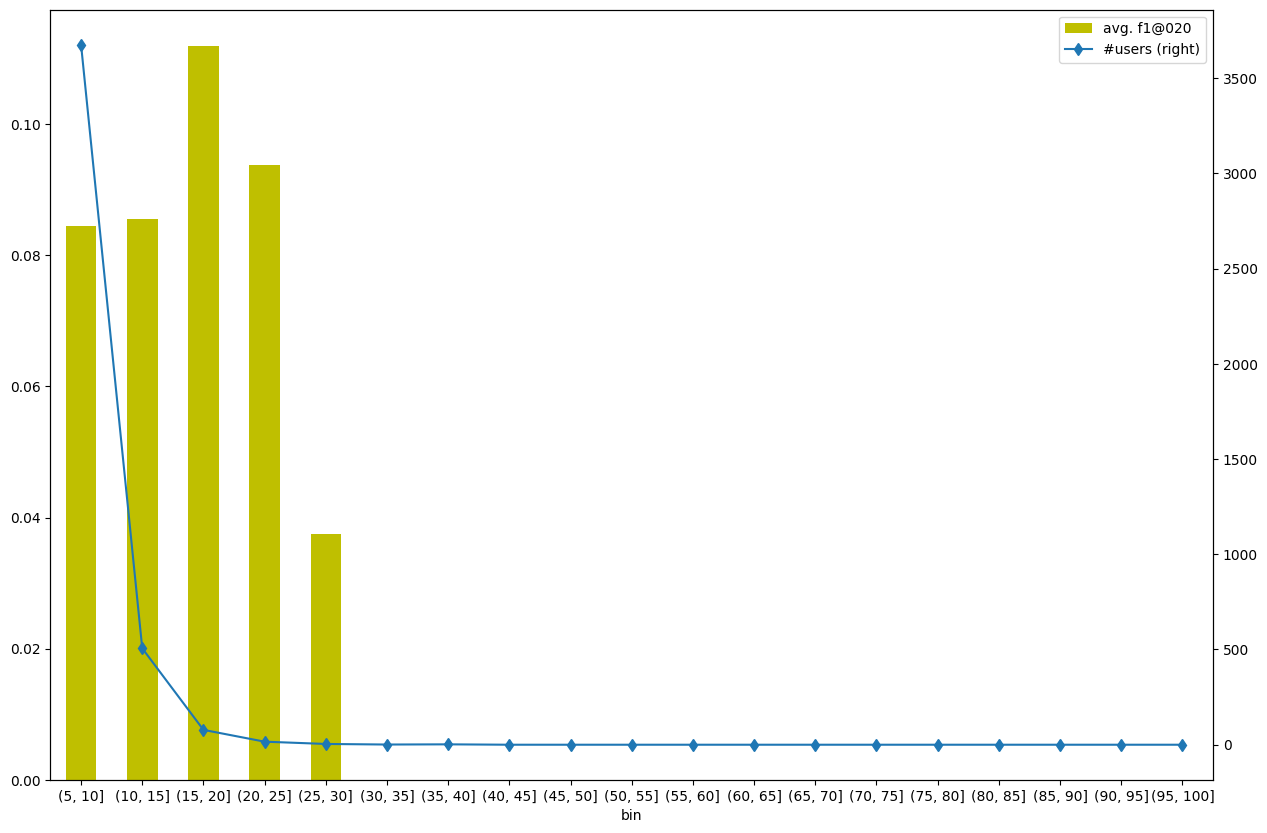

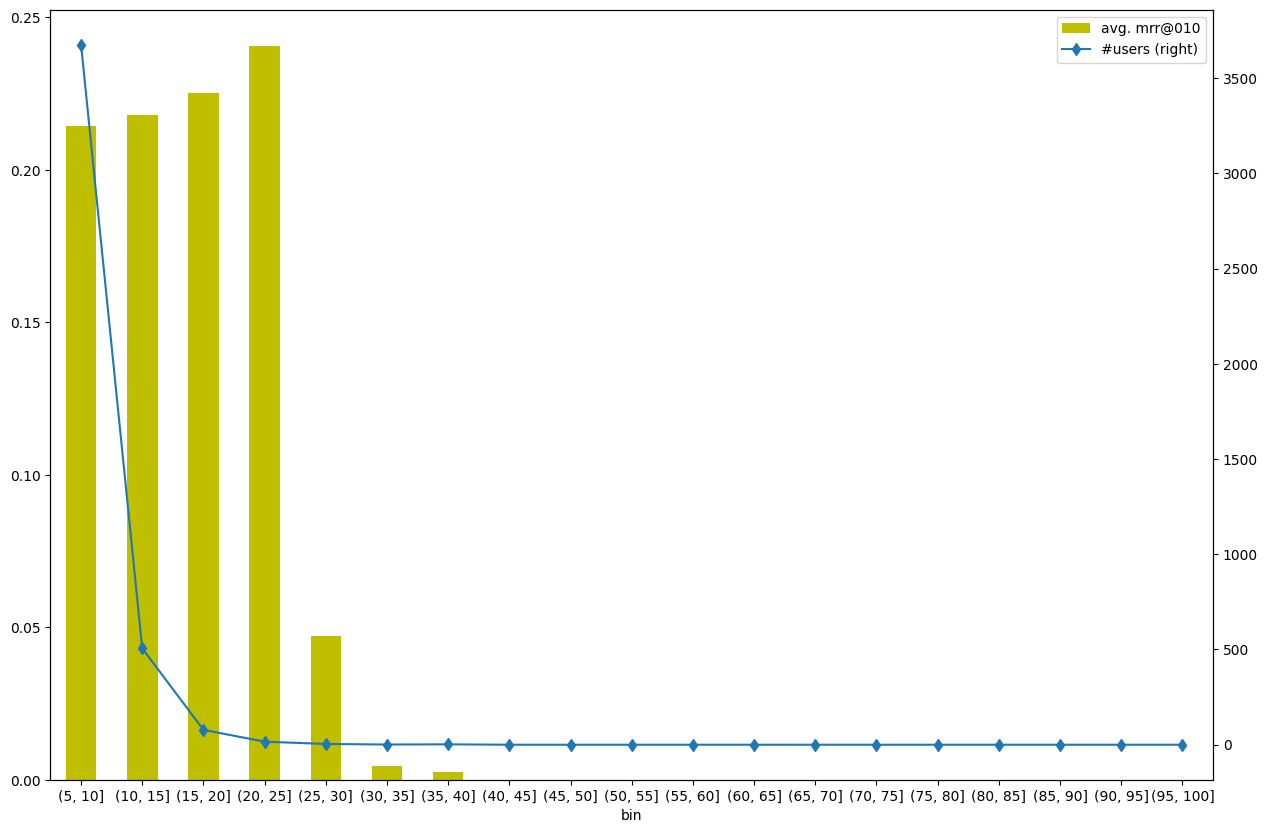

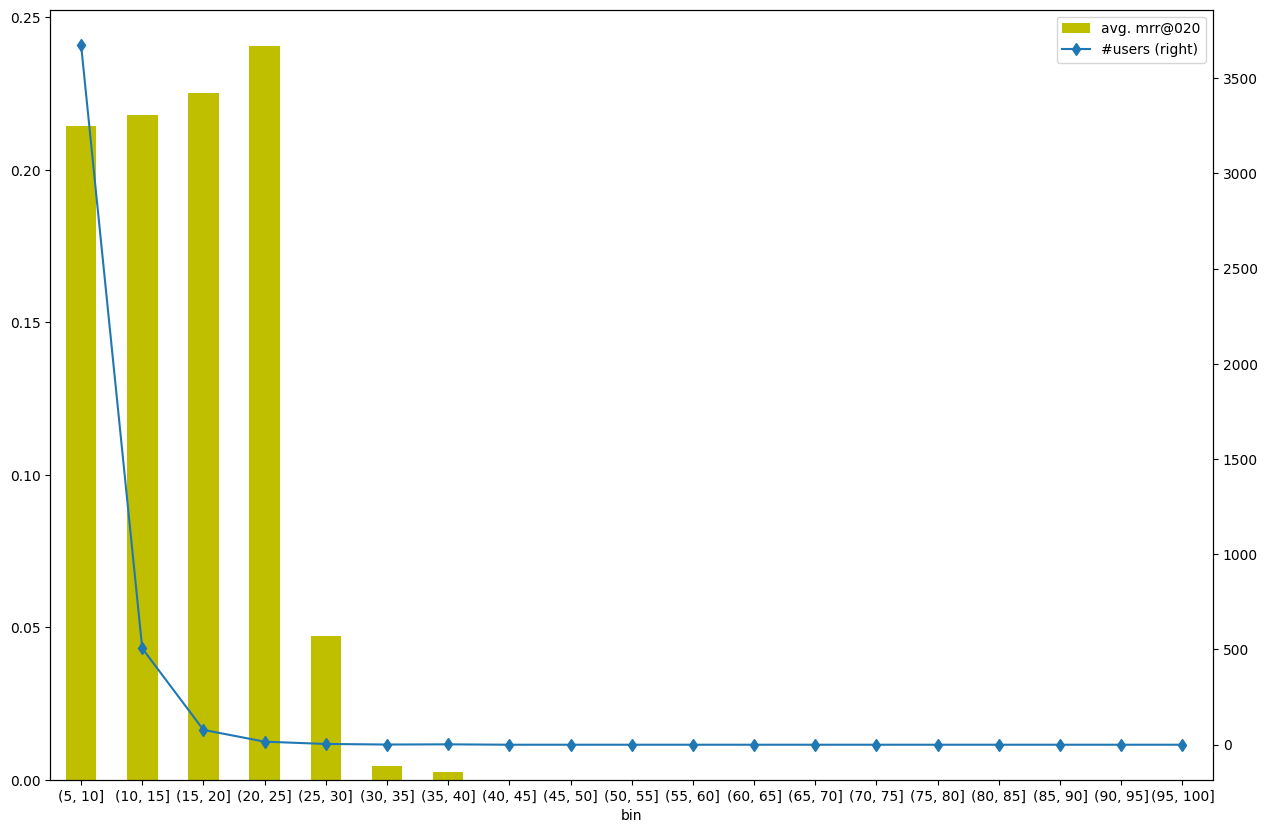

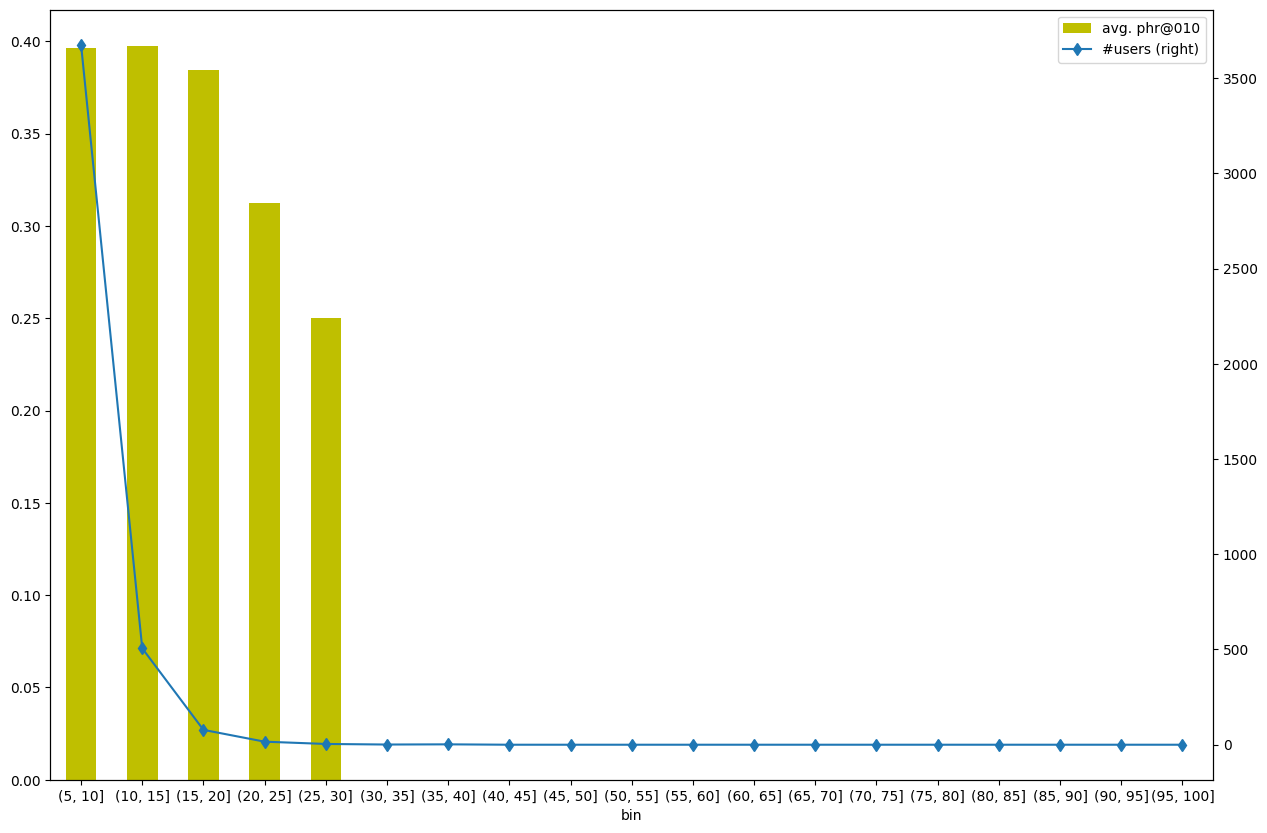

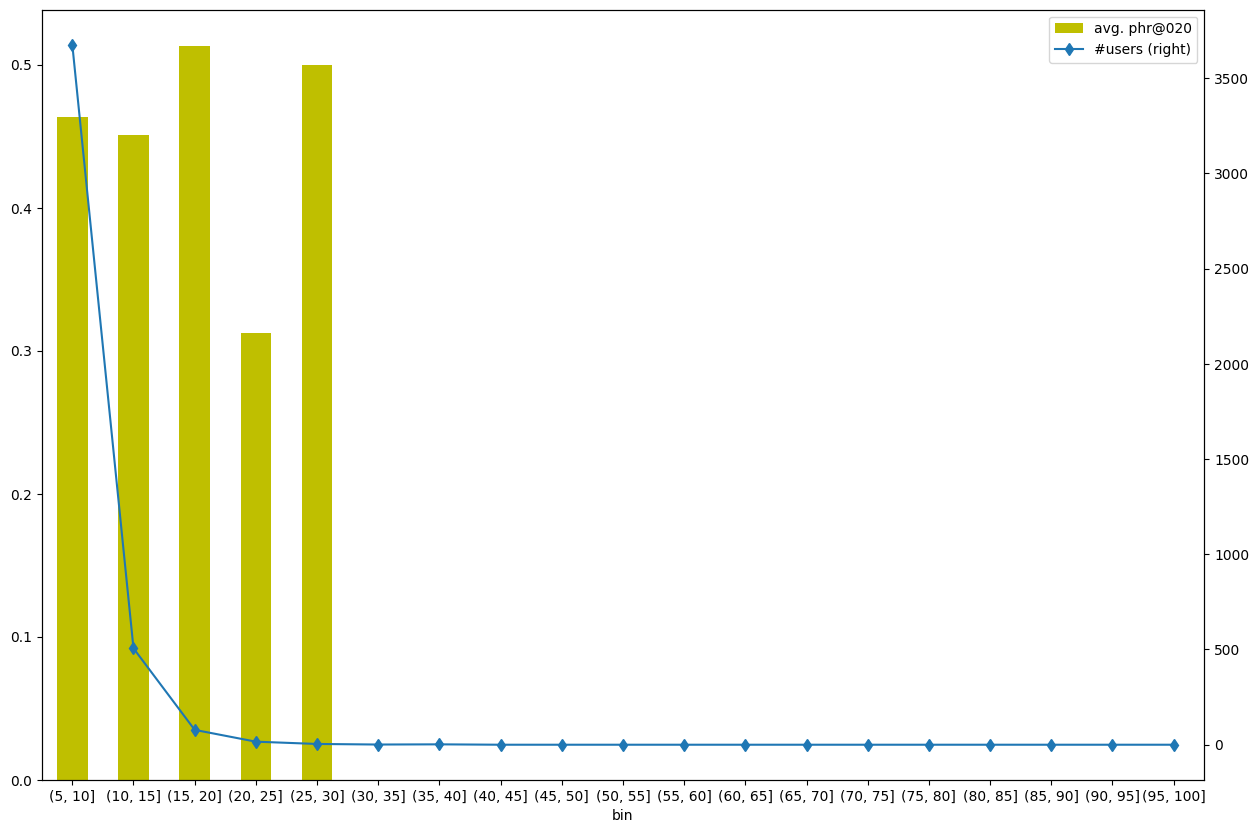

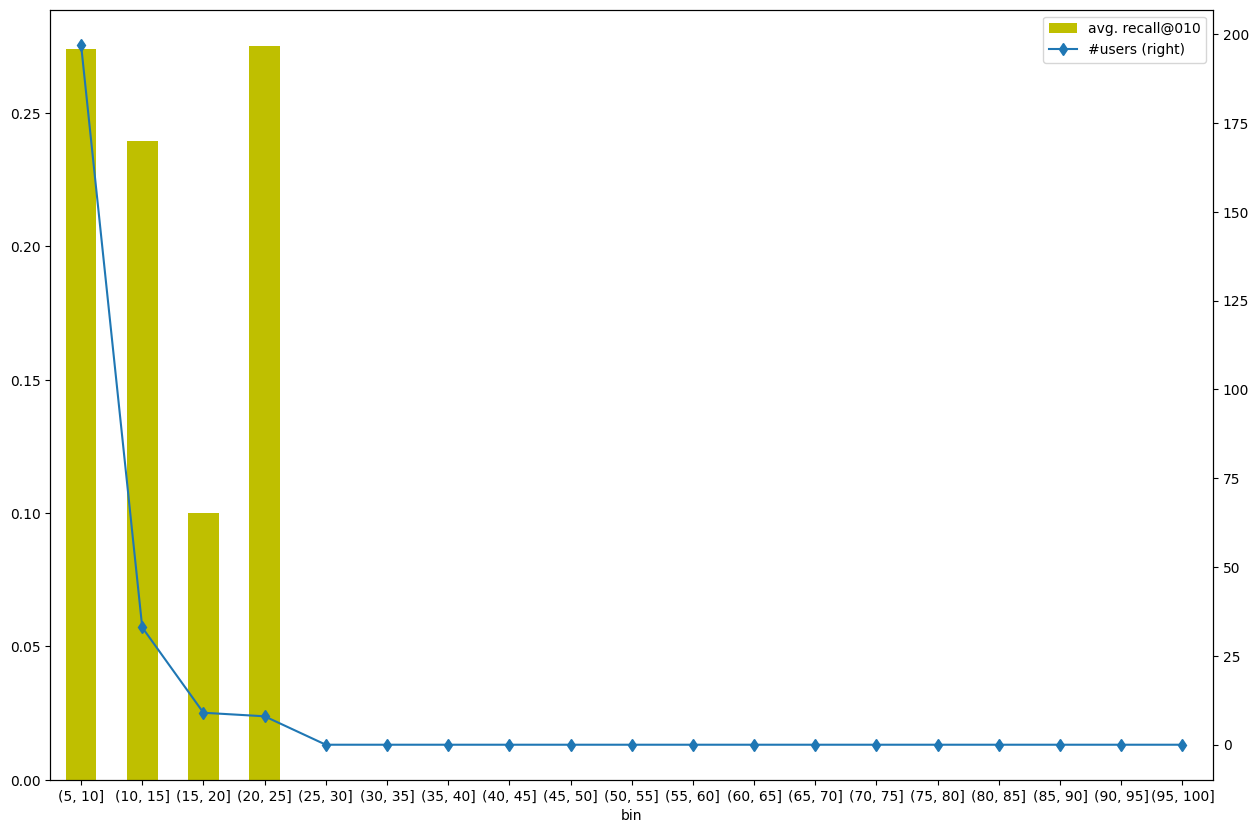

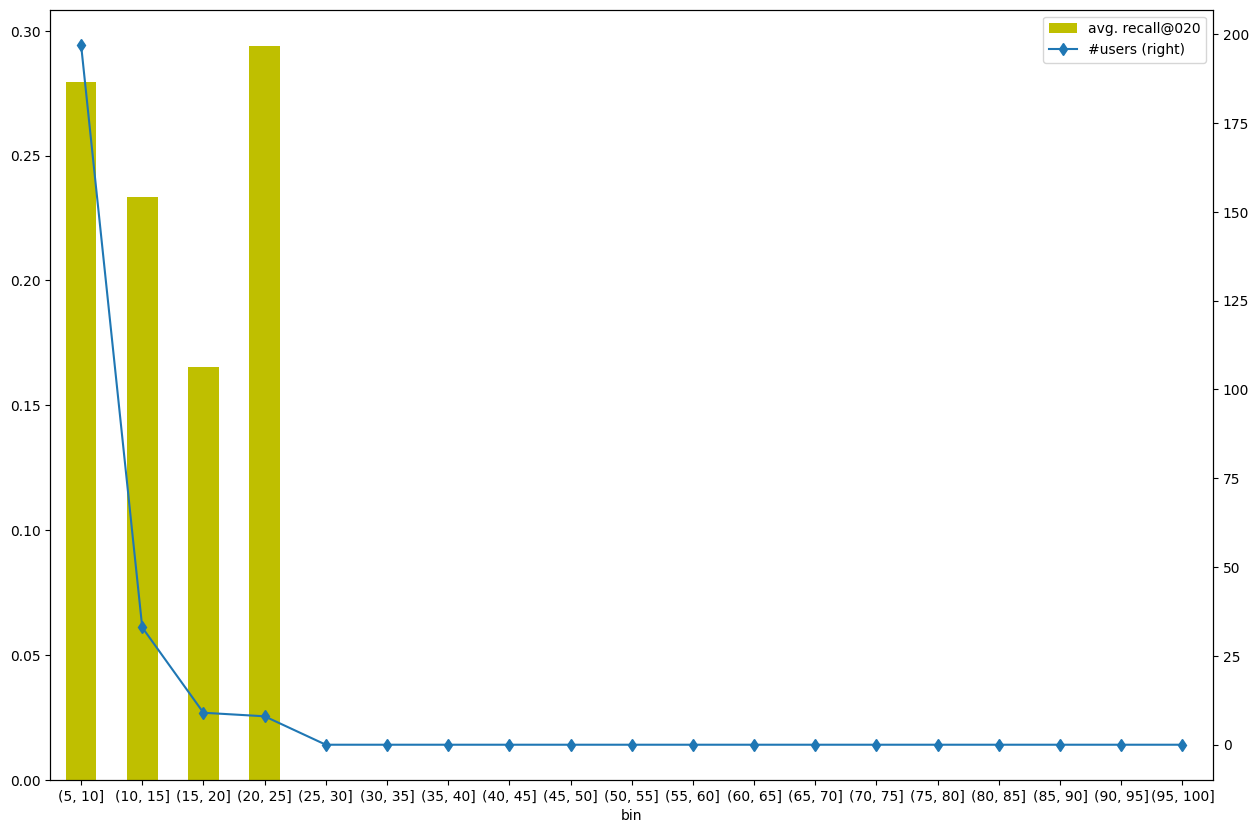

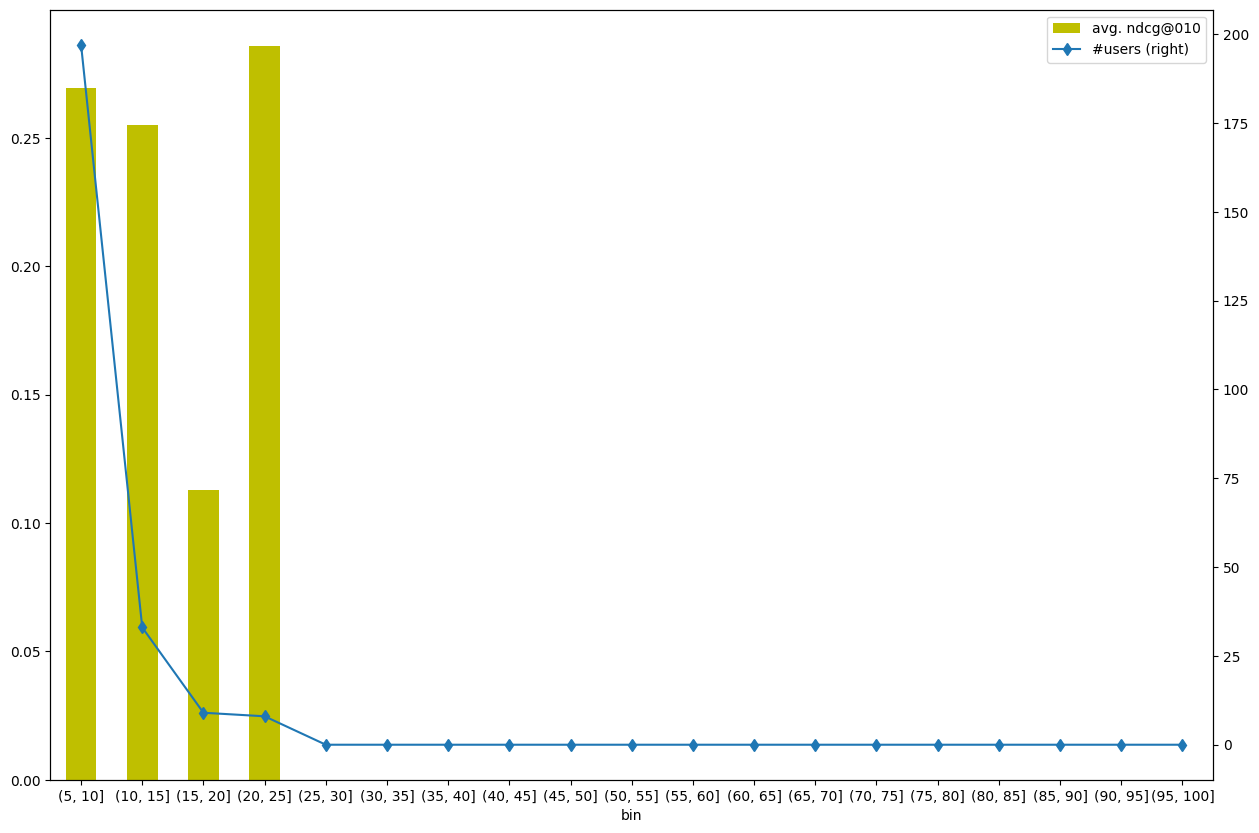

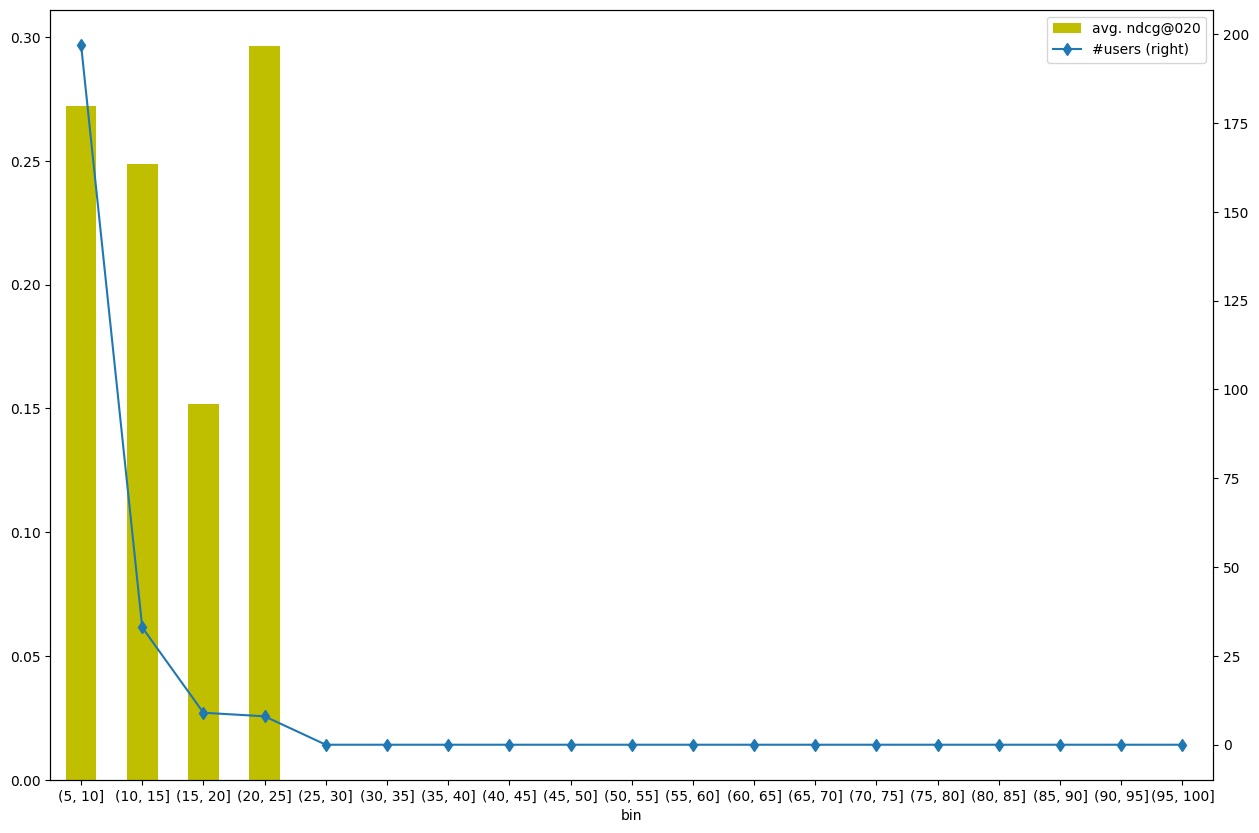

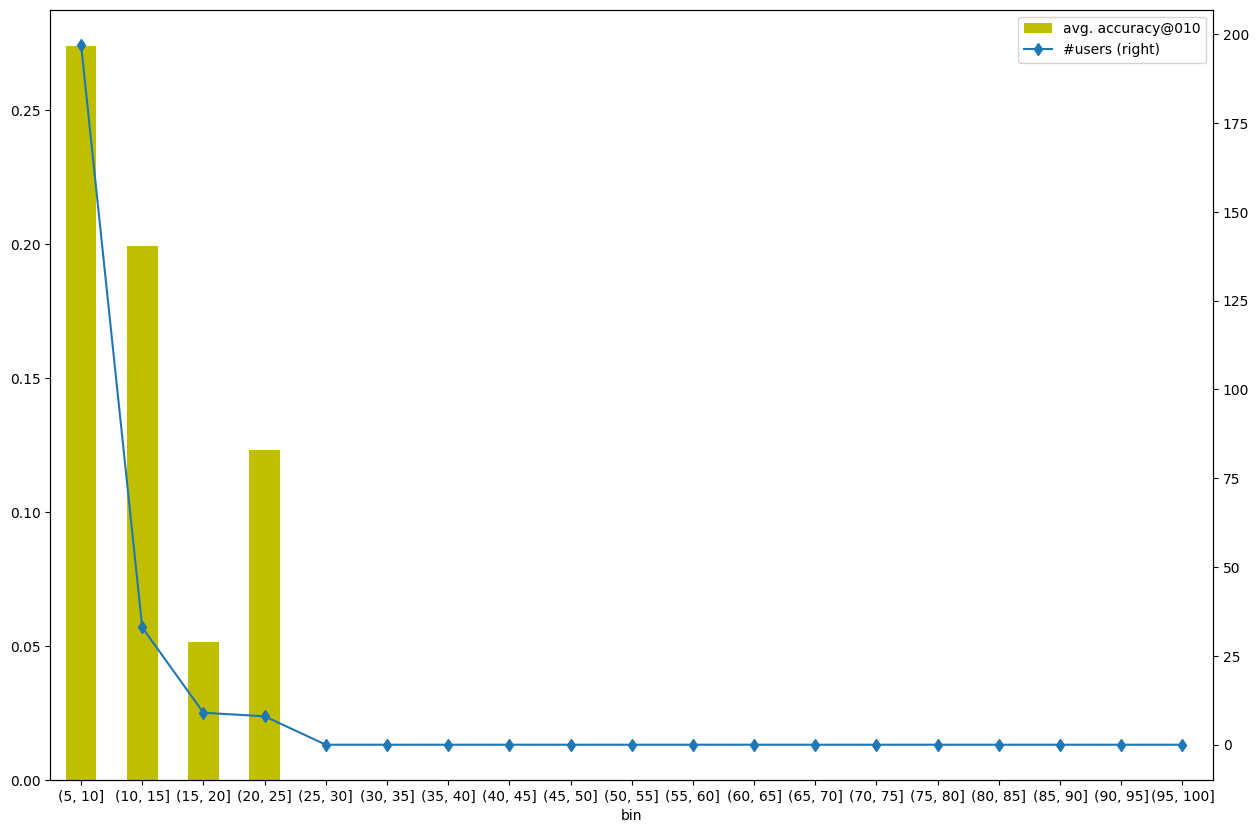

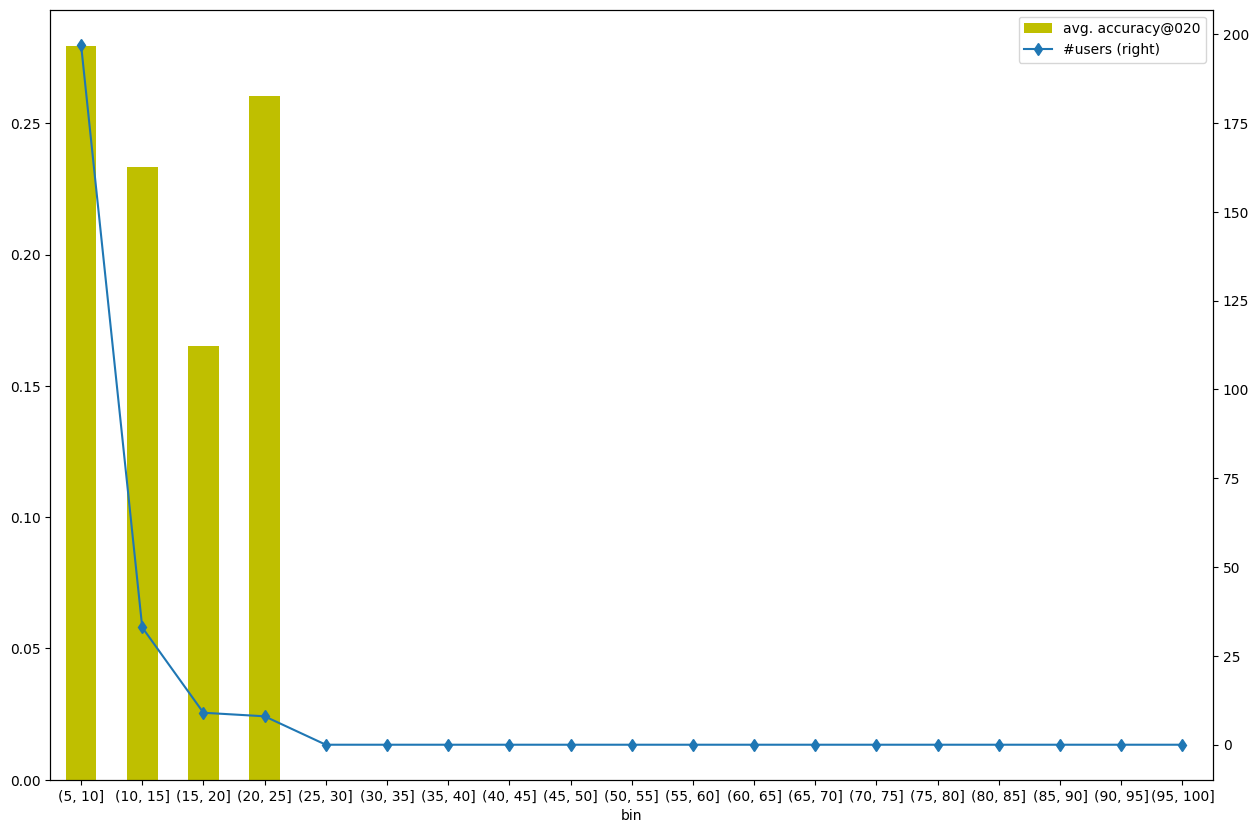

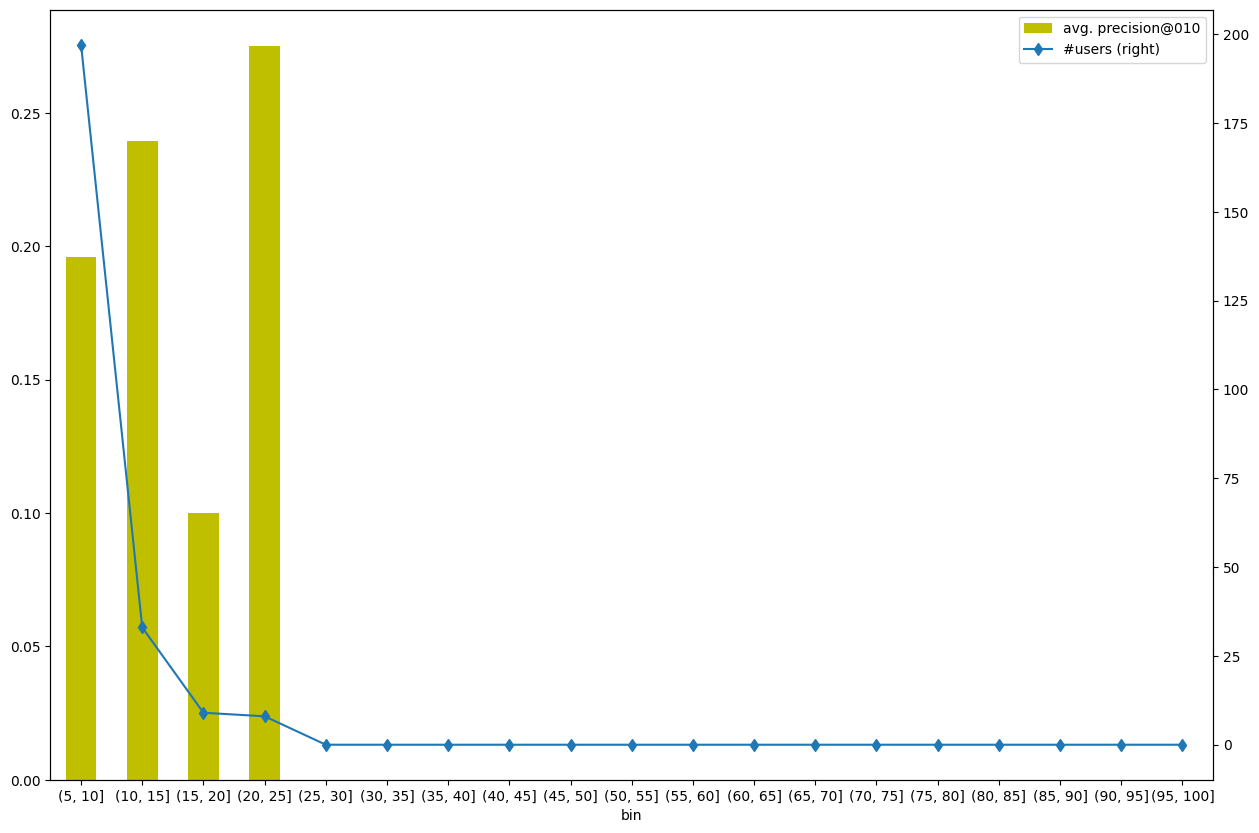

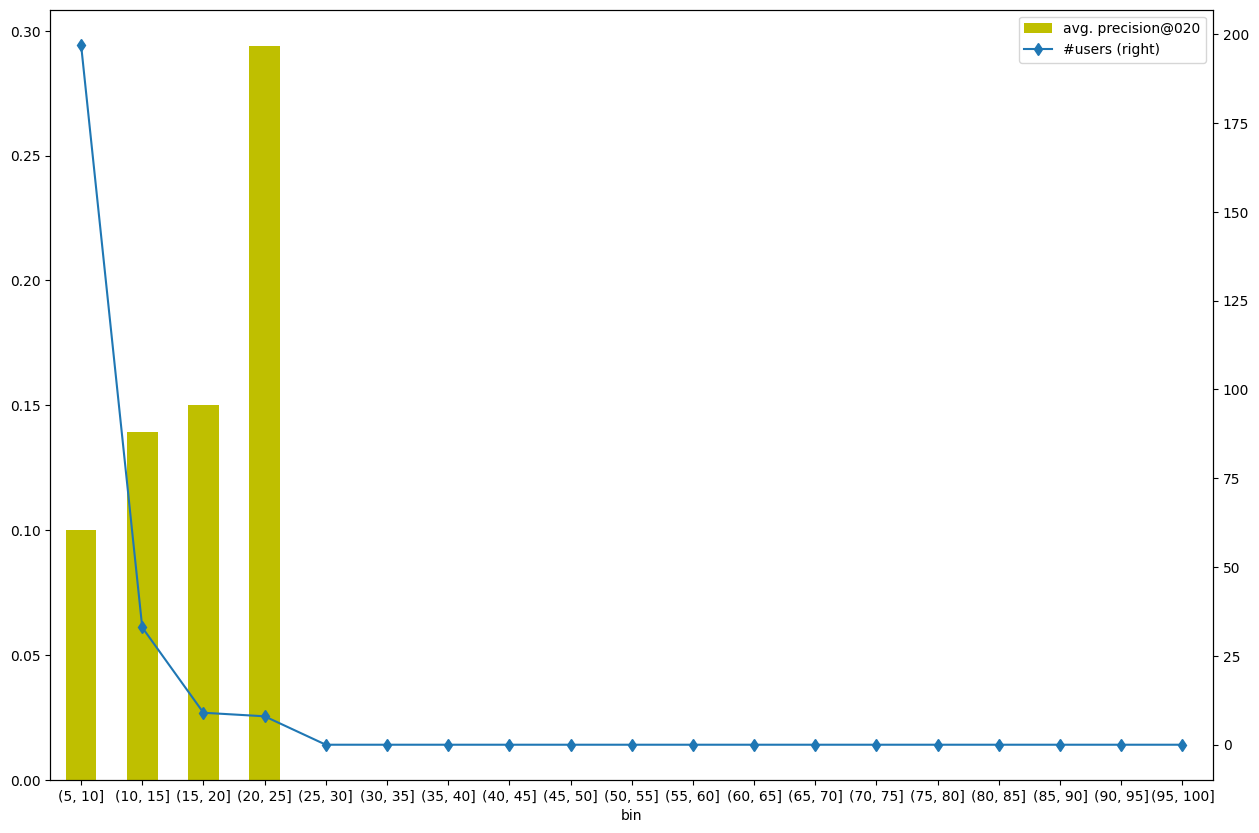

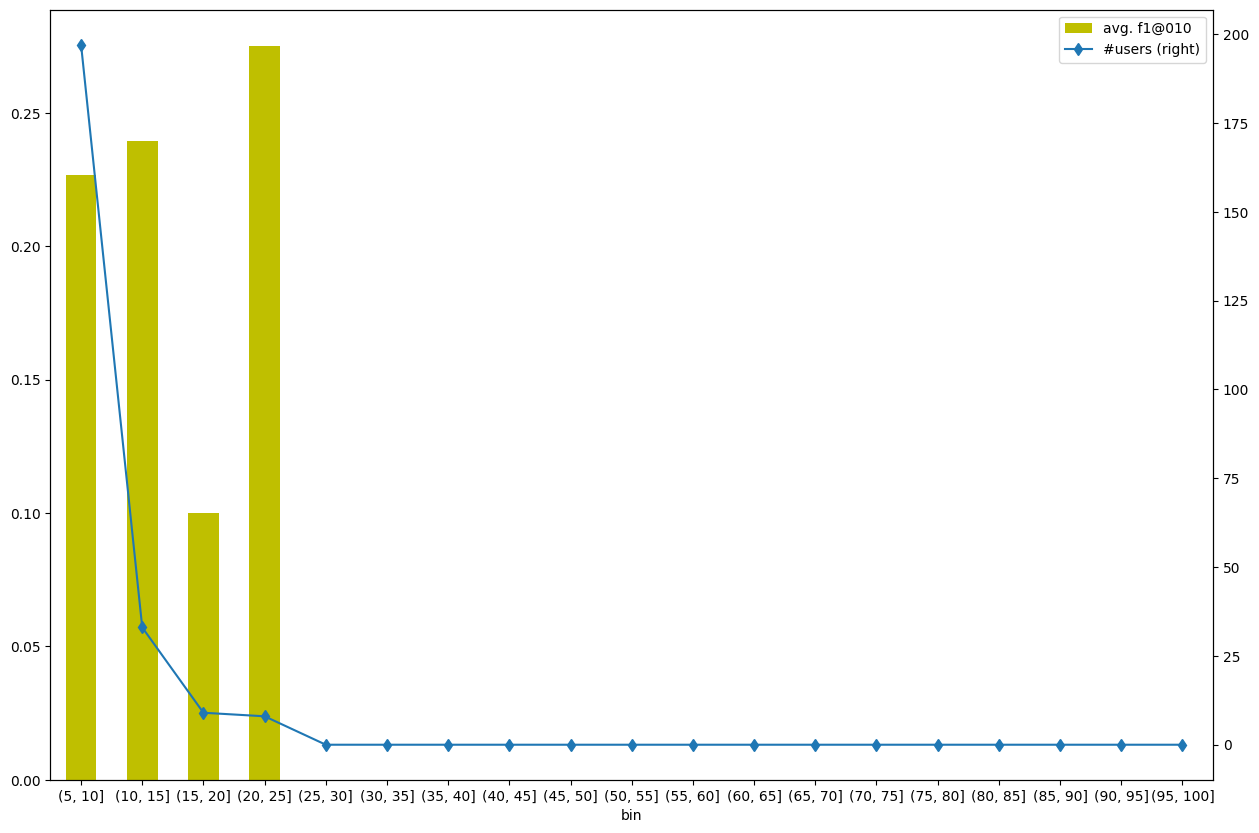

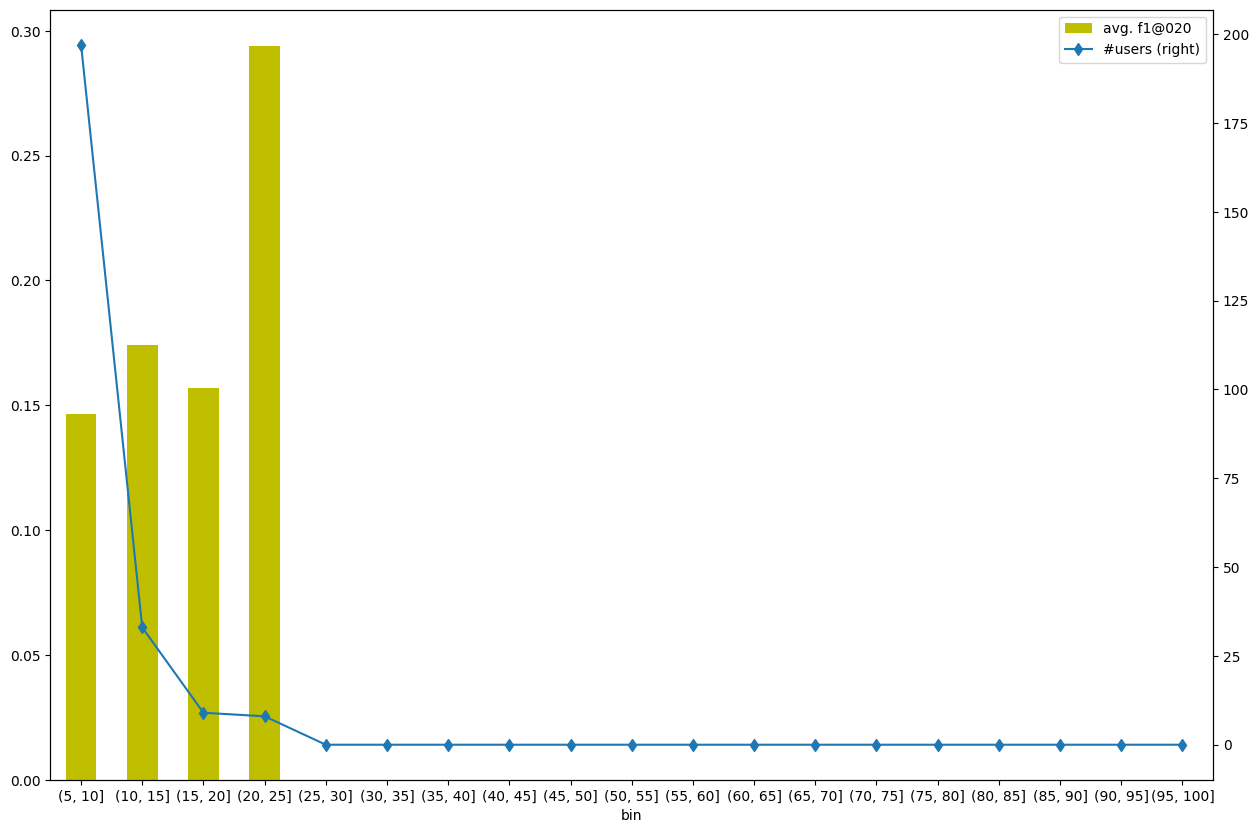

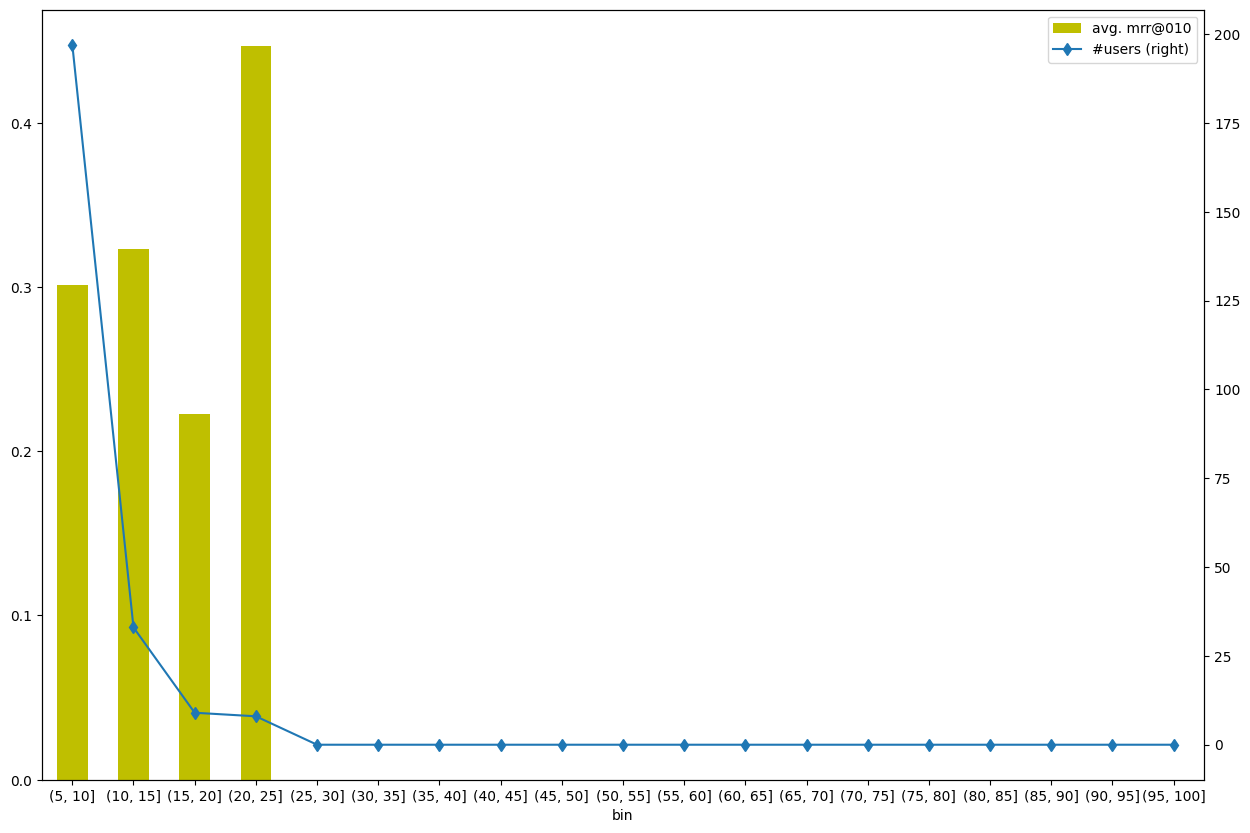

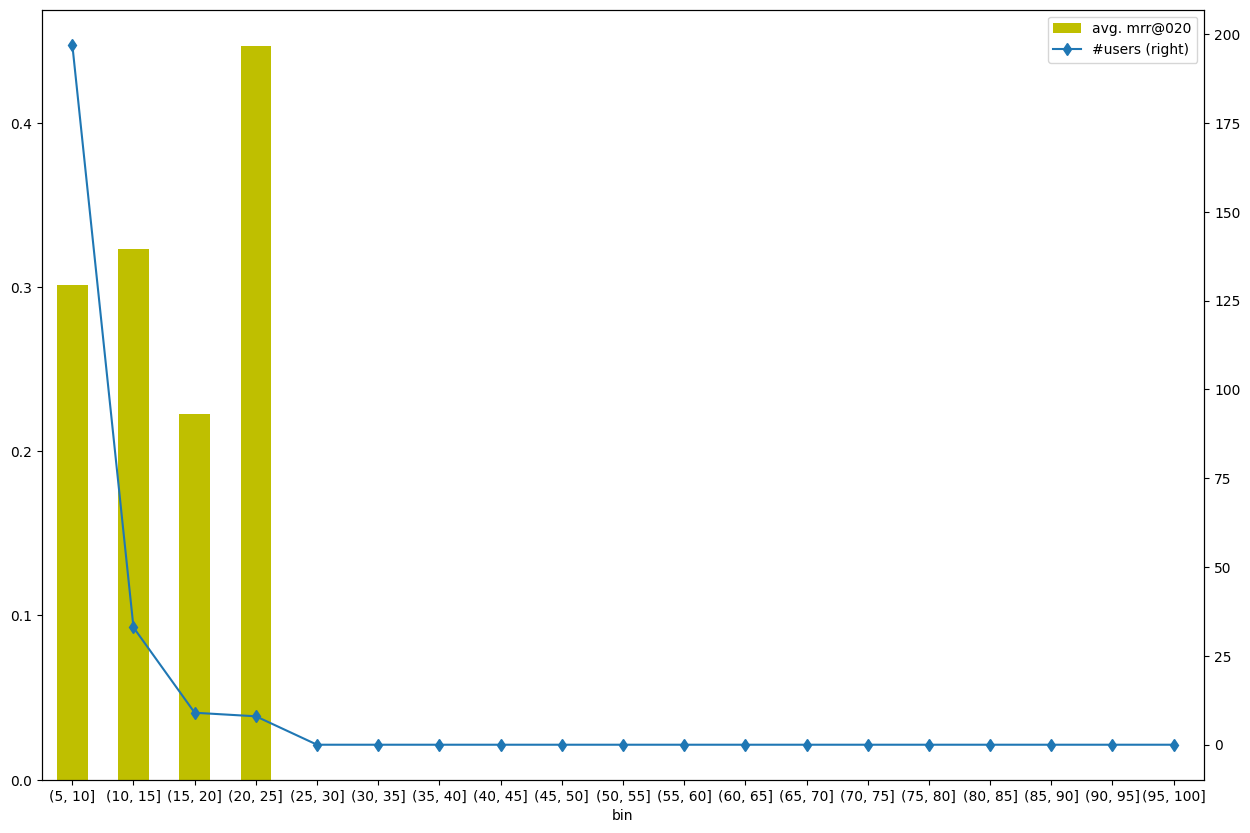

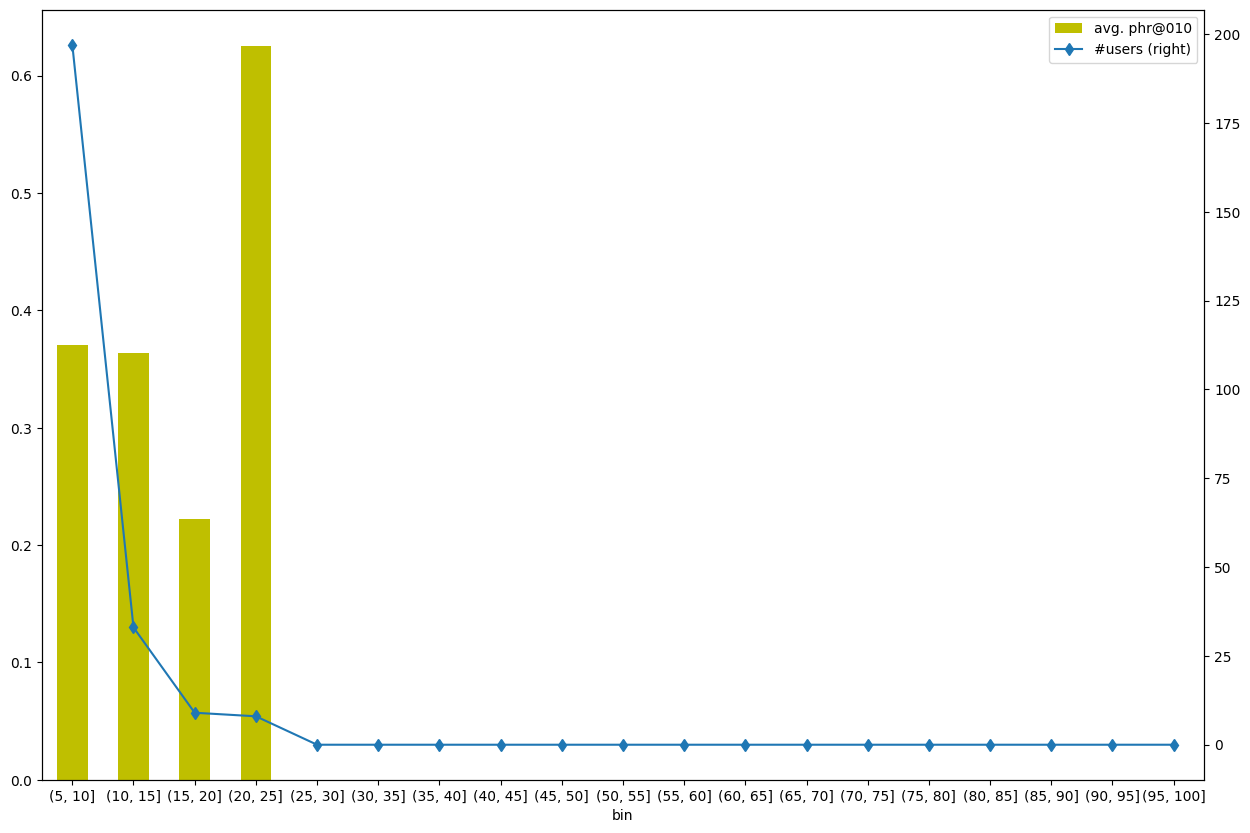

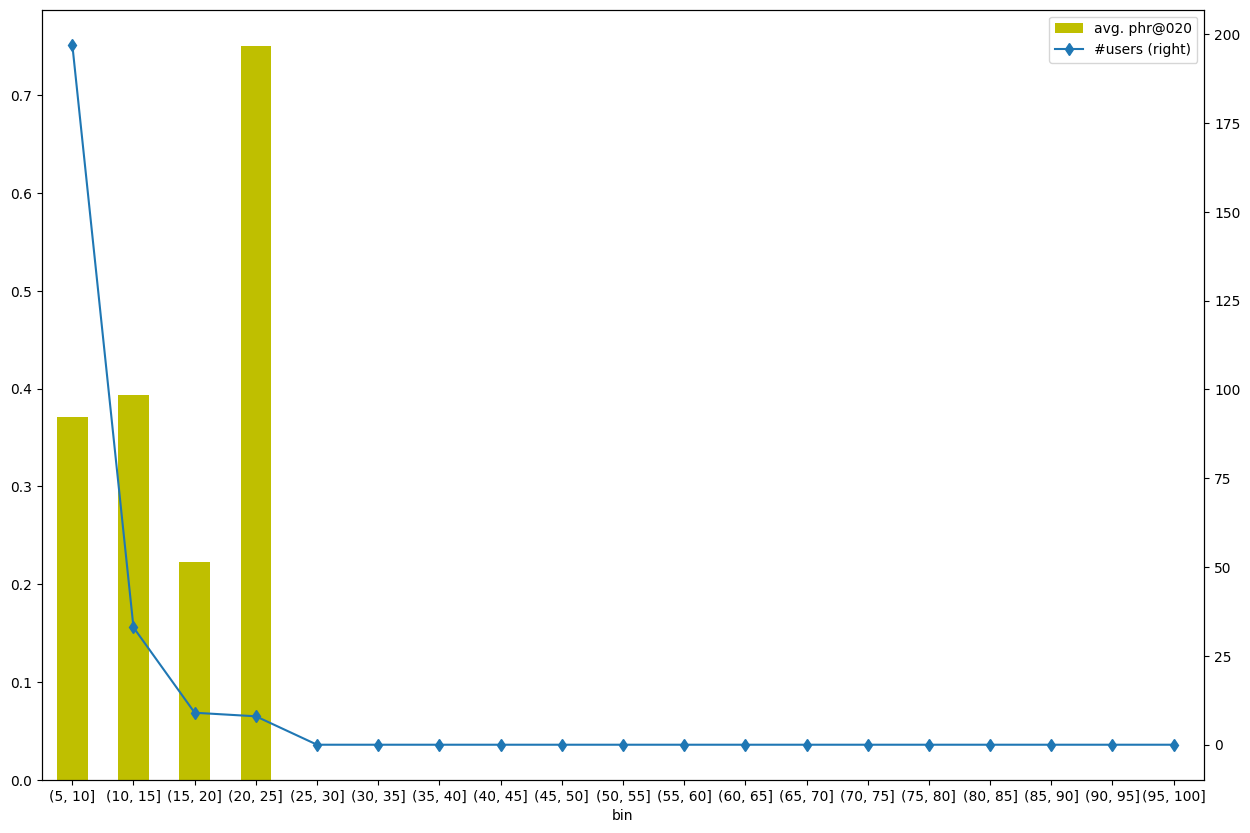

In [422]:
for dataset in datasets:
    path = glob.glob(f'/Users/slawek/PycharmProjects/RecSysProject/results/{dataset}_*_user_metrics.csv')
    df = pd.read_csv(path[0])
    test_df = pd.read_csv(f'/Users/slawek/PycharmProjects/RecSysProject/data/{dataset}/split/test.csv')
    test_df['basket_size'] = test_df.apply(lambda row: len(row['basket'].split(',')), axis=1)
    test_df.drop(columns = ['basket', 'timestamp'], inplace=True)
    df = df.merge(test_df, on=['user_id'])
    df['bin'] = pd.cut(df['basket_size'], list(range(5, 105, 5)))
    metrics = list(df.columns)[:-3]
    for metric in metrics:
        fairness = df.groupby('bin').agg({metric: 'mean', 'user_id': 'count'})
        fig, ax1 = plt.subplots(figsize=(15, 10))
        fairness[metric].plot(kind='bar', color='y', label=f'avg. {metric}')
        leg = plt.legend()
        fairness['user_id'].plot(kind='line', marker='d', secondary_y=True, label='#users')
        leg2 = plt.legend()
        plt.legend(leg.get_patches()+leg2.get_lines(), [text.get_text() for text in leg.get_texts()+leg2.get_texts()],
                   loc='upper right')
        leg.remove()
        plt.savefig(f'/Users/slawek/PycharmProjects/RecSysProject/report_results/fairness/{dataset}_{metric}.png')